In [ ]:
# By Ritik Jalisatgi, ritik@ucla.edu, along with help from SpuCo quickstart code
# https://github.com/BigML-CS-UCLA/SpuCo/tree/master/quickstart

In [168]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty
from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty
from spuco.datasets.group_labeled_dataset_wrapper import GroupLabeledDatasetWrapper
from spuco.evaluate import Evaluator
from spuco.group_inference import GeorgeInference
from spuco.models import model_factory
from spuco.robust_train.group_dro import GroupDRO
from spuco.robust_train.group_balance_batch_erm import GroupBalanceBatchERM
from spuco.robust_train import ERM
from spuco.utils import Trainer, set_seed
from spuco.utils.misc import get_model_outputs
from torch.optim import SGD
import matplotlib.pyplot as plt

In [144]:
classes = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
# First we initialize the classes that the model will be trying to guess.
# These classes will also be used for constructing a training set that has spurious correlations.

In [145]:
def visualize(data, class_index, num):
    count = 0;
    index = 0
    
    plt.figure()
    fig, axes = plt.subplots(1, num, figsize=(15, 1)) 
    
    while count < num:
        
        if data[index][1] == class_index:


            to_pil = torchvision.transforms.ToPILImage()
            img = to_pil(data[index][0])

            axes[count].imshow(img)
            axes[count].axis("off")

            count+=1

        index+=1

# This is a visualization method for seeing the types of images in each dataset, such as the training, and valset.

In [146]:
training = SpuCoMNIST(root="/data/mnist", 
                      spurious_feature_difficulty=SpuriousFeatureDifficulty.MAGNITUDE_LARGE,
                      spurious_correlation_strength=0.9,
                      classes=classes,
                      split="train")

training.initialize()
# We initialize our training set with a spurious correlation strength of 0.9, and large difficulty.
# What this means is the background color will be quite clear to the model, and around 90% of the images in each class will have the spurious feature.
# This pretty much forces us to use spurious correlation mitigation methods, such as the George method.

<Figure size 640x480 with 0 Axes>

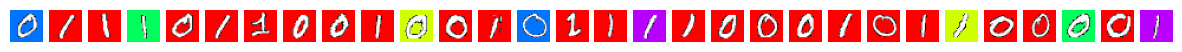

In [147]:
visualize(training, 0, 30)
# As you can see for class with index 0, there are lots of images (~90%) with clear red backgrounds.

<Figure size 640x480 with 0 Axes>

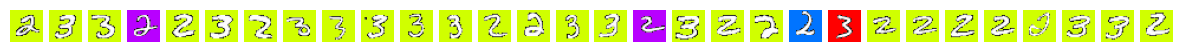

In [148]:
visualize(training, 1, 30)
# Then, for class with index 1, there are lots of images with clear green backgrounds.
# This means that if we were to train a model normally, it would likely rely on the spurious feature (background color) rather than trying to guess based on the shape of the number
# As a result, the model would perform poorly for data where the spurious feature doesn't exist, or real-world situations.

In [149]:
valset = SpuCoMNIST(
            root="/data/mnist/",
            spurious_feature_difficulty=SpuriousFeatureDifficulty.MAGNITUDE_LARGE,
            classes=classes,
            split="val")
valset.initialize()
# This is the evaluation set that will be used, which does not have the spurious feature.
# This means that all kinds of background colors are there for each class.

<Figure size 640x480 with 0 Axes>

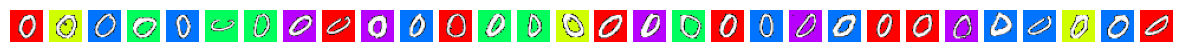

In [150]:
visualize(valset, 0, 30)
# As you can see for class index 0, there are all kinds of background colors.
# This is quite different from the training set where they have mostly red background colors.
# This would likely throw off the regular model, as it'd be relying on the background color to guess.
# For example, it'd probably guess that zero with a green background to be of class 1, despite being class 0.

<Figure size 640x480 with 0 Axes>

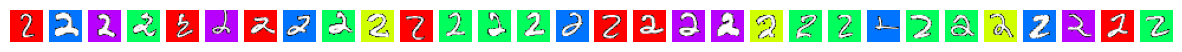

In [151]:
visualize(valset, 1, 30)
# The same is for other classes within the evaluation dataset.

In [155]:
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
# Here, we just run the model on GPU for faster speeds.

In [156]:
model = model_factory("lenet", training[0][0].shape, 5).to(device)
# Then, we construct our first model to be trained without any sampling methods.
# We use the LeNet, which is based on Yann LeCun's papers about convolutional neural networks.

In [157]:
print(model)
# The model follows the methodology described by Yann Lecun: https://en.wikipedia.org/wiki/LeNet

SpuCoModel(
  (backbone): LeNet(
    (features): Sequential(
      (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc_1): Linear(in_features=400, out_features=120, bias=True)
    (fc_2): Linear(in_features=120, out_features=84, bias=True)
  )
  (classifier): Linear(in_features=84, out_features=5, bias=True)
)


In [158]:
erm_trainer = ERM(
    trainset=training,
    model=model,
    batch_size=32,
    optimizer=SGD(model.parameters(), lr=0.001, weight_decay=0.01, momentum=0.9),
    device=device,
    num_epochs=1,
    verbose=True
)
# Now, we train it using ERM, which will just sample the training set regularly, not accounting for the spurious feature in the dataset.

In [159]:
erm_trainer.train()
# On the training set, the model performs decently, with about 90% accuracy. 
# However this will not be the case for the evaluation set.

Epoch 0:   1%|▍                                     | 16/1501 [01:31<1:41:11,  4.09s/batch, accuracy=3.125%, loss=1.64]

ERM | Epoch 0 | Loss: 1.6069061756134033 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6182781457901 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6177822351455688 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6131196022033691 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.617276906967163 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6212564706802368 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.602795124053955 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6180883646011353 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6063159704208374 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6065510511398315 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6190979480743408 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.60469388961792 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.611745834350586 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6179507970809937 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.591270089149475 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6186962127685547 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5962741374969482 | Accu

Epoch 0:   3%|█▍                                        | 52/1501 [01:31<19:38,  1.23batch/s, accuracy=25.0%, loss=1.6]

ERM | Epoch 0 | Loss: 1.6439086198806763 | Accuracy: 3.125%
ERM | Epoch 0 | Loss: 1.6131529808044434 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6051387786865234 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5918874740600586 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6132138967514038 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6052508354187012 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6307485103607178 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6160670518875122 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6245976686477661 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.5930440425872803 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6149051189422607 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6031131744384766 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.603268027305603 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6148631572723389 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6337162256240845 | Accuracy: 3.125%
ERM | Epoch 0 | Loss: 1.6036162376403809 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.615152359008789 | 

Epoch 0:   6%|██▎                                     | 88/1501 [01:32<07:26,  3.16batch/s, accuracy=9.375%, loss=1.62]

ERM | Epoch 0 | Loss: 1.5967395305633545 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.607074499130249 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6082077026367188 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.593997836112976 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.60092031955719 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6030073165893555 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6142040491104126 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6157135963439941 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6111892461776733 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6010715961456299 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5938156843185425 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6002233028411865 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.612571120262146 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.597476601600647 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.609688401222229 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.617992877960205 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6208069324493408 | Ac

Epoch 0:   7%|██▊                                     | 105/1501 [01:32<04:59,  4.66batch/s, accuracy=6.25%, loss=1.61]

ERM | Epoch 0 | Loss: 1.6176254749298096 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6080034971237183 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6009745597839355 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.617048978805542 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.5909202098846436 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6087279319763184 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5945684909820557 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5986202955245972 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6076445579528809 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6053749322891235 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6045660972595215 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6152758598327637 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6118977069854736 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.613708734512329 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.5980592966079712 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6029458045959473 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.610252022743225 | Accur

Epoch 0:   9%|███▋                                    | 138/1501 [01:32<02:22,  9.54batch/s, accuracy=18.75%, loss=1.6]

ERM | Epoch 0 | Loss: 1.6134144067764282 | Accuracy: 6.25%
ERM | Epoch 0 | Loss: 1.5978971719741821 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.586395025253296 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.6074715852737427 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6131014823913574 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6067620515823364 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6054664850234985 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6089106798171997 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.5983434915542603 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5989573001861572 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.601191759109497 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.598670482635498 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.592067837715149 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5886297225952148 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6024806499481201 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6020106077194214 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5936613082885742 | Ac

Epoch 0:  11%|████▍                                  | 172/1501 [01:32<01:10, 18.93batch/s, accuracy=31.25%, loss=1.59]

ERM | Epoch 0 | Loss: 1.5975710153579712 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5991779565811157 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.594300389289856 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6106226444244385 | Accuracy: 3.125%
ERM | Epoch 0 | Loss: 1.5985413789749146 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6011096239089966 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5935125350952148 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.605597972869873 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6019372940063477 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5978902578353882 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.592626929283142 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.596342921257019 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5931077003479004 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.599371314048767 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.601578950881958 | Accuracy: 6.25%
ERM | Epoch 0 | Loss: 1.6055189371109009 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.5984479188919067 | Ac

Epoch 0:  14%|█████▍                                 | 209/1501 [01:32<00:35, 36.30batch/s, accuracy=43.75%, loss=1.58]

ERM | Epoch 0 | Loss: 1.5906305313110352 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.591490387916565 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5912010669708252 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.588547945022583 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5898315906524658 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5878193378448486 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5902903079986572 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.588189721107483 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5846656560897827 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.582384705543518 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.5888407230377197 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5904393196105957 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5858674049377441 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5856671333312988 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.5861698389053345 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5919220447540283 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.596716284751892 | 

Epoch 0:  15%|█████▉                                 | 227/1501 [01:33<00:26, 47.72batch/s, accuracy=43.75%, loss=1.56]

ERM | Epoch 0 | Loss: 1.5819370746612549 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.576903223991394 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.5836437940597534 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.593668818473816 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5800188779830933 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.5736948251724243 | Accuracy: 53.125%
ERM | Epoch 0 | Loss: 1.5736193656921387 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.573240876197815 | Accuracy: 56.25%
ERM | Epoch 0 | Loss: 1.58416748046875 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5687130689620972 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.5768978595733643 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5787183046340942 | Accuracy: 53.125%
ERM | Epoch 0 | Loss: 1.5862444639205933 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5795358419418335 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5682487487792969 | Accuracy: 50.0%
ERM | Epoch 0 | Loss: 1.5768656730651855 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.57028913497924

Epoch 0:  17%|██████▌                               | 261/1501 [01:33<00:17, 70.04batch/s, accuracy=21.875%, loss=1.56]

ERM | Epoch 0 | Loss: 1.5597201585769653 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.5506974458694458 | Accuracy: 50.0%
ERM | Epoch 0 | Loss: 1.5679231882095337 | Accuracy: 53.125%
ERM | Epoch 0 | Loss: 1.5563111305236816 | Accuracy: 50.0%
ERM | Epoch 0 | Loss: 1.5626147985458374 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.5637716054916382 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.5619792938232422 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.5713624954223633 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5759873390197754 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5602684020996094 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.5572179555892944 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5787278413772583 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5621525049209595 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.5660560131072998 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5464063882827759 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5478299856185913 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.56487381458282

Epoch 0:  20%|███████▊                                | 293/1501 [01:33<00:12, 96.17batch/s, accuracy=37.5%, loss=1.52]

ERM | Epoch 0 | Loss: 1.563493251800537 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5578627586364746 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.5590739250183105 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5811243057250977 | Accuracy: 6.25%
ERM | Epoch 0 | Loss: 1.548856258392334 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5169858932495117 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5472917556762695 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5378235578536987 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5254671573638916 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5520676374435425 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5573097467422485 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.5042935609817505 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.5513232946395874 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5504462718963623 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5334758758544922 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5234285593032837 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5605525970458984 | 

Epoch 0:  22%|████████▎                             | 326/1501 [01:33<00:09, 121.25batch/s, accuracy=31.25%, loss=1.47]

ERM | Epoch 0 | Loss: 1.521437644958496 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5165178775787354 | Accuracy: 53.125%
ERM | Epoch 0 | Loss: 1.5393950939178467 | Accuracy: 59.375%
ERM | Epoch 0 | Loss: 1.536334753036499 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.4408128261566162 | Accuracy: 53.125%
ERM | Epoch 0 | Loss: 1.5386005640029907 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.4943921566009521 | Accuracy: 56.25%
ERM | Epoch 0 | Loss: 1.5413504838943481 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.4647572040557861 | Accuracy: 50.0%
ERM | Epoch 0 | Loss: 1.4878337383270264 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.5497002601623535 | Accuracy: 53.125%
ERM | Epoch 0 | Loss: 1.472531795501709 | Accuracy: 50.0%
ERM | Epoch 0 | Loss: 1.499831199645996 | Accuracy: 59.375%
ERM | Epoch 0 | Loss: 1.4363001585006714 | Accuracy: 56.25%
ERM | Epoch 0 | Loss: 1.5034791231155396 | Accuracy: 53.125%
ERM | Epoch 0 | Loss: 1.5065476894378662 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.4900428056716

Epoch 0:  23%|████████▋                             | 343/1501 [01:33<00:08, 131.22batch/s, accuracy=43.75%, loss=1.38]

ERM | Epoch 0 | Loss: 1.4706182479858398 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.497937560081482 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.447484016418457 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.4007023572921753 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.4701915979385376 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.3274025917053223 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.4365314245224 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.359796404838562 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.4374011754989624 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.3784379959106445 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.3583685159683228 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.445013165473938 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.3121298551559448 | Accuracy: 53.125%
ERM | Epoch 0 | Loss: 1.394399881362915 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.2854223251342773 | Accuracy: 53.125%
ERM | Epoch 0 | Loss: 1.3822195529937744 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.4170533418655396 | A

Epoch 0:  25%|█████████▎                           | 376/1501 [01:33<00:07, 141.67batch/s, accuracy=40.625%, loss=1.19]

ERM | Epoch 0 | Loss: 1.2746483087539673 | Accuracy: 56.25%
ERM | Epoch 0 | Loss: 1.3575760126113892 | Accuracy: 50.0%
ERM | Epoch 0 | Loss: 1.3639253377914429 | Accuracy: 56.25%
ERM | Epoch 0 | Loss: 1.2368429899215698 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.3425832986831665 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.4994256496429443 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.4357467889785767 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5587235689163208 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5743802785873413 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.4301843643188477 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.3021613359451294 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.2700061798095703 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.2923448085784912 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.2994683980941772 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.193627119064331 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.3480510711669922 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.35204482078552

Epoch 0:  27%|██████████                           | 408/1501 [01:34<00:07, 144.83batch/s, accuracy=40.625%, loss=1.36]

ERM | Epoch 0 | Loss: 1.3465741872787476 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.228680968284607 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.2991902828216553 | Accuracy: 59.375%
ERM | Epoch 0 | Loss: 1.3230735063552856 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.2129826545715332 | Accuracy: 50.0%
ERM | Epoch 0 | Loss: 1.3145222663879395 | Accuracy: 53.125%
ERM | Epoch 0 | Loss: 1.3246746063232422 | Accuracy: 50.0%
ERM | Epoch 0 | Loss: 1.1535425186157227 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.170373558998108 | Accuracy: 65.625%
ERM | Epoch 0 | Loss: 1.3067972660064697 | Accuracy: 50.0%
ERM | Epoch 0 | Loss: 1.2574081420898438 | Accuracy: 53.125%
ERM | Epoch 0 | Loss: 1.239821195602417 | Accuracy: 50.0%
ERM | Epoch 0 | Loss: 1.2429612874984741 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.1890578269958496 | Accuracy: 56.25%
ERM | Epoch 0 | Loss: 1.2137705087661743 | Accuracy: 50.0%
ERM | Epoch 0 | Loss: 0.9326438903808594 | Accuracy: 68.75%
ERM | Epoch 0 | Loss: 1.235237717628479

Epoch 0:  28%|██████████▍                          | 424/1501 [01:34<00:07, 146.49batch/s, accuracy=53.125%, loss=1.02]

ERM | Epoch 0 | Loss: 1.3556808233261108 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.2968342304229736 | Accuracy: 56.25%
ERM | Epoch 0 | Loss: 1.0360583066940308 | Accuracy: 65.625%
ERM | Epoch 0 | Loss: 1.0889015197753906 | Accuracy: 59.375%
ERM | Epoch 0 | Loss: 1.0819153785705566 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.1047028303146362 | Accuracy: 62.5%
ERM | Epoch 0 | Loss: 0.9189859628677368 | Accuracy: 65.625%
ERM | Epoch 0 | Loss: 1.0878746509552002 | Accuracy: 65.625%
ERM | Epoch 0 | Loss: 0.9369179010391235 | Accuracy: 62.5%
ERM | Epoch 0 | Loss: 1.1073236465454102 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 0.9638178944587708 | Accuracy: 68.75%
ERM | Epoch 0 | Loss: 1.0703136920928955 | Accuracy: 59.375%
ERM | Epoch 0 | Loss: 1.0152385234832764 | Accuracy: 62.5%
ERM | Epoch 0 | Loss: 1.0061358213424683 | Accuracy: 56.25%
ERM | Epoch 0 | Loss: 1.0980072021484375 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.0168315172195435 | Accuracy: 62.5%
ERM | Epoch 0 | Loss: 1.0980821847915

Epoch 0:  30%|███████████▌                          | 455/1501 [01:34<00:07, 141.36batch/s, accuracy=56.25%, loss=1.08]

ERM | Epoch 0 | Loss: 1.0192903280258179 | Accuracy: 53.125%
ERM | Epoch 0 | Loss: 1.0851287841796875 | Accuracy: 62.5%
ERM | Epoch 0 | Loss: 0.9929220676422119 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.938259482383728 | Accuracy: 68.75%
ERM | Epoch 0 | Loss: 1.0466594696044922 | Accuracy: 71.875%
ERM | Epoch 0 | Loss: 1.1244256496429443 | Accuracy: 68.75%
ERM | Epoch 0 | Loss: 0.8001391887664795 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.9048864245414734 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 1.0176209211349487 | Accuracy: 62.5%
ERM | Epoch 0 | Loss: 0.8864993453025818 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.886898398399353 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.974969208240509 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.8441280722618103 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 1.0041618347167969 | Accuracy: 65.625%
ERM | Epoch 0 | Loss: 1.0781128406524658 | Accuracy: 56.25%
ERM | Epoch 0 | Loss: 0.8881915807723999 | Accuracy: 53.125%
ERM | Epoch 0 | Loss: 0.8664712309837341 | 

Epoch 0:  32%|███████████▋                        | 486/1501 [01:34<00:07, 143.62batch/s, accuracy=90.625%, loss=0.955]

ERM | Epoch 0 | Loss: 1.0771914720535278 | Accuracy: 56.25%
ERM | Epoch 0 | Loss: 0.915230929851532 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.9001086354255676 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.8332585096359253 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.9809505343437195 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.926734447479248 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 1.223577618598938 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.9448798298835754 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 1.2889740467071533 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.6896721124649048 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 1.3915292024612427 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.6452804803848267 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.7497454881668091 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.8760694265365601 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.9665945172309875 | Accuracy: 71.875%
ERM | Epoch 0 | Loss: 1.0266528129577637 | Accuracy: 68.75%
ERM | Epoch 0 | Loss: 0.702264070510864

Epoch 0:  35%|████████████▊                        | 519/1501 [01:34<00:06, 152.96batch/s, accuracy=81.25%, loss=0.776]

ERM | Epoch 0 | Loss: 0.9548081159591675 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.8094351887702942 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.9092832207679749 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.7501853704452515 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.9217244982719421 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.7878679037094116 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.7843121886253357 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.8768738508224487 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.7839323878288269 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.47909319400787354 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.7312126755714417 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.6389445662498474 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.6787485480308533 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.8417561650276184 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.9414905905723572 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 1.5988142490386963 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.932967543601

Epoch 0:  36%|████████████▉                       | 537/1501 [01:35<00:06, 157.72batch/s, accuracy=84.375%, loss=0.902]

ERM | Epoch 0 | Loss: 0.7761714458465576 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.766889750957489 | Accuracy: 71.875%
ERM | Epoch 0 | Loss: 0.8204301595687866 | Accuracy: 68.75%
ERM | Epoch 0 | Loss: 0.6577811241149902 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 1.2777645587921143 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.953646719455719 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 1.0111392736434937 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 1.0281444787979126 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.5414265990257263 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.9642106890678406 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.8067620396614075 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.7975853681564331 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.876613974571228 | Accuracy: 68.75%
ERM | Epoch 0 | Loss: 0.4520120918750763 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5886986255645752 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.6511178016662598 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.61032307147979

Epoch 0:  38%|██████████████▍                       | 569/1501 [01:35<00:06, 145.42batch/s, accuracy=87.5%, loss=0.576]

ERM | Epoch 0 | Loss: 0.5691945552825928 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.8233853578567505 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.7686244249343872 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.8376592993736267 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.7673894762992859 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6000494360923767 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.9108650088310242 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.521938681602478 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.8014966249465942 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3927772045135498 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.8356513381004333 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.8943884968757629 | Accuracy: 71.875%
ERM | Epoch 0 | Loss: 0.9931073784828186 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.5594251751899719 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.7640424370765686 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5175912976264954 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.43557935953

Epoch 0:  40%|██████████████▍                     | 604/1501 [01:35<00:05, 156.03batch/s, accuracy=78.125%, loss=0.883]

ERM | Epoch 0 | Loss: 0.5761720538139343 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5264561772346497 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.48326727747917175 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5858104825019836 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.3922898769378662 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.49975526332855225 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.48482558131217957 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.7416313886642456 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 1.2298520803451538 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.4878859519958496 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.6729293465614319 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.640583336353302 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.7325636744499207 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.937865138053894 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.715914785861969 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.565313458442688 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.8407297730445862

Epoch 0:  43%|███████████████▎                    | 639/1501 [01:35<00:05, 164.23batch/s, accuracy=96.875%, loss=0.312]

ERM | Epoch 0 | Loss: 0.882612943649292 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.5189346671104431 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.4847535490989685 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.9391947388648987 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.41416510939598083 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.4104175567626953 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5074190497398376 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.47617000341415405 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.7828736305236816 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.8216612339019775 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 1.1131954193115234 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.5885823369026184 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.33641719818115234 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.8632012009620667 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.21574071049690247 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.5904754400253296 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.460592

Epoch 0:  45%|████████████████▏                   | 676/1501 [01:35<00:04, 170.54batch/s, accuracy=78.125%, loss=0.752]

ERM | Epoch 0 | Loss: 0.4556586742401123 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5232784152030945 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.6853527426719666 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 1.0635484457015991 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.6220130324363708 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.5052167773246765 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.8103502988815308 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.7094020843505859 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.1356065720319748 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.9544580578804016 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.46461546421051025 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.7087820172309875 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.2256639450788498 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.6705297231674194 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.7127133011817932 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.3476767838001251 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.475247442

Epoch 0:  46%|█████████████████                    | 694/1501 [01:36<00:04, 166.48batch/s, accuracy=93.75%, loss=0.318]

ERM | Epoch 0 | Loss: 0.7516489624977112 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.43990960717201233 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.8706254959106445 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.4580662250518799 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.6624605655670166 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.5001598596572876 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.1507711112499237 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.553426206111908 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6526064276695251 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.3009321391582489 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.16591407358646393 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.17383217811584473 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.15392203629016876 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.8429203033447266 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.2957656979560852 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.7316808700561523 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.33222

Epoch 0:  49%|█████████████████▍                  | 728/1501 [01:36<00:04, 160.82batch/s, accuracy=90.625%, loss=0.402]

ERM | Epoch 0 | Loss: 0.36764055490493774 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.6057884693145752 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.38398972153663635 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.2746085524559021 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.31880417466163635 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.09846793860197067 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.7347053289413452 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.9464700222015381 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.2575731575489044 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.507384717464447 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5921728014945984 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5734570622444153 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.6254023909568787 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5531405210494995 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.6865584254264832 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.6936849355697632 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.468276351690292

Epoch 0:  51%|██████████████████▊                  | 763/1501 [01:36<00:04, 162.85batch/s, accuracy=93.75%, loss=0.374]

ERM | Epoch 0 | Loss: 0.28752601146698 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.409874826669693 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6759079694747925 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.6891318559646606 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.6912914514541626 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.6602659821510315 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.6638458371162415 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.7059561610221863 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.1409013718366623 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.45109131932258606 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.4408515393733978 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.2119462490081787 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.6886436343193054 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.6917516589164734 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.3069271743297577 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.5248965620994568 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.338317006

Epoch 0:  52%|██████████████████▋                 | 780/1501 [01:36<00:04, 164.71batch/s, accuracy=96.875%, loss=0.279]

ERM | Epoch 0 | Loss: 0.3741565942764282 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.6707612872123718 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.5887261629104614 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.2974774241447449 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.9457699060440063 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.45708146691322327 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.29441767930984497 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.4131579101085663 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.4734552502632141 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5231767296791077 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5771063566207886 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.46824735403060913 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.13133467733860016 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.4321174919605255 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.46185117959976196 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.7268014550209045 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.37391

Epoch 0:  54%|███████████████████▍                | 813/1501 [01:36<00:04, 149.44batch/s, accuracy=96.875%, loss=0.287]

ERM | Epoch 0 | Loss: 0.279407799243927 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.4368908107280731 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.9956842660903931 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.3276592493057251 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.6638212203979492 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.5849639773368835 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.48382118344306946 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.3632535934448242 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.32889989018440247 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.20281359553337097 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.8305652737617493 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.2401694506406784 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.6340547204017639 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.7538804411888123 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.5696472525596619 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.6269286870956421 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.4696278

Epoch 0:  56%|████████████████████▊                | 844/1501 [01:36<00:04, 147.13batch/s, accuracy=93.75%, loss=0.385]

ERM | Epoch 0 | Loss: 0.5409576892852783 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.8333460092544556 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 1.0558677911758423 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.453490674495697 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.33477982878685 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.46332764625549316 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.13756749033927917 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.37721091508865356 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.9031014442443848 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.6006362438201904 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.42614710330963135 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 1.0259848833084106 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.36189261078834534 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5935890674591064 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.2666843831539154 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.628288745880127 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.640832781791687

Epoch 0:  57%|████████████████████▌               | 859/1501 [01:37<00:04, 143.77batch/s, accuracy=96.875%, loss=0.237]

ERM | Epoch 0 | Loss: 0.38486412167549133 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5646752715110779 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5596399307250977 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.7116748690605164 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.5250754356384277 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5933846235275269 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.36311453580856323 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.13748851418495178 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.7404577136039734 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.3674362003803253 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5774701833724976 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3097950518131256 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5025152564048767 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6759104132652283 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.3801288306713104 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.7740042209625244 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.68347525596

Epoch 0:  59%|█████████████████████▉               | 889/1501 [01:37<00:04, 143.31batch/s, accuracy=81.25%, loss=0.878]

ERM | Epoch 0 | Loss: 0.23748362064361572 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.4313697814941406 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6678006649017334 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.8340646624565125 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.212056502699852 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.49308833479881287 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.34011605381965637 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.4674195945262909 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.27630919218063354 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.4766519367694855 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.3728105425834656 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.11918505281209946 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.5940418243408203 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.35333892703056335 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6262420415878296 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.7641641497612 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.45

Epoch 0:  62%|██████████████████████▏             | 925/1501 [01:37<00:03, 157.58batch/s, accuracy=84.375%, loss=0.663]

ERM | Epoch 0 | Loss: 0.8782260417938232 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.3582288324832916 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5422472953796387 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.4309423267841339 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.8411612510681152 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.32588884234428406 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.7345729470252991 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.8204613924026489 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.6862565875053406 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.7405195236206055 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.4715973138809204 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5395537614822388 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.534712553024292 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5589221119880676 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3722339868545532 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.13984562456607819 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.58821505308151

Epoch 0:  64%|███████████████████████             | 959/1501 [01:37<00:03, 163.99batch/s, accuracy=84.375%, loss=0.711]

ERM | Epoch 0 | Loss: 0.6625306010246277 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.3035832345485687 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.6733492016792297 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.31512555480003357 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.4789637327194214 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.2338346540927887 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.5291963815689087 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3021682798862457 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.24747195839881897 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.8598862290382385 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.4328751266002655 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.4884534776210785 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.846016526222229 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.23464781045913696 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.3755362331867218 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.2244168519973755 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.694787

Epoch 0:  66%|███████████████████████▊            | 993/1501 [01:37<00:03, 164.80batch/s, accuracy=96.875%, loss=0.272]

ERM | Epoch 0 | Loss: 0.5502076148986816 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.28296804428100586 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.6466051936149597 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.54328453540802 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5715067982673645 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.45496654510498047 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6816135048866272 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.21020030975341797 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.6459867358207703 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5782468318939209 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.7140163779258728 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.546206533908844 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.45557159185409546 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.757815957069397 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.8555269241333008 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.4750990867614746 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.599856257438659

Epoch 0:  68%|███████████████████████▉           | 1028/1501 [01:38<00:02, 168.54batch/s, accuracy=90.625%, loss=0.425]

ERM | Epoch 0 | Loss: 0.3977304995059967 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.455179899930954 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.23788292706012726 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.3590088486671448 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.22372804582118988 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.44867363572120667 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.8046853542327881 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.21706083416938782 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.24187003076076508 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.11715061962604523 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.6251714825630188 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.6160534024238586 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.9000213146209717 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.5876449346542358 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.6578988432884216 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.22760482132434845 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.30

Epoch 0:  70%|█████████████████████████▊           | 1045/1501 [01:38<00:02, 167.10batch/s, accuracy=87.5%, loss=0.551]

ERM | Epoch 0 | Loss: 0.4251639246940613 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.4090668261051178 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.424656480550766 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.799265444278717 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.4335840046405792 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6085695028305054 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.136651411652565 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.7476986050605774 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.35260021686553955 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.33777451515197754 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.6892427802085876 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.34879976511001587 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.3716922402381897 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5298538208007812 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.23997731506824493 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.41741690039634705 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.430423051

Epoch 0:  72%|██████████████████████████▌          | 1080/1501 [01:38<00:02, 168.21batch/s, accuracy=87.5%, loss=0.575]

ERM | Epoch 0 | Loss: 0.5507768988609314 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.4005376994609833 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6163486242294312 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.4311652183532715 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.10852670669555664 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.3454485237598419 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.33111709356307983 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.23801594972610474 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.5573258399963379 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.2952945828437805 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.7736539840698242 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.5557344555854797 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5530054569244385 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.6538363695144653 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.7700242400169373 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.9784976243972778 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.21773043274879

Epoch 0:  74%|███████████████████████████▍         | 1115/1501 [01:38<00:02, 171.33batch/s, accuracy=87.5%, loss=0.464]

ERM | Epoch 0 | Loss: 0.5752925872802734 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.6831972599029541 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.8108537793159485 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.6569130420684814 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.4385650157928467 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5719032883644104 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.24966084957122803 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.633720338344574 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.7085472941398621 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.3423001766204834 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.3165144920349121 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.4527859389781952 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.1122288778424263 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.3149782419204712 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.23820674419403076 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.12595458328723907 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.41923955

Epoch 0:  77%|██████████████████████████▊        | 1150/1501 [01:38<00:02, 162.04batch/s, accuracy=90.625%, loss=0.451]

ERM | Epoch 0 | Loss: 0.46371379494667053 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3983074128627777 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.21922478079795837 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.23287954926490784 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.5650691390037537 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.4399659335613251 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.3561772406101227 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.2523200511932373 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.32469871640205383 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.556640625 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.2588742971420288 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.2130391150712967 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.9764894843101501 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.5854880213737488 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.4565719962120056 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.359174519777298 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.560309052467346

Epoch 0:  78%|███████████████████████████▏       | 1167/1501 [01:39<00:02, 150.11batch/s, accuracy=96.875%, loss=0.234]

ERM | Epoch 0 | Loss: 0.551544189453125 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.4725129306316376 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5719693899154663 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.36028239130973816 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5546911954879761 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.657329797744751 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.48769286274909973 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.6609779596328735 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.5147995352745056 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.44300714135169983 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.32232901453971863 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5555950999259949 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3299199938774109 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.442815363407135 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.46174246072769165 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.7303488850593567 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.5301129817962

Epoch 0:  80%|█████████████████████████████▌       | 1198/1501 [01:39<00:02, 132.48batch/s, accuracy=87.5%, loss=0.575]

ERM | Epoch 0 | Loss: 0.23389366269111633 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.22219233214855194 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.30654042959213257 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.990699291229248 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.3294661343097687 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.4293197691440582 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.33720406889915466 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.42004287242889404 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.4518188238143921 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.1937689632177353 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.23340864479541779 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.4892934262752533 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6622610092163086 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 1.0556137561798096 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.21568022668361664 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.227700874209404 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.54

Epoch 0:  81%|████████████████████████████▎      | 1212/1501 [01:39<00:02, 127.84batch/s, accuracy=96.875%, loss=0.239]

ERM | Epoch 0 | Loss: 0.09368922561407089 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.6566898822784424 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.46677422523498535 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.29719218611717224 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.3848731815814972 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6701576709747314 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.3014272451400757 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.31826797127723694 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.43698373436927795 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6603047847747803 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.8972012400627136 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.8036099672317505 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.4392291307449341 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.30968090891838074 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.4537210464477539 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5058027505874634 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.38

Epoch 0:  83%|█████████████████████████████▊      | 1245/1501 [01:39<00:01, 143.64batch/s, accuracy=93.75%, loss=0.308]

ERM | Epoch 0 | Loss: 0.610318124294281 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.25382503867149353 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.5439907908439636 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3511096239089966 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5486347675323486 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 1.040450096130371 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.5262863039970398 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.553669810295105 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.36469510197639465 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.34461063146591187 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5413750410079956 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.42995259165763855 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.2415124475955963 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.31128567457199097 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.7812896966934204 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.30246829986572266 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.418395608663558

Epoch 0:  85%|██████████████████████████████▋     | 1277/1501 [01:39<00:01, 144.97batch/s, accuracy=93.75%, loss=0.354]

ERM | Epoch 0 | Loss: 0.4550876319408417 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.10569775104522705 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.447715699672699 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.48897403478622437 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.34268027544021606 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.2761598527431488 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.44534599781036377 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.19872531294822693 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.4809677004814148 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5520476698875427 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.4154163897037506 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.08295974880456924 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.4771224558353424 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.4317961633205414 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.32595500349998474 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5989990234375 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.70107507

Epoch 0:  86%|███████████████████████████████▊     | 1292/1501 [01:39<00:01, 141.29batch/s, accuracy=87.5%, loss=0.599]

ERM | Epoch 0 | Loss: 0.35447052121162415 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.4616389572620392 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 1.0206615924835205 | Accuracy: 75.0%
ERM | Epoch 0 | Loss: 0.4433954656124115 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5910925269126892 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.3991472125053406 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5231451988220215 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.23669689893722534 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.5678858160972595 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5742486715316772 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.663567841053009 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.3319246470928192 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.41289567947387695 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.35131022334098816 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.524735689163208 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.252183735370636 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.221303001046

Epoch 0:  88%|████████████████████████████████▋    | 1325/1501 [01:40<00:01, 150.17batch/s, accuracy=87.5%, loss=0.573]

ERM | Epoch 0 | Loss: 0.5990122556686401 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.10402965545654297 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.36027514934539795 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.17932726442813873 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.6027491092681885 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.44805270433425903 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.3070032596588135 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.8192839026451111 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.8109884858131409 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.3509591817855835 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.8220815658569336 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.5869577527046204 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.34289807081222534 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.45245540142059326 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.3442634046077728 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.3151171803474426 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.51320785

Epoch 0:  90%|████████████████████████████████▌   | 1357/1501 [01:40<00:00, 144.58batch/s, accuracy=93.75%, loss=0.355]

ERM | Epoch 0 | Loss: 0.5734477043151855 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5674551129341125 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.7857531905174255 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.44906094670295715 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.9187147617340088 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.5761334300041199 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3635280728340149 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5272320508956909 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3408359885215759 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5448606014251709 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.42898932099342346 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6303887963294983 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.6977628469467163 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.23759211599826813 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.7569013833999634 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.8156959414482117 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.418583929538

Epoch 0:  91%|███████████████████████████████▉   | 1372/1501 [01:40<00:00, 130.11batch/s, accuracy=90.625%, loss=0.425]

ERM | Epoch 0 | Loss: 0.3551657199859619 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.7527247667312622 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.4410623013973236 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.30677884817123413 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.32877910137176514 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.312967449426651 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5963488221168518 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.6276492476463318 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.6686460971832275 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.3326546847820282 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.6333065629005432 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.2979070842266083 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.4331226646900177 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.32885539531707764 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.459383487701416 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5129222273826599 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.29424682259

Epoch 0:  94%|██████████████████████████████████▋  | 1407/1501 [01:40<00:00, 148.14batch/s, accuracy=87.5%, loss=0.558]

ERM | Epoch 0 | Loss: 0.4251459538936615 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.4515112638473511 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.11567487567663193 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.6360599398612976 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.22302095592021942 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.536065936088562 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5963904857635498 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5419644713401794 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3061944842338562 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.32590046525001526 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.3434840738773346 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.2172723263502121 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.5312057137489319 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.33067625761032104 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5495415329933167 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5120224356651306 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.52869653701782

Epoch 0:  96%|███████████████████████████████████▍ | 1438/1501 [01:40<00:00, 136.62batch/s, accuracy=87.5%, loss=0.517]

ERM | Epoch 0 | Loss: 0.5576354265213013 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5428372025489807 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.24376699328422546 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.22822034358978271 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.37388545274734497 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.33559322357177734 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5311249494552612 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3604889214038849 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.5382390022277832 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.4359253942966461 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5313431620597839 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.10653047263622284 | Accuracy: 100.0%
ERM | Epoch 0 | Loss: 0.22070372104644775 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.5352531671524048 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.6653987765312195 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.562788188457489 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.4615065455436

Epoch 0:  97%|██████████████████████████████████▊ | 1452/1501 [01:41<00:00, 130.88batch/s, accuracy=81.25%, loss=0.716]

ERM | Epoch 0 | Loss: 0.5170595645904541 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.420082151889801 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6296474933624268 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.6878310441970825 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.8887407183647156 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.5752339363098145 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.9213443398475647 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.4240587651729584 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.7061402201652527 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.8410490155220032 | Accuracy: 78.125%
ERM | Epoch 0 | Loss: 0.6433837413787842 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.5549663305282593 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.21779225766658783 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.2448669970035553 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.24257156252861023 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.24562649428844452 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.7715

Epoch 0:  99%|██████████████████████████████████▍| 1479/1501 [01:41<00:00, 122.13batch/s, accuracy=84.375%, loss=0.692]

ERM | Epoch 0 | Loss: 0.7162822484970093 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.5459785461425781 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.46987107396125793 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.4324497878551483 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.3932834267616272 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.7802069187164307 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.42394864559173584 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.43811705708503723 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.5449541807174683 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3253416121006012 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.21412360668182373 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.5300747156143188 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3397684693336487 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.4399566352367401 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.6376672387123108 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.45231765508651733 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.21339

Epoch 0:  99%|███████████████████████████████████▊| 1492/1501 [01:41<00:00, 123.63batch/s, accuracy=100.0%, loss=0.126]

ERM | Epoch 0 | Loss: 0.7697810530662537 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.6246742606163025 | Accuracy: 84.375%
ERM | Epoch 0 | Loss: 0.4458264410495758 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.7453802824020386 | Accuracy: 81.25%
ERM | Epoch 0 | Loss: 0.22563818097114563 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.5421980023384094 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.5082492232322693 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.24782295525074005 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.22987522184848785 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.33848580718040466 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.33933985233306885 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.43228837847709656 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.23030555248260498 | Accuracy: 96.875%
ERM | Epoch 0 | Loss: 0.5703487992286682 | Accuracy: 87.5%
ERM | Epoch 0 | Loss: 0.3483372628688812 | Accuracy: 93.75%
ERM | Epoch 0 | Loss: 0.41484469175338745 | Accuracy: 90.625%
ERM | Epoch 0 | Loss: 0.465

Epoch 0: 100%|█████████████████████████████████████| 1501/1501 [01:43<00:00, 14.54batch/s, accuracy=100.0%, loss=0.126]


In [160]:
valid_evaluator1 = Evaluator(testset=valset,
                      group_partition=valset.group_partition,
                      group_weights=valset.group_weights,
                      batch_size=32,
                      model=model,
                      device=device,
                      verbose=True)
# Here we construct the evaluator using the valset

In [161]:
valid_evaluator1.evaluate()
# As you can see, the model performs poorly when the spurious feature is wrong or cannot be relied on
# In the training set, relying on the background color would have worked, but not for the actual test set.
# The model is getting 100% accuracy when the spurious feature is there, but getting 0% for something like class 0 with a green background.

Evaluating group-wise accuracy:   4%|██                                                 | 1/25 [00:33<13:21, 33.41s/it]

Group (0, 0) Accuracy: 100.0


Evaluating group-wise accuracy:   8%|████                                               | 2/25 [00:51<09:16, 24.20s/it]

Group (0, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  12%|██████                                             | 3/25 [01:08<07:45, 21.16s/it]

Group (0, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  16%|████████▏                                          | 4/25 [01:26<06:59, 19.98s/it]

Group (0, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  20%|██████████▏                                        | 5/25 [01:45<06:29, 19.47s/it]

Group (0, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  24%|████████████▏                                      | 6/25 [02:02<05:56, 18.79s/it]

Group (1, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  28%|██████████████▎                                    | 7/25 [02:19<05:25, 18.07s/it]

Group (1, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  32%|████████████████▎                                  | 8/25 [02:36<05:01, 17.75s/it]

Group (1, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  36%|██████████████████▎                                | 9/25 [02:57<05:00, 18.80s/it]

Group (1, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  40%|████████████████████                              | 10/25 [03:18<04:53, 19.53s/it]

Group (1, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  44%|██████████████████████                            | 11/25 [03:37<04:30, 19.36s/it]

Group (2, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  48%|████████████████████████                          | 12/25 [03:57<04:11, 19.36s/it]

Group (2, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  52%|██████████████████████████                        | 13/25 [04:15<03:48, 19.07s/it]

Group (2, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  56%|████████████████████████████                      | 14/25 [04:34<03:29, 19.02s/it]

Group (2, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  60%|██████████████████████████████                    | 15/25 [04:53<03:10, 19.05s/it]

Group (2, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  64%|████████████████████████████████                  | 16/25 [05:13<02:53, 19.27s/it]

Group (3, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  68%|██████████████████████████████████                | 17/25 [05:32<02:34, 19.33s/it]

Group (3, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  72%|████████████████████████████████████              | 18/25 [05:53<02:18, 19.75s/it]

Group (3, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  76%|██████████████████████████████████████            | 19/25 [06:12<01:57, 19.59s/it]

Group (3, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  80%|████████████████████████████████████████          | 20/25 [06:32<01:38, 19.68s/it]

Group (3, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  84%|██████████████████████████████████████████        | 21/25 [06:51<01:17, 19.27s/it]

Group (4, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  88%|████████████████████████████████████████████      | 22/25 [07:08<00:55, 18.65s/it]

Group (4, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  92%|██████████████████████████████████████████████    | 23/25 [07:24<00:36, 18.07s/it]

Group (4, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  96%|████████████████████████████████████████████████  | 24/25 [07:42<00:17, 17.86s/it]

Group (4, 3) Accuracy: 0.0


Evaluating group-wise accuracy: 100%|██████████████████████████████████████████████████| 25/25 [08:02<00:00, 19.29s/it]

Group (4, 4) Accuracy: 100.0


{(0, 0): 100.0,
 (0, 1): 0.0,
 (0, 2): 0.0,
 (0, 3): 0.0,
 (0, 4): 0.0,
 (1, 0): 0.0,
 (1, 1): 100.0,
 (1, 2): 0.0,
 (1, 3): 0.0,
 (1, 4): 0.0,
 (2, 0): 0.0,
 (2, 1): 0.0,
 (2, 2): 100.0,
 (2, 3): 0.0,
 (2, 4): 0.0,
 (3, 0): 0.0,
 (3, 1): 0.0,
 (3, 2): 0.0,
 (3, 3): 100.0,
 (3, 4): 0.0,
 (4, 0): 0.0,
 (4, 1): 0.0,
 (4, 2): 0.0,
 (4, 3): 0.0,
 (4, 4): 100.0}

In [170]:
training_outputs = get_model_outputs(model, training, device, True, True)
# To mitigate this, we can change how we sample from the trainingset.
# We can gather the features the model had for each image it ran on, and create clusters which may avoid different types of spurious correlations.

Getting model outputs:   0%|                                                                | 0/751 [00:00<?, ?batch/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000020393EB8670>
Traceback (most recent call last):
  File "C:\Users\Ritik\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "C:\Users\Ritik\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Getting model outputs: 100%|██████████████████████████████████████████████████████| 751/751 [00:54<00:00, 13.82batch/s]


In [171]:
george_infer = GeorgeInference(Z=training_outputs,
                              class_labels=training.labels,
                              device=device,
                              max_clusters=5,
                              verbose=True)
# Using the gathered training model features and associated labels for the data it was trained on, we can create the clusters.
# I'm not actually sure which clustering method is used, but seems it is based on "No subclass left behind"
# https://github.com/BigML-CS-UCLA/SpuCo/tree/master/src/spuco/group_inference/george_utils

In [172]:
group_partition = george_infer.infer_groups()
# Begin determination of the clusters which will be used for partitioning the training set

C:\Users\Ritik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Clustering class-wise: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.72s/it]


In [185]:
print(group_partition.keys())
# The different clusters that the model came out with

dict_keys([(2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11)])


In [173]:
model2 = model_factory("lenet", training[0][0].shape, training.num_classes).to(device)
# Now we can train an entirely new model which samples equally from each group.

In [174]:
robust_trainset = GroupLabeledDatasetWrapper(training, group_partition)
# We create a training set which is labeled according to the group partition it belongs to.

<Figure size 640x480 with 0 Axes>

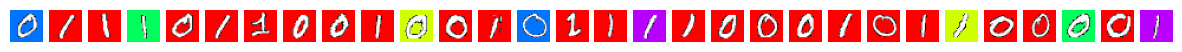

In [175]:
visualize(robust_trainset, 0, 30)
# It's the same training set as before, except each image is labeled a certain group partition.

In [180]:
group_balance = GroupBalanceBatchERM(model=model2,
                    group_partition=group_partition,
                    num_epochs=10,
                    trainset=training,
                    batch_size=64,
                    optimizer=SGD(model2.parameters(), lr=1e-3, momentum=0.9),
                    device=device,
                    verbose=True)
# The GroupBalanceBatchERM method will train the model in a way which samples equally from the group partitions.
# This basically makes it difficult for the model to rely on the background color, as we're making it correlated with nothing really.
# For example, in class 0, because we sample equally, red will appear as much as any other color, so the model doesn't gain anything from relying on the background color.
# As a result, it must rely on something else, like the shape of the number itself.

In [181]:
group_balance.train()
# As can be seen, the model takes longer to train, but in the end has higher accuracy.

Epoch 0:   2%|▉                                       | 17/751 [00:51<26:20,  2.15s/batch, accuracy=26.5625%, loss=1.6]

GB | Epoch 0 | Loss: 1.5843569040298462 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.5730985403060913 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5950294733047485 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.5809566974639893 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.6052073240280151 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.5927971601486206 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5973047018051147 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.5850346088409424 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.6001170873641968 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.5969504117965698 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.593357801437378 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.598044514656067 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5875005722045898 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5878993272781372 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5660655498504639 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.609197974205017 | Accuracy: 25.0%
GB | Epoch 0 | Loss: 1.585402488708496 | Accur

Epoch 0:   6%|██▌                                     | 47/751 [00:51<06:12,  1.89batch/s, accuracy=20.3125%, loss=1.6]

GB | Epoch 0 | Loss: 1.604185700416565 | Accuracy: 26.5625%
GB | Epoch 0 | Loss: 1.5885157585144043 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.6027719974517822 | Accuracy: 26.5625%
GB | Epoch 0 | Loss: 1.5867149829864502 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5485692024230957 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.575700283050537 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.6004486083984375 | Accuracy: 25.0%
GB | Epoch 0 | Loss: 1.5717376470565796 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.5588196516036987 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.570635199546814 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.5829181671142578 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.584099531173706 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.582218885421753 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.5649064779281616 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.5464380979537964 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.5518134832382202 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.5965317487716675 | Accu

Epoch 0:   8%|███▍                                      | 61/751 [00:51<03:51,  2.99batch/s, accuracy=37.5%, loss=1.55]

GB | Epoch 0 | Loss: 1.5291272401809692 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.5508817434310913 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.5757153034210205 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.5875320434570312 | Accuracy: 25.0%
GB | Epoch 0 | Loss: 1.589908480644226 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5605884790420532 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.5683268308639526 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.563688039779663 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.5548245906829834 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.5761098861694336 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.57066011428833 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.575114369392395 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.5713618993759155 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.568406105041504 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.5416301488876343 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.600242018699646 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.5664423704147339 | Accurac

Epoch 0:  12%|████▌                                  | 88/751 [00:51<01:42,  6.49batch/s, accuracy=29.6875%, loss=1.58]

GB | Epoch 0 | Loss: 1.5524616241455078 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.585842251777649 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.5400168895721436 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.5673121213912964 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5486141443252563 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.5920689105987549 | Accuracy: 25.0%
GB | Epoch 0 | Loss: 1.5651261806488037 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.5668643712997437 | Accuracy: 26.5625%
GB | Epoch 0 | Loss: 1.5678763389587402 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.5427173376083374 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.5572266578674316 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.5518330335617065 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.578167200088501 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.600588083267212 | Accuracy: 25.0%
GB | Epoch 0 | Loss: 1.5412132740020752 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5234025716781616 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5628050565719604 | Accura

Epoch 0:  17%|██████▊                                  | 124/751 [00:52<00:40, 15.54batch/s, accuracy=37.5%, loss=1.53]

GB | Epoch 0 | Loss: 1.5828309059143066 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.55996572971344 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.573473572731018 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5482661724090576 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.5153818130493164 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.601379632949829 | Accuracy: 25.0%
GB | Epoch 0 | Loss: 1.5182080268859863 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.5716049671173096 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.527152419090271 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5569967031478882 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.4993189573287964 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.5153120756149292 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.5426228046417236 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5371354818344116 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.5283303260803223 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.5060033798217773 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5555310249328613 |

Epoch 0:  21%|████████                              | 160/751 [00:52<00:18, 31.19batch/s, accuracy=32.8125%, loss=1.55]

GB | Epoch 0 | Loss: 1.5326226949691772 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.5353082418441772 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.5544596910476685 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.4968929290771484 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.539239764213562 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.512883186340332 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5431879758834839 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5697146654129028 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.5272012948989868 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.531378149986267 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.4845666885375977 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5333219766616821 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.5805292129516602 | Accuracy: 25.0%
GB | Epoch 0 | Loss: 1.5225622653961182 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.5736403465270996 | Accuracy: 26.5625%
GB | Epoch 0 | Loss: 1.4723055362701416 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.505982756614685 |

Epoch 0:  26%|██████████▏                            | 196/751 [00:52<00:10, 54.96batch/s, accuracy=34.375%, loss=1.52]

GB | Epoch 0 | Loss: 1.5532234907150269 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.5462075471878052 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5376229286193848 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5187088251113892 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.521989107131958 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.5354788303375244 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.5419870615005493 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.475698471069336 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.483847737312317 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.4860539436340332 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5082052946090698 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.5182479619979858 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.4208730459213257 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.486672282218933 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.499724268913269 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.5070348978042603 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.5646065473556519 | A

Epoch 0:  28%|███████████▉                              | 213/751 [00:52<00:07, 67.30batch/s, accuracy=25.0%, loss=1.6]

GB | Epoch 0 | Loss: 1.5220181941986084 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.4530823230743408 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.5434508323669434 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.576256513595581 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.567591667175293 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.5427172183990479 | Accuracy: 23.4375%
GB | Epoch 0 | Loss: 1.4921983480453491 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.5323596000671387 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.5786429643630981 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.5363441705703735 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5103031396865845 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.5300489664077759 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5659841299057007 | Accuracy: 25.0%
GB | Epoch 0 | Loss: 1.5023612976074219 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.5281208753585815 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.5871983766555786 | Accuracy: 23.4375%
GB | Epoch 0 | Loss: 1.4920005798339844 | Acc

Epoch 0:  33%|████████████▍                         | 246/751 [00:52<00:05, 93.19batch/s, accuracy=29.6875%, loss=1.57]

GB | Epoch 0 | Loss: 1.5409737825393677 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.5470408201217651 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.5908228158950806 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.4771597385406494 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.5735613107681274 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.4551042318344116 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.4970591068267822 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.4330304861068726 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.5024046897888184 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.471763014793396 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.5400331020355225 | Accuracy: 26.5625%
GB | Epoch 0 | Loss: 1.493850827217102 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5005778074264526 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.5185497999191284 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.4325125217437744 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.476138949394226 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.5519026517868

Epoch 0:  37%|█████████████▋                       | 278/751 [00:53<00:04, 112.54batch/s, accuracy=42.1875%, loss=1.43]

GB | Epoch 0 | Loss: 1.595677375793457 | Accuracy: 26.5625%
GB | Epoch 0 | Loss: 1.491087794303894 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.563401460647583 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.512284517288208 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.5434234142303467 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.4756361246109009 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.4466074705123901 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.4799935817718506 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.5298937559127808 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.4553762674331665 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.4980186223983765 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.5138373374938965 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.4207607507705688 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5025941133499146 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.522994041442871 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.3867474794387817 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.5376969575881

Epoch 0:  39%|██████████████▉                       | 294/751 [00:53<00:03, 118.28batch/s, accuracy=34.375%, loss=1.49]

GB | Epoch 0 | Loss: 1.4256768226623535 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.5452606678009033 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5082106590270996 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.5251880884170532 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.4550706148147583 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.5388158559799194 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.4808802604675293 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.4477314949035645 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.4867191314697266 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.4547581672668457 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5637887716293335 | Accuracy: 25.0%
GB | Epoch 0 | Loss: 1.4791269302368164 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.3673512935638428 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.5571335554122925 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.475355863571167 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.4523818492889404 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.469846248626709 

Epoch 0:  43%|███████████████▉                     | 324/751 [00:53<00:03, 119.17batch/s, accuracy=29.6875%, loss=1.56]

GB | Epoch 0 | Loss: 1.5526775121688843 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.5273529291152954 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.4845666885375977 | Accuracy: 26.5625%
GB | Epoch 0 | Loss: 1.6066242456436157 | Accuracy: 23.4375%
GB | Epoch 0 | Loss: 1.422301173210144 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.5096055269241333 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.4981472492218018 | Accuracy: 26.5625%
GB | Epoch 0 | Loss: 1.5504601001739502 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.4235303401947021 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.5060837268829346 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.4439847469329834 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.4963449239730835 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.5213956832885742 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.3743456602096558 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.580506443977356 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.5067088603973389 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.501609921455

Epoch 0:  45%|████████████████▋                    | 339/751 [00:53<00:03, 124.25batch/s, accuracy=48.4375%, loss=1.29]

GB | Epoch 0 | Loss: 1.5572823286056519 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.3521121740341187 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.5798516273498535 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.4198808670043945 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.4106309413909912 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.4172602891921997 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.4559075832366943 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.4211386442184448 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5301940441131592 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.5448170900344849 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.3857173919677734 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.5445616245269775 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.3717936277389526 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.3836325407028198 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.490492820739746 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.4120467901229858 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.4250622987747192

Epoch 0:  49%|██████████████████▌                   | 366/751 [00:53<00:03, 115.20batch/s, accuracy=34.375%, loss=1.44]

GB | Epoch 0 | Loss: 1.2947205305099487 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.3794405460357666 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.4371329545974731 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.4724555015563965 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.3809987306594849 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.3992691040039062 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.406901478767395 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.278491497039795 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.4543575048446655 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.393264889717102 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.3114615678787231 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.4312341213226318 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.459678053855896 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.427269697189331 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.4183098077774048 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.2090917825698853 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.5329316854476929 | Accur

Epoch 0:  50%|██████████████████▋                  | 379/751 [00:54<00:03, 106.20batch/s, accuracy=39.0625%, loss=1.38]

GB | Epoch 0 | Loss: 1.439086675643921 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.399374008178711 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.4395133256912231 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.5225955247879028 | Accuracy: 28.125%
GB | Epoch 0 | Loss: 1.4338232278823853 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.3581682443618774 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.4043333530426025 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.4343749284744263 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.439382791519165 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.4601751565933228 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.4370065927505493 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.3287729024887085 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.4666415452957153 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.3383612632751465 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.3332195281982422 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.3895010948181152 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.432396411895752 | 

Epoch 0:  54%|███████████████████▊                 | 402/751 [00:54<00:03, 105.30batch/s, accuracy=45.3125%, loss=1.38]

GB | Epoch 0 | Loss: 1.464820146560669 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.3681957721710205 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.3858798742294312 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.4704102277755737 | Accuracy: 31.25%
GB | Epoch 0 | Loss: 1.4343453645706177 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.4548763036727905 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.3449859619140625 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.4731380939483643 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.4570549726486206 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.3653501272201538 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.2755848169326782 | Accuracy: 59.375%
GB | Epoch 0 | Loss: 1.388954997062683 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.371798038482666 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.4815373420715332 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.3446711301803589 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.3535692691802979 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.272613525390625

Epoch 0:  57%|██████████████████████▏                | 427/751 [00:54<00:02, 114.12batch/s, accuracy=46.875%, loss=1.3]

GB | Epoch 0 | Loss: 1.428274393081665 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.2763185501098633 | Accuracy: 62.5%
GB | Epoch 0 | Loss: 1.2436519861221313 | Accuracy: 64.0625%
GB | Epoch 0 | Loss: 1.4107182025909424 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.314914345741272 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.338207483291626 | Accuracy: 57.8125%
GB | Epoch 0 | Loss: 1.3671278953552246 | Accuracy: 56.25%
GB | Epoch 0 | Loss: 1.3196336030960083 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.484041690826416 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.3630766868591309 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.37759530544281 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.3241089582443237 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.2866708040237427 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.5863707065582275 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.3886651992797852 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.3204529285430908 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.3935338258743286 

Epoch 0:  60%|██████████████████████▉               | 454/751 [00:54<00:02, 121.62batch/s, accuracy=51.5625%, loss=1.3]

GB | Epoch 0 | Loss: 1.2609083652496338 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.4605904817581177 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5365146398544312 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.4304529428482056 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5044667720794678 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.245438575744629 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.3786934614181519 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.3071558475494385 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.2890013456344604 | Accuracy: 53.125%
GB | Epoch 0 | Loss: 1.3164728879928589 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.3060691356658936 | Accuracy: 53.125%
GB | Epoch 0 | Loss: 1.3768110275268555 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.512437105178833 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.3573112487792969 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.2514728307724 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.4477062225341797 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.36352705955505

Epoch 0:  64%|████████████████████████▎             | 480/751 [00:54<00:02, 125.21batch/s, accuracy=46.875%, loss=1.31]

GB | Epoch 0 | Loss: 1.3710741996765137 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.4962362051010132 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.3684232234954834 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.4106457233428955 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.360198736190796 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.390690565109253 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.4939913749694824 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.2600642442703247 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.1960481405258179 | Accuracy: 56.25%
GB | Epoch 0 | Loss: 1.4123986959457397 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.4459598064422607 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.3736339807510376 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.2393337488174438 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.1723445653915405 | Accuracy: 62.5%
GB | Epoch 0 | Loss: 1.4854263067245483 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.4766552448272705 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.2645151615142822 

Epoch 0:  66%|████████████████████████▉             | 493/751 [00:54<00:02, 113.59batch/s, accuracy=40.625%, loss=1.41]

GB | Epoch 0 | Loss: 1.3666843175888062 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.2043836116790771 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.4296494722366333 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.376342535018921 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.2486876249313354 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.37411367893219 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.3878036737442017 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.3266856670379639 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.1778422594070435 | Accuracy: 53.125%
GB | Epoch 0 | Loss: 1.4211363792419434 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.4192677736282349 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.2593796253204346 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.3153901100158691 | Accuracy: 53.125%
GB | Epoch 0 | Loss: 1.3968884944915771 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.4398783445358276 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.3906073570251465 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.397846579551696

Epoch 0:  70%|█████████████████████████▋           | 522/751 [00:55<00:01, 126.89batch/s, accuracy=51.5625%, loss=1.27]

GB | Epoch 0 | Loss: 1.4085724353790283 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.5154027938842773 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.2833760976791382 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.3572158813476562 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.2948752641677856 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.3334705829620361 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.2321189641952515 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.289300799369812 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.3944454193115234 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.2361254692077637 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.3792304992675781 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.3978705406188965 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.2283358573913574 | Accuracy: 53.125%
GB | Epoch 0 | Loss: 1.2966639995574951 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.493688702583313 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.4527442455291748 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.30857563018798

Epoch 0:  73%|███████████████████████████▏         | 551/751 [00:55<00:01, 131.87batch/s, accuracy=51.5625%, loss=1.26]

GB | Epoch 0 | Loss: 1.273085594177246 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.3794422149658203 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.3075895309448242 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.2820332050323486 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.3700288534164429 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.2286475896835327 | Accuracy: 56.25%
GB | Epoch 0 | Loss: 1.3625869750976562 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.3512396812438965 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.451172947883606 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.1522682905197144 | Accuracy: 59.375%
GB | Epoch 0 | Loss: 1.4457889795303345 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.4585767984390259 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.2254401445388794 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.333268642425537 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.2284365892410278 | Accuracy: 53.125%
GB | Epoch 0 | Loss: 1.569922924041748 | Accuracy: 34.375%
GB | Epoch 0 | Loss: 1.317164421081543 | A

Epoch 0:  75%|████████████████████████████▋         | 567/751 [00:55<00:01, 137.02batch/s, accuracy=40.625%, loss=1.44]

GB | Epoch 0 | Loss: 1.4504797458648682 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.3522018194198608 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.4348993301391602 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.2132142782211304 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.308107614517212 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.3985081911087036 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.316956639289856 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.5883427858352661 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.4093440771102905 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.2434264421463013 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.3077646493911743 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.2339909076690674 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.4544645547866821 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.3169621229171753 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.312925100326538 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.3053337335586548 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.36328136920928

Epoch 0:  79%|█████████████████████████████▍       | 597/751 [00:55<00:01, 142.25batch/s, accuracy=45.3125%, loss=1.26]

GB | Epoch 0 | Loss: 1.4395313262939453 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.3350576162338257 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.214542031288147 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.3042737245559692 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.4070956707000732 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.4020826816558838 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.4886195659637451 | Accuracy: 32.8125%
GB | Epoch 0 | Loss: 1.2744883298873901 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.5335586071014404 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.3407373428344727 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.1746445894241333 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.2888168096542358 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.2882914543151855 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.3453795909881592 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.3312761783599854 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.2709041833877563 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.4651958942

Epoch 0:  84%|██████████████████████████████▉      | 628/751 [00:55<00:00, 145.60batch/s, accuracy=51.5625%, loss=1.22]

GB | Epoch 0 | Loss: 1.2591866254806519 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.2624800205230713 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.4492963552474976 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.3171322345733643 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.2277274131774902 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.4170289039611816 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.1924444437026978 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.3409985303878784 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.301926851272583 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.3071640729904175 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.2261916399002075 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.4818527698516846 | Accuracy: 29.6875%
GB | Epoch 0 | Loss: 1.2737427949905396 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.387873649597168 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.17547607421875 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.350696325302124 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.206834316253662 | Ac

Epoch 0:  86%|████████████████████████████████▌     | 643/751 [00:56<00:00, 145.09batch/s, accuracy=51.5625%, loss=1.2]

GB | Epoch 0 | Loss: 1.2586220502853394 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.103997826576233 | Accuracy: 60.9375%
GB | Epoch 0 | Loss: 1.2997792959213257 | Accuracy: 56.25%
GB | Epoch 0 | Loss: 1.1831763982772827 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.2952364683151245 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.264874815940857 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.4109762907028198 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.2115039825439453 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.2995446920394897 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.4415096044540405 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.3011027574539185 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.3124290704727173 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.2895174026489258 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.4026970863342285 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.2567306756973267 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.3003875017166138 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.4401861429214478 | A

Epoch 0:  89%|██████████████████████████████████    | 672/751 [00:56<00:00, 130.21batch/s, accuracy=40.625%, loss=1.35]

GB | Epoch 0 | Loss: 1.1953833103179932 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.2659403085708618 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.3960908651351929 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.2309671640396118 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.2606531381607056 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.1733942031860352 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.153130292892456 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.3618357181549072 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.493538737297058 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.2141221761703491 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.376387596130371 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.1659810543060303 | Accuracy: 60.9375%
GB | Epoch 0 | Loss: 1.085493564605713 | Accuracy: 59.375%
GB | Epoch 0 | Loss: 1.2386881113052368 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.267479658126831 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.271957516670227 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.3343490362167358 | Accu

Epoch 0:  93%|████████████████████████████████████▎  | 700/751 [00:56<00:00, 126.69batch/s, accuracy=43.75%, loss=1.28]

GB | Epoch 0 | Loss: 1.1923847198486328 | Accuracy: 59.375%
GB | Epoch 0 | Loss: 1.4046144485473633 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.3056093454360962 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.3258229494094849 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.3412399291992188 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.279582142829895 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.3636268377304077 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.2482024431228638 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.2445087432861328 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.2585387229919434 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.3792415857315063 | Accuracy: 39.0625%
GB | Epoch 0 | Loss: 1.406805396080017 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.3784443140029907 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.2185173034667969 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.3566045761108398 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.217549204826355 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.3767502307891846 | Acc

Epoch 0:  97%|███████████████████████████████████▉ | 730/751 [00:56<00:00, 136.59batch/s, accuracy=48.4375%, loss=1.29]

GB | Epoch 0 | Loss: 1.2218581438064575 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.3754634857177734 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.4433109760284424 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.326651930809021 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.1721279621124268 | Accuracy: 57.8125%
GB | Epoch 0 | Loss: 1.359215497970581 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.1755766868591309 | Accuracy: 50.0%
GB | Epoch 0 | Loss: 1.2932188510894775 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.2681338787078857 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.3181626796722412 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.3272212743759155 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.305168628692627 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.2896242141723633 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.2506370544433594 | Accuracy: 48.4375%
GB | Epoch 0 | Loss: 1.3466442823410034 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.3545945882797241 | Accuracy: 37.5%
GB | Epoch 0 | Loss: 1.2947462797164917 | A

Epoch 0:  99%|██████████████████████████████████████▋| 744/751 [00:56<00:00, 130.84batch/s, accuracy=50.0%, loss=0.971]

GB | Epoch 0 | Loss: 1.252980351448059 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.2802727222442627 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.1646932363510132 | Accuracy: 57.8125%
GB | Epoch 0 | Loss: 1.3395146131515503 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.2008183002471924 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.2321070432662964 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.2736217975616455 | Accuracy: 46.875%
GB | Epoch 0 | Loss: 1.2313185930252075 | Accuracy: 51.5625%
GB | Epoch 0 | Loss: 1.2986918687820435 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.1045514345169067 | Accuracy: 54.6875%
GB | Epoch 0 | Loss: 1.4661147594451904 | Accuracy: 35.9375%
GB | Epoch 0 | Loss: 1.1396538019180298 | Accuracy: 53.125%
GB | Epoch 0 | Loss: 1.3951530456542969 | Accuracy: 43.75%
GB | Epoch 0 | Loss: 1.288305640220642 | Accuracy: 42.1875%
GB | Epoch 0 | Loss: 1.3134050369262695 | Accuracy: 40.625%
GB | Epoch 0 | Loss: 1.1982418298721313 | Accuracy: 45.3125%
GB | Epoch 0 | Loss: 1.2995629310

Epoch 1:   2%|▊                                      | 16/751 [00:47<26:08,  2.13s/batch, accuracy=42.1875%, loss=1.35]

GB | Epoch 1 | Loss: 1.1502457857131958 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.2917633056640625 | Accuracy: 43.75%
GB | Epoch 1 | Loss: 1.2135165929794312 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.2560476064682007 | Accuracy: 40.625%
GB | Epoch 1 | Loss: 1.4038939476013184 | Accuracy: 42.1875%
GB | Epoch 1 | Loss: 1.5595364570617676 | Accuracy: 35.9375%
GB | Epoch 1 | Loss: 1.0867046117782593 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.2989610433578491 | Accuracy: 43.75%
GB | Epoch 1 | Loss: 1.303419589996338 | Accuracy: 45.3125%
GB | Epoch 1 | Loss: 1.3459982872009277 | Accuracy: 42.1875%
GB | Epoch 1 | Loss: 1.284097671508789 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.1230496168136597 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 1.1692590713500977 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.279714822769165 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.2920032739639282 | Accuracy: 42.1875%
GB | Epoch 1 | Loss: 1.3476014137268066 | Accuracy: 37.5%
GB | Epoch 1 | Loss: 1.1624592542648315 | Ac

Epoch 1:   6%|██▋                                       | 47/751 [00:48<05:41,  2.06batch/s, accuracy=50.0%, loss=1.27]

GB | Epoch 1 | Loss: 1.3496012687683105 | Accuracy: 42.1875%
GB | Epoch 1 | Loss: 1.1388474702835083 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.0827924013137817 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.1211700439453125 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.198603868484497 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.31266450881958 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.2071348428726196 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.241795539855957 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.3492757081985474 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.244003176689148 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.1984268426895142 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.4462894201278687 | Accuracy: 35.9375%
GB | Epoch 1 | Loss: 1.191053867340088 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.1525065898895264 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.3218204975128174 | Accuracy: 40.625%
GB | Epoch 1 | Loss: 1.2993488311767578 | Accuracy: 40.625%
GB | Epoch 1 | Loss: 1.3291243314743042 

Epoch 1:  11%|████▎                                  | 83/751 [00:48<01:57,  5.70batch/s, accuracy=57.8125%, loss=1.25]

GB | Epoch 1 | Loss: 1.2682127952575684 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.3045862913131714 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.3654128313064575 | Accuracy: 43.75%
GB | Epoch 1 | Loss: 1.4311624765396118 | Accuracy: 43.75%
GB | Epoch 1 | Loss: 1.2753487825393677 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.2838668823242188 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.2317554950714111 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.365865707397461 | Accuracy: 43.75%
GB | Epoch 1 | Loss: 1.2667051553726196 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.2578123807907104 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.2873666286468506 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.2914619445800781 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.333432912826538 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.3575785160064697 | Accuracy: 39.0625%
GB | Epoch 1 | Loss: 1.3207640647888184 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.3608689308166504 | Accuracy: 40.625%
GB | Epoch 1 | Loss: 1.1583151817321777 | Accuracy: 

Epoch 1:  16%|██████                                | 119/751 [00:48<00:49, 12.68batch/s, accuracy=54.6875%, loss=1.15]

GB | Epoch 1 | Loss: 1.1875032186508179 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.2252813577651978 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.0754706859588623 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 1.3870927095413208 | Accuracy: 39.0625%
GB | Epoch 1 | Loss: 1.1959803104400635 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.2907336950302124 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.3189698457717896 | Accuracy: 43.75%
GB | Epoch 1 | Loss: 1.2488681077957153 | Accuracy: 43.75%
GB | Epoch 1 | Loss: 1.3161132335662842 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.1838866472244263 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.1779730319976807 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.1551859378814697 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.1725317239761353 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.280989646911621 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.327138900756836 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.2029837369918823 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.324510097503662 | A

Epoch 1:  21%|████████                               | 155/751 [00:48<00:23, 25.24batch/s, accuracy=57.8125%, loss=1.1]

GB | Epoch 1 | Loss: 1.219626545906067 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.2398185729980469 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.1783994436264038 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.3863112926483154 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.3069829940795898 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.34922456741333 | Accuracy: 40.625%
GB | Epoch 1 | Loss: 1.147818684577942 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.000442624092102 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.1417205333709717 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.2223329544067383 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.2325918674468994 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.2983481884002686 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.0535224676132202 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 1.3750673532485962 | Accuracy: 40.625%
GB | Epoch 1 | Loss: 1.2717751264572144 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.1833932399749756 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.1294643878936768 | Accur

Epoch 1:  23%|████████▉                              | 173/751 [00:48<00:16, 34.24batch/s, accuracy=53.125%, loss=1.17]

GB | Epoch 1 | Loss: 1.0961823463439941 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.3043760061264038 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.4341458082199097 | Accuracy: 43.75%
GB | Epoch 1 | Loss: 1.1429455280303955 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.302782654762268 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.194677710533142 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.2287042140960693 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.268735408782959 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.2612411975860596 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.2404292821884155 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.3172987699508667 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.1612805128097534 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.111449122428894 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.1659163236618042 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.3767271041870117 | Accuracy: 42.1875%
GB | Epoch 1 | Loss: 1.363883376121521 | Accuracy: 42.1875%
GB | Epoch 1 | Loss: 1.3121891021728516

Epoch 1:  28%|██████████▌                           | 209/751 [00:49<00:09, 58.29batch/s, accuracy=45.3125%, loss=1.15]

GB | Epoch 1 | Loss: 1.3526540994644165 | Accuracy: 45.3125%
GB | Epoch 1 | Loss: 1.0825867652893066 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 1.366105556488037 | Accuracy: 42.1875%
GB | Epoch 1 | Loss: 1.3206714391708374 | Accuracy: 45.3125%
GB | Epoch 1 | Loss: 1.130567193031311 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.197688102722168 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.1966345310211182 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.2326164245605469 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.0075353384017944 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 1.2141547203063965 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.3327274322509766 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.2898070812225342 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.264122486114502 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.2984477281570435 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.3227821588516235 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.2138975858688354 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.2555261850357056 | 

Epoch 1:  30%|████████████                            | 226/751 [00:49<00:07, 68.25batch/s, accuracy=46.875%, loss=1.3]

GB | Epoch 1 | Loss: 1.1498470306396484 | Accuracy: 45.3125%
GB | Epoch 1 | Loss: 1.202707290649414 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.1697344779968262 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.1884241104125977 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.3018380403518677 | Accuracy: 45.3125%
GB | Epoch 1 | Loss: 1.137237548828125 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.2360278367996216 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.2978971004486084 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.1334128379821777 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.121158480644226 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.173596739768982 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.2772771120071411 | Accuracy: 43.75%
GB | Epoch 1 | Loss: 1.357438564300537 | Accuracy: 37.5%
GB | Epoch 1 | Loss: 1.156427025794983 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.1142154932022095 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.1040747165679932 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.2849403619766235 | Accu

Epoch 1:  34%|██████████████                           | 257/751 [00:49<00:05, 87.93batch/s, accuracy=50.0%, loss=1.15]

GB | Epoch 1 | Loss: 1.2986018657684326 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.2174824476242065 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.2397090196609497 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.1952418088912964 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.2232298851013184 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.2993379831314087 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.25879967212677 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.2875149250030518 | Accuracy: 45.3125%
GB | Epoch 1 | Loss: 1.1617591381072998 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.0280766487121582 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 1.179471731185913 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.3215299844741821 | Accuracy: 39.0625%
GB | Epoch 1 | Loss: 1.023321270942688 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 1.2631471157073975 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.324426293373108 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.081814169883728 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 1.1088241338729858 |

Epoch 1:  38%|██████████████▌                       | 288/751 [00:49<00:04, 108.73batch/s, accuracy=53.125%, loss=1.17]

GB | Epoch 1 | Loss: 1.228653073310852 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 0.9514783620834351 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 1.0824130773544312 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.3185397386550903 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.2597734928131104 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.209834337234497 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.0581203699111938 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.3508739471435547 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.23354971408844 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.1925923824310303 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.150269865989685 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.249560832977295 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.2495754957199097 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.1248645782470703 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.244507074356079 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.3911267518997192 | Accuracy: 43.75%
GB | Epoch 1 | Loss: 1.217186450958252 | A

Epoch 1:  40%|██████████████▉                      | 303/751 [00:49<00:03, 115.79batch/s, accuracy=57.8125%, loss=1.14]

GB | Epoch 1 | Loss: 1.1720138788223267 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.0428003072738647 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 1.2442671060562134 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.0875442028045654 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.0157314538955688 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 1.1343752145767212 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.0123199224472046 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.093025803565979 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.121293544769287 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.013824701309204 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.3448933362960815 | Accuracy: 43.75%
GB | Epoch 1 | Loss: 1.1142382621765137 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.2678873538970947 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.183163046836853 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.1027045249938965 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 1.2481756210327148 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.1059956550598145 | Acc

Epoch 1:  44%|████████████████▍                    | 333/751 [00:49<00:03, 122.94batch/s, accuracy=48.4375%, loss=1.26]

GB | Epoch 1 | Loss: 1.135932207107544 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 0.989788293838501 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 1.1564407348632812 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.1564444303512573 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.166853904724121 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.2308741807937622 | Accuracy: 42.1875%
GB | Epoch 1 | Loss: 1.0903152227401733 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.1199536323547363 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.1587003469467163 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.2988710403442383 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.2018998861312866 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.1424790620803833 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 0.9169612526893616 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 1.076712727546692 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.074379563331604 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.0950814485549927 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.2475982904434204

Epoch 1:  48%|██████████████████▎                   | 361/751 [00:50<00:03, 124.84batch/s, accuracy=53.125%, loss=1.19]

GB | Epoch 1 | Loss: 1.262980341911316 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.2344542741775513 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.243654727935791 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.0754985809326172 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.2244813442230225 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.2380448579788208 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.1301417350769043 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.1640374660491943 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.2076817750930786 | Accuracy: 45.3125%
GB | Epoch 1 | Loss: 1.1169627904891968 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.1418399810791016 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.1311109066009521 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.1285561323165894 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.3147172927856445 | Accuracy: 45.3125%
GB | Epoch 1 | Loss: 1.0906590223312378 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.1267160177230835 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 1.0723800659179

Epoch 1:  50%|██████████████████▉                   | 375/751 [00:50<00:02, 126.28batch/s, accuracy=59.375%, loss=1.07]

GB | Epoch 1 | Loss: 1.1341078281402588 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.1644960641860962 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.1267549991607666 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.047293782234192 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.2128996849060059 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.2970943450927734 | Accuracy: 39.0625%
GB | Epoch 1 | Loss: 1.22349214553833 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.0488371849060059 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.059882402420044 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 1.0973058938980103 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 1.0303847789764404 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 1.0045112371444702 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 1.0192006826400757 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.178236484527588 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.1919077634811401 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.209741234779358 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.1865959167480469 |

Epoch 1:  54%|█████████████████████▌                  | 405/751 [00:50<00:02, 133.83batch/s, accuracy=50.0%, loss=1.19]

GB | Epoch 1 | Loss: 1.0701390504837036 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.059040904045105 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.215364933013916 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.0515891313552856 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.0551913976669312 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.1193591356277466 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.0487828254699707 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 1.1197264194488525 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.060430884361267 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.167183518409729 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.112170696258545 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.145142912864685 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 0.915880560874939 | Accuracy: 73.4375%
GB | Epoch 1 | Loss: 1.052607536315918 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 1.067454218864441 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 1.079035997390747 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.2055389881134033 | Accu

Epoch 1:  58%|█████████████████████▎               | 433/751 [00:50<00:02, 132.64batch/s, accuracy=64.0625%, loss=1.07]

GB | Epoch 1 | Loss: 1.1438844203948975 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.1186823844909668 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.0760632753372192 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.1330726146697998 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.0730036497116089 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.00849187374115 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 1.1300400495529175 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.0368648767471313 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 1.0639363527297974 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 0.9519417881965637 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.994803786277771 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 1.097677230834961 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 0.9197171330451965 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 1.0193157196044922 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.1574161052703857 | Accuracy: 50.0%
GB | Epoch 1 | Loss: 1.0854082107543945 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.2200815677642822 

Epoch 1:  61%|██████████████████████▋              | 461/751 [00:50<00:02, 133.25batch/s, accuracy=64.0625%, loss=1.01]

GB | Epoch 1 | Loss: 1.139021635055542 | Accuracy: 46.875%
GB | Epoch 1 | Loss: 1.1052401065826416 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.1366325616836548 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 0.9882684946060181 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.0312470197677612 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.049675464630127 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 0.9178648591041565 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 0.8472934365272522 | Accuracy: 71.875%
GB | Epoch 1 | Loss: 1.0808039903640747 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 0.9799783229827881 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 0.9945557713508606 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.0295650959014893 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 0.974036693572998 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.2305103540420532 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.065985083580017 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.0785870552062988 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.24056231975555

Epoch 1:  65%|████████████████████████▊             | 490/751 [00:51<00:01, 136.58batch/s, accuracy=65.625%, loss=1.06]

GB | Epoch 1 | Loss: 1.0086889266967773 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.9788020849227905 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 0.9426589012145996 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.9647597670555115 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 0.9783719182014465 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.169476866722107 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.1910021305084229 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 0.9084619879722595 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 1.102007508277893 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.0815801620483398 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.028732419013977 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.0396915674209595 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.0509381294250488 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.0623867511749268 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.8934181928634644 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 1.1238261461257935 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 1.0679997205734253 | Ac

Epoch 1:  67%|████████████████████████▉            | 505/751 [00:51<00:01, 137.57batch/s, accuracy=51.5625%, loss=1.08]

GB | Epoch 1 | Loss: 1.0594100952148438 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 1.1232348680496216 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 0.9586361646652222 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.8882451057434082 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 0.9314494132995605 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.9277058243751526 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 1.1543253660202026 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 0.9432311058044434 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 1.0337893962860107 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 0.8030437231063843 | Accuracy: 75.0%
GB | Epoch 1 | Loss: 0.9250112175941467 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.0615953207015991 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 0.9692615270614624 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.0147404670715332 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.089644193649292 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 1.10061514377594 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 0.8931843638420105 | A

Epoch 1:  71%|███████████████████████████▋           | 532/751 [00:51<00:01, 125.60batch/s, accuracy=62.5%, loss=0.928]

GB | Epoch 1 | Loss: 1.0796841382980347 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 0.88571697473526 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 1.0099525451660156 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.0907442569732666 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.0098952054977417 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 1.0196961164474487 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.1627094745635986 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 0.9198203086853027 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.9458749890327454 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.9934576153755188 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 0.9595168232917786 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.1231790781021118 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 0.8361827731132507 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 1.057611346244812 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.026695966720581 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.8759469389915466 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.89513999223709

Epoch 1:  74%|█████████████████████████████          | 559/751 [00:51<00:01, 125.12batch/s, accuracy=56.25%, loss=1.03]

GB | Epoch 1 | Loss: 0.9279207587242126 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.8486284017562866 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 1.0331803560256958 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.9931213855743408 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.0905485153198242 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 0.9615184664726257 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 0.9816741943359375 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 0.913079559803009 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.8994922041893005 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 1.0902082920074463 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 1.0109158754348755 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 0.8450800776481628 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.9970128536224365 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 1.1605584621429443 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 1.018110752105713 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 0.797257125377655 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 1.1066591739654

Epoch 1:  76%|███████████████████████████▌        | 574/751 [00:51<00:01, 131.01batch/s, accuracy=64.0625%, loss=0.979]

GB | Epoch 1 | Loss: 1.030882716178894 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 0.8724698424339294 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 1.0244216918945312 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.0611999034881592 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 0.8363127112388611 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.8188799619674683 | Accuracy: 76.5625%
GB | Epoch 1 | Loss: 0.9808323979377747 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.8826205134391785 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 0.869385302066803 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 0.9397029280662537 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 1.0269063711166382 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 0.9264973998069763 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.0498294830322266 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 0.847365140914917 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.9194696545600891 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 0.9011459350585938 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.9307082295417786 | A

Epoch 1:  80%|█████████████████████████████▋       | 602/751 [00:52<00:01, 128.58batch/s, accuracy=70.3125%, loss=0.91]

GB | Epoch 1 | Loss: 0.9789635539054871 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.9849059581756592 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 0.9513710737228394 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 1.063581943511963 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.9420849084854126 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 0.879491925239563 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 1.1116535663604736 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 0.8863274455070496 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 1.035856008529663 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 0.8319445252418518 | Accuracy: 73.4375%
GB | Epoch 1 | Loss: 0.8775314092636108 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 0.8696283102035522 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 0.9712875485420227 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.7444468140602112 | Accuracy: 73.4375%
GB | Epoch 1 | Loss: 0.7920452952384949 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 0.9317457675933838 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 0.9140254259109497 

Epoch 1:  84%|████████████████████████████████▋      | 629/751 [00:52<00:00, 130.39batch/s, accuracy=62.5%, loss=0.969]

GB | Epoch 1 | Loss: 0.91019207239151 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 0.9698480367660522 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.9938847422599792 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 0.8518435955047607 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 0.9490283727645874 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 1.0696147680282593 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 0.8534114956855774 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.8943030834197998 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.8919637203216553 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 0.8944775462150574 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 1.018589973449707 | Accuracy: 48.4375%
GB | Epoch 1 | Loss: 1.0894657373428345 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.2308012247085571 | Accuracy: 51.5625%
GB | Epoch 1 | Loss: 1.004594087600708 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 0.8774747252464294 | Accuracy: 75.0%
GB | Epoch 1 | Loss: 1.0144158601760864 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 1.0019843578338623 | 

Epoch 1:  88%|███████████████████████████████▌    | 659/751 [00:52<00:00, 134.75batch/s, accuracy=64.0625%, loss=0.829]

GB | Epoch 1 | Loss: 0.9689165353775024 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.8437081575393677 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.8707687854766846 | Accuracy: 71.875%
GB | Epoch 1 | Loss: 1.0167793035507202 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.8962550163269043 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.8552111983299255 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 0.9350801110267639 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.9250096082687378 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 0.7382900714874268 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 0.9345922470092773 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.7978547215461731 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 1.0271176099777222 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 0.8342841863632202 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.8974888920783997 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.8091191053390503 | Accuracy: 71.875%
GB | Epoch 1 | Loss: 0.9790247678756714 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 0.8881460428237915 | Acc

Epoch 1:  90%|████████████████████████████████▎   | 674/751 [00:52<00:00, 138.78batch/s, accuracy=70.3125%, loss=0.888]

GB | Epoch 1 | Loss: 0.8292942047119141 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.8941118717193604 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 0.8275766372680664 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.8056633472442627 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.9726330041885376 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 0.9398621916770935 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.9528306126594543 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 0.8385003805160522 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 1.045763373374939 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 1.142704725265503 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 0.9054612517356873 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 1.0680394172668457 | Accuracy: 53.125%
GB | Epoch 1 | Loss: 0.9462960362434387 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 0.906337320804596 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 0.9704036712646484 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 0.9205004572868347 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 0.88908982276

Epoch 1:  94%|███████████████████████████████████▌  | 704/751 [00:52<00:00, 140.04batch/s, accuracy=64.0625%, loss=0.8]

GB | Epoch 1 | Loss: 0.8636081218719482 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 1.002457857131958 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 0.9406997561454773 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.8145540356636047 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 0.752693235874176 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 0.9150165319442749 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 0.8372877836227417 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 0.8674829006195068 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 0.6976522207260132 | Accuracy: 75.0%
GB | Epoch 1 | Loss: 0.9950775504112244 | Accuracy: 59.375%
GB | Epoch 1 | Loss: 1.0379221439361572 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 0.7958168387413025 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 0.7083490490913391 | Accuracy: 71.875%
GB | Epoch 1 | Loss: 0.8337149620056152 | Accuracy: 71.875%
GB | Epoch 1 | Loss: 1.0050523281097412 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 1.0458388328552246 | Accuracy: 62.5%
GB | Epoch 1 | Loss: 0.8465360403060913 |

Epoch 1:  98%|████████████████████████████████████ | 733/751 [00:52<00:00, 131.91batch/s, accuracy=60.9375%, loss=0.95]

GB | Epoch 1 | Loss: 0.8506364226341248 | Accuracy: 67.1875%
GB | Epoch 1 | Loss: 1.0772364139556885 | Accuracy: 54.6875%
GB | Epoch 1 | Loss: 0.866165280342102 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.8973589539527893 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 0.662369966506958 | Accuracy: 75.0%
GB | Epoch 1 | Loss: 1.099802851676941 | Accuracy: 57.8125%
GB | Epoch 1 | Loss: 0.8010250329971313 | Accuracy: 75.0%
GB | Epoch 1 | Loss: 0.9241447448730469 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.7629094123840332 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 0.7722881436347961 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 0.866672158241272 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.9053382277488708 | Accuracy: 56.25%
GB | Epoch 1 | Loss: 0.8886191844940186 | Accuracy: 68.75%
GB | Epoch 1 | Loss: 0.7053885459899902 | Accuracy: 71.875%
GB | Epoch 1 | Loss: 0.7143336534500122 | Accuracy: 76.5625%
GB | Epoch 1 | Loss: 0.9397100210189819 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 0.7519965171813965 | Acc

Epoch 1: 100%|███████████████████████████████████████▉| 750/751 [00:53<00:00, 141.25batch/s, accuracy=75.0%, loss=1.08]

GB | Epoch 1 | Loss: 0.9496460556983948 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 0.6610429883003235 | Accuracy: 73.4375%
GB | Epoch 1 | Loss: 0.7601578831672668 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 0.8260537981987 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 0.9478654265403748 | Accuracy: 60.9375%
GB | Epoch 1 | Loss: 0.6775850653648376 | Accuracy: 81.25%
GB | Epoch 1 | Loss: 0.6783771514892578 | Accuracy: 76.5625%
GB | Epoch 1 | Loss: 0.8451340198516846 | Accuracy: 75.0%
GB | Epoch 1 | Loss: 0.7585448622703552 | Accuracy: 70.3125%
GB | Epoch 1 | Loss: 0.821760892868042 | Accuracy: 71.875%
GB | Epoch 1 | Loss: 0.7057585716247559 | Accuracy: 73.4375%
GB | Epoch 1 | Loss: 0.9464709162712097 | Accuracy: 64.0625%
GB | Epoch 1 | Loss: 0.8920772671699524 | Accuracy: 65.625%
GB | Epoch 1 | Loss: 0.6276501417160034 | Accuracy: 73.4375%
GB | Epoch 1 | Loss: 1.0773711204528809 | Accuracy: 75.0%


Epoch 2:   2%|▋                                     | 14/751 [00:53<33:35,  2.74s/batch, accuracy=60.9375%, loss=0.817]

GB | Epoch 2 | Loss: 0.8491854071617126 | Accuracy: 68.75%
GB | Epoch 2 | Loss: 0.8746955990791321 | Accuracy: 65.625%
GB | Epoch 2 | Loss: 0.8609186410903931 | Accuracy: 67.1875%
GB | Epoch 2 | Loss: 0.9111019968986511 | Accuracy: 67.1875%
GB | Epoch 2 | Loss: 0.9860479831695557 | Accuracy: 62.5%
GB | Epoch 2 | Loss: 0.9601110219955444 | Accuracy: 59.375%
GB | Epoch 2 | Loss: 0.6854034662246704 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.7490733861923218 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.7296232581138611 | Accuracy: 71.875%
GB | Epoch 2 | Loss: 0.7823097109794617 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.9593450427055359 | Accuracy: 65.625%
GB | Epoch 2 | Loss: 0.7435063719749451 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.7417218089103699 | Accuracy: 67.1875%
GB | Epoch 2 | Loss: 1.0314661264419556 | Accuracy: 64.0625%
GB | Epoch 2 | Loss: 1.0434318780899048 | Accuracy: 53.125%
GB | Epoch 2 | Loss: 0.7471355199813843 | Accuracy: 70.3125%
GB | Epoch 2 | Loss: 0.8327850699424744 

Epoch 2:   6%|██▏                                   | 42/751 [00:53<07:11,  1.64batch/s, accuracy=79.6875%, loss=0.709]

GB | Epoch 2 | Loss: 0.8168835639953613 | Accuracy: 60.9375%
GB | Epoch 2 | Loss: 0.8044261932373047 | Accuracy: 67.1875%
GB | Epoch 2 | Loss: 0.8876973986625671 | Accuracy: 71.875%
GB | Epoch 2 | Loss: 0.7955312728881836 | Accuracy: 71.875%
GB | Epoch 2 | Loss: 0.7706373333930969 | Accuracy: 70.3125%
GB | Epoch 2 | Loss: 0.8462496399879456 | Accuracy: 68.75%
GB | Epoch 2 | Loss: 0.6760952472686768 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.7975839972496033 | Accuracy: 64.0625%
GB | Epoch 2 | Loss: 0.8095296025276184 | Accuracy: 68.75%
GB | Epoch 2 | Loss: 0.9002691507339478 | Accuracy: 65.625%
GB | Epoch 2 | Loss: 0.6055630445480347 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.8779449462890625 | Accuracy: 60.9375%
GB | Epoch 2 | Loss: 0.7784541845321655 | Accuracy: 67.1875%
GB | Epoch 2 | Loss: 0.8635658621788025 | Accuracy: 59.375%
GB | Epoch 2 | Loss: 0.7805002927780151 | Accuracy: 64.0625%
GB | Epoch 2 | Loss: 0.8076528310775757 | Accuracy: 64.0625%
GB | Epoch 2 | Loss: 0.893500447273

Epoch 2:   7%|██▊                                   | 55/751 [00:53<04:25,  2.62batch/s, accuracy=79.6875%, loss=0.607]

GB | Epoch 2 | Loss: 0.6355504989624023 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.6905621886253357 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.6471894979476929 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.7764334678649902 | Accuracy: 70.3125%
GB | Epoch 2 | Loss: 0.7055342197418213 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.8615955710411072 | Accuracy: 70.3125%
GB | Epoch 2 | Loss: 0.7431316375732422 | Accuracy: 68.75%
GB | Epoch 2 | Loss: 0.7285376787185669 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.6036146879196167 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.6081884503364563 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.7557963728904724 | Accuracy: 67.1875%
GB | Epoch 2 | Loss: 0.9333229064941406 | Accuracy: 67.1875%
GB | Epoch 2 | Loss: 0.8770778775215149 | Accuracy: 67.1875%
GB | Epoch 2 | Loss: 0.7716694474220276 | Accuracy: 70.3125%
GB | Epoch 2 | Loss: 0.4721395671367645 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.703081488609314 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.7361676096916199 

Epoch 2:  11%|████▏                                 | 83/751 [00:54<01:47,  6.20batch/s, accuracy=70.3125%, loss=0.629]

GB | Epoch 2 | Loss: 0.606627345085144 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.758846640586853 | Accuracy: 70.3125%
GB | Epoch 2 | Loss: 0.753656268119812 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.6754986643791199 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.6204634308815002 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.8674082159996033 | Accuracy: 67.1875%
GB | Epoch 2 | Loss: 0.6984546184539795 | Accuracy: 71.875%
GB | Epoch 2 | Loss: 0.8225549459457397 | Accuracy: 67.1875%
GB | Epoch 2 | Loss: 0.7503100633621216 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.592589259147644 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.7521694302558899 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.7767959237098694 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.6088183522224426 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 1.028999924659729 | Accuracy: 54.6875%
GB | Epoch 2 | Loss: 0.959453284740448 | Accuracy: 64.0625%
GB | Epoch 2 | Loss: 0.8917670845985413 | Accuracy: 60.9375%
GB | Epoch 2 | Loss: 0.8695470690727234

Epoch 2:  15%|█████▌                               | 114/751 [00:54<00:47, 13.54batch/s, accuracy=82.8125%, loss=0.536]

GB | Epoch 2 | Loss: 0.6294306516647339 | Accuracy: 70.3125%
GB | Epoch 2 | Loss: 0.651069164276123 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.6705873012542725 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.7909607887268066 | Accuracy: 71.875%
GB | Epoch 2 | Loss: 0.6163533926010132 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.5896790623664856 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.6944271922111511 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.7623626589775085 | Accuracy: 71.875%
GB | Epoch 2 | Loss: 0.8648794293403625 | Accuracy: 60.9375%
GB | Epoch 2 | Loss: 0.6414951682090759 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.7717959880828857 | Accuracy: 67.1875%
GB | Epoch 2 | Loss: 0.9509089589118958 | Accuracy: 60.9375%
GB | Epoch 2 | Loss: 0.8881326913833618 | Accuracy: 67.1875%
GB | Epoch 2 | Loss: 0.8022827506065369 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.7317958474159241 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.7960879802703857 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.7333410382270813

Epoch 2:  19%|███████▏                             | 145/751 [00:54<00:23, 26.15batch/s, accuracy=76.5625%, loss=0.721]

GB | Epoch 2 | Loss: 0.5362157225608826 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.8132830262184143 | Accuracy: 71.875%
GB | Epoch 2 | Loss: 0.6784347891807556 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.6904176473617554 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.7060195803642273 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.5100846290588379 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.6811205744743347 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.6162402033805847 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.7771963477134705 | Accuracy: 71.875%
GB | Epoch 2 | Loss: 0.6739270687103271 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.7915711998939514 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.7364869117736816 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.551644504070282 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.6097673177719116 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.7459428310394287 | Accuracy: 64.0625%
GB | Epoch 2 | Loss: 0.7701930403709412 | Accuracy: 68.75%
GB | Epoch 2 | Loss: 0.685512661933898

Epoch 2:  21%|████████                              | 160/751 [00:54<00:16, 34.91batch/s, accuracy=60.9375%, loss=0.85]

GB | Epoch 2 | Loss: 0.5273122787475586 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.6921079158782959 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.7988234758377075 | Accuracy: 68.75%
GB | Epoch 2 | Loss: 0.6818656921386719 | Accuracy: 70.3125%
GB | Epoch 2 | Loss: 0.7388954162597656 | Accuracy: 65.625%
GB | Epoch 2 | Loss: 0.8264362215995789 | Accuracy: 70.3125%
GB | Epoch 2 | Loss: 0.48255035281181335 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.580357015132904 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.7245110869407654 | Accuracy: 68.75%
GB | Epoch 2 | Loss: 0.8755849003791809 | Accuracy: 64.0625%
GB | Epoch 2 | Loss: 0.7052448391914368 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.589317798614502 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.5827473998069763 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.5140974521636963 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.5554940104484558 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.7436339855194092 | Accuracy: 71.875%
GB | Epoch 2 | Loss: 0.8938030004501343 

Epoch 2:  25%|██████████                              | 190/751 [00:54<00:09, 57.29batch/s, accuracy=75.0%, loss=0.681]

GB | Epoch 2 | Loss: 0.8501032590866089 | Accuracy: 60.9375%
GB | Epoch 2 | Loss: 0.7163273096084595 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.7252583503723145 | Accuracy: 70.3125%
GB | Epoch 2 | Loss: 0.5806462168693542 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.5242863297462463 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.692786693572998 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.6763533353805542 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.5490336418151855 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.5922868251800537 | Accuracy: 71.875%
GB | Epoch 2 | Loss: 0.6020864844322205 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.5902707576751709 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.47021952271461487 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.6204540133476257 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.6113526821136475 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.57716304063797 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.6435580849647522 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.7144522070884

Epoch 2:  29%|███████████▏                          | 220/751 [00:55<00:06, 79.28batch/s, accuracy=79.6875%, loss=0.65]

GB | Epoch 2 | Loss: 0.6810871958732605 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.7318344712257385 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.5305274724960327 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.45575398206710815 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.5106413960456848 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.7207232713699341 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.6534916162490845 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.6961883306503296 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.7016516327857971 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.5483654737472534 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.6319942474365234 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.5683119893074036 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.6389427781105042 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.5461785197257996 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.4115700125694275 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.5747721791267395 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.570340216159820

Epoch 2:  31%|███████████▌                         | 234/751 [00:55<00:06, 84.38batch/s, accuracy=89.0625%, loss=0.509]

GB | Epoch 2 | Loss: 0.6495236754417419 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.45135948061943054 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.6869535446166992 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.605065643787384 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.5238170027732849 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.6280523538589478 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.45033499598503113 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.6877013444900513 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.6608960032463074 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.5835705995559692 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.5776605606079102 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.4962727129459381 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.6962657570838928 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.6161720752716064 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.5150558948516846 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.731892466545105 | Accuracy: 70.3125%
GB | Epoch 2 | Loss: 0.6978893280029297 | Ac

Epoch 2:  35%|████████████▊                        | 261/751 [00:55<00:04, 102.50batch/s, accuracy=78.125%, loss=0.565]

GB | Epoch 2 | Loss: 0.5488215684890747 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.6204861402511597 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.6632119417190552 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.6199802160263062 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.6990220546722412 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.3843120038509369 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.5080685019493103 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.7318362593650818 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.5674185752868652 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.5824604630470276 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.5791855454444885 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.6496519446372986 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.5749373435974121 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.45223838090896606 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.41689300537109375 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.6250296831130981 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.5366190075874

Epoch 2:  38%|█████████████▊                      | 289/751 [00:55<00:04, 112.44batch/s, accuracy=79.6875%, loss=0.509]

GB | Epoch 2 | Loss: 0.5345910787582397 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.4706178605556488 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.5928204655647278 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.4568592607975006 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.29485374689102173 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.4024917483329773 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.5774897933006287 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.6464526653289795 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.4449325203895569 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.36434683203697205 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.7401773929595947 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.6660046577453613 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.5378080010414124 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.5968809723854065 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.6985939741134644 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.6579647064208984 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.593928575515747

Epoch 2:  40%|██████████████▍                     | 302/751 [00:55<00:04, 105.00batch/s, accuracy=89.0625%, loss=0.425]

GB | Epoch 2 | Loss: 0.5089763402938843 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.626451313495636 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.586728036403656 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.4562584161758423 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.6168580651283264 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.5642969012260437 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.7089663743972778 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.5611802339553833 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.5470783710479736 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.5542194843292236 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.5048571825027466 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.4771397113800049 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.5362231731414795 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.37308269739151 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.7302108407020569 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.3826059103012085 | Accuracy: 93.75%
GB | Epoch 2 | Loss: 0.26503175497055054 | Accu

Epoch 2:  44%|████████████████                     | 327/751 [00:55<00:03, 111.43batch/s, accuracy=84.375%, loss=0.532]

GB | Epoch 2 | Loss: 0.4086335599422455 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.5827909111976624 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.5498988032341003 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.42930206656455994 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.5956575274467468 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.7171172499656677 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.4959697425365448 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.47674471139907837 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.5652108788490295 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.40668174624443054 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.46292442083358765 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.45787352323532104 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.45731183886528015 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.47052133083343506 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.5517840385437012 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.5291584730148315 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.59202867746353

Epoch 2:  47%|█████████████████▍                   | 355/751 [00:56<00:03, 124.04batch/s, accuracy=84.375%, loss=0.575]

GB | Epoch 2 | Loss: 0.5320345163345337 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.4518323540687561 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.46961402893066406 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.4005618691444397 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.5198118686676025 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.5097399353981018 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.5944297909736633 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.3853084444999695 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.5821912288665771 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.47573310136795044 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.4336472153663635 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.4259755611419678 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.47858282923698425 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.44788381457328796 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.49644628167152405 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.5149633288383484 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.43455260992

Epoch 2:  52%|███████████████████▋                  | 389/751 [00:56<00:02, 146.14batch/s, accuracy=84.375%, loss=0.53]

GB | Epoch 2 | Loss: 0.5746893286705017 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.3761887848377228 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.3980022072792053 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.568217933177948 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.4883473217487335 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.6413456201553345 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.5956103801727295 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.49115198850631714 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.38845741748809814 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.6886916756629944 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.5703593492507935 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.5327856540679932 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.6302705407142639 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.42646563053131104 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.5774712562561035 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.445303738117218 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.5173656344413757 |

Epoch 2:  54%|███████████████████▍                | 406/751 [00:56<00:02, 149.79batch/s, accuracy=76.5625%, loss=0.618]

GB | Epoch 2 | Loss: 0.4531223475933075 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.4858493506908417 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.6946420669555664 | Accuracy: 71.875%
GB | Epoch 2 | Loss: 0.2929275333881378 | Accuracy: 92.1875%
GB | Epoch 2 | Loss: 0.4271900951862335 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.6000699400901794 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.41035014390945435 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.42681676149368286 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.20787180960178375 | Accuracy: 95.3125%
GB | Epoch 2 | Loss: 0.5789837837219238 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.3807804584503174 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.4164392054080963 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.44698336720466614 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.41117575764656067 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.6833211779594421 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.40272054076194763 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.4

Epoch 2:  58%|██████████████████████▏               | 439/751 [00:56<00:02, 152.86batch/s, accuracy=81.25%, loss=0.536]

GB | Epoch 2 | Loss: 0.6181880235671997 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.5020652413368225 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.45908915996551514 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.4070562422275543 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.4355321228504181 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.3931357264518738 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.4168621897697449 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.3903367519378662 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.468764066696167 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.4142807424068451 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.46504515409469604 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.48432114720344543 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.5146340131759644 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.5044794678688049 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.45222365856170654 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.37806078791618347 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.4853025674

Epoch 2:  63%|███████████████████████▊              | 470/751 [00:56<00:02, 138.46batch/s, accuracy=81.25%, loss=0.448]

GB | Epoch 2 | Loss: 0.5359441041946411 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.5678359270095825 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.6355103850364685 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.41276535391807556 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.764701783657074 | Accuracy: 68.75%
GB | Epoch 2 | Loss: 0.5175358653068542 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.6317088007926941 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.3505273163318634 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.3461510241031647 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.608140230178833 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.43656444549560547 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.66704922914505 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.43782147765159607 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.48077496886253357 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.4638045132160187 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.447801411151886 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.30977624654769

Epoch 2:  64%|███████████████████████▊             | 484/751 [00:57<00:02, 130.89batch/s, accuracy=84.375%, loss=0.497]

GB | Epoch 2 | Loss: 0.4327615201473236 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.29892995953559875 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.433100163936615 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.506628155708313 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.5507778525352478 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.45604267716407776 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.48753297328948975 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.42218607664108276 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.43346330523490906 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.49155035614967346 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.3821520209312439 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.35824498534202576 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.4450554847717285 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.37730079889297485 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.3326575458049774 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.4460543096065521 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.546760916

Epoch 2:  68%|████████████████████████▌           | 512/751 [00:57<00:01, 123.25batch/s, accuracy=85.9375%, loss=0.397]

GB | Epoch 2 | Loss: 0.4662368595600128 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.5041004419326782 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.3518578112125397 | Accuracy: 92.1875%
GB | Epoch 2 | Loss: 0.40099671483039856 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.51933354139328 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.42111119627952576 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.3929450511932373 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.4360187351703644 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.48258236050605774 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.4472469985485077 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.36496108770370483 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.31859123706817627 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.5040818452835083 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.6712836623191833 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.3002385199069977 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.5549802780151367 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.5335953235

Epoch 2:  70%|█████████████████████████▉           | 527/751 [00:57<00:01, 129.08batch/s, accuracy=84.375%, loss=0.527]

GB | Epoch 2 | Loss: 0.521270215511322 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.36085471510887146 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.6435899138450623 | Accuracy: 73.4375%
GB | Epoch 2 | Loss: 0.6274837851524353 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.471452534198761 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.36153632402420044 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.41675907373428345 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.45694413781166077 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.4416208565235138 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.460268497467041 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.5247640609741211 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.450326532125473 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.3924420475959778 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.39900362491607666 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.5292460918426514 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.45401278138160706 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.35885542631

Epoch 2:  74%|███████████████████████████▍         | 557/751 [00:57<00:01, 130.05batch/s, accuracy=89.0625%, loss=0.37]

GB | Epoch 2 | Loss: 0.33113738894462585 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.407644659280777 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.47163498401641846 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.5665427446365356 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.5979665517807007 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.4183652102947235 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.5253449082374573 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.27910342812538147 | Accuracy: 93.75%
GB | Epoch 2 | Loss: 0.5606649518013 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.43014734983444214 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.4592992067337036 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.3449741303920746 | Accuracy: 93.75%
GB | Epoch 2 | Loss: 0.34299784898757935 | Accuracy: 93.75%
GB | Epoch 2 | Loss: 0.4634997546672821 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.5216981768608093 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.709252119064331 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.387942373752594 | Accurac

Epoch 2:  78%|████████████████████████████        | 585/751 [00:57<00:01, 129.49batch/s, accuracy=85.9375%, loss=0.398]

GB | Epoch 2 | Loss: 0.36990079283714294 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.23930159211158752 | Accuracy: 93.75%
GB | Epoch 2 | Loss: 0.32185444235801697 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.24669872224330902 | Accuracy: 95.3125%
GB | Epoch 2 | Loss: 0.24315711855888367 | Accuracy: 95.3125%
GB | Epoch 2 | Loss: 0.41145506501197815 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.7091699838638306 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.4012230336666107 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.4013773798942566 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.2590351700782776 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.4524844288825989 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.4353962540626526 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.4745633602142334 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.44802507758140564 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.554356575012207 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.5550681352615356 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.4063847362

Epoch 2:  82%|███████████████████████████████       | 614/751 [00:58<00:01, 135.87batch/s, accuracy=96.875%, loss=0.26]

GB | Epoch 2 | Loss: 0.3751918375492096 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.3946128785610199 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.3887197971343994 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.47100138664245605 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.2424418181180954 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.5129888653755188 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.3338547646999359 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.4180854856967926 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.5298115611076355 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.6318418979644775 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.4879894554615021 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.31257328391075134 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.37597692012786865 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.31425103545188904 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.5057698488235474 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.48647841811180115 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.414974540

Epoch 2:  84%|██████████████████████████████▏     | 629/751 [00:58<00:00, 137.00batch/s, accuracy=85.9375%, loss=0.521]

GB | Epoch 2 | Loss: 0.2601150572299957 | Accuracy: 96.875%
GB | Epoch 2 | Loss: 0.5956186652183533 | Accuracy: 76.5625%
GB | Epoch 2 | Loss: 0.30916544795036316 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.4399223327636719 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.3950324058532715 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.5298593640327454 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.3912608325481415 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.5791383981704712 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.29315653443336487 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.48509693145751953 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.38276368379592896 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.3885701298713684 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.2710901200771332 | Accuracy: 93.75%
GB | Epoch 2 | Loss: 0.4266340732574463 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.4795086085796356 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.5799906849861145 | Accuracy: 78.125%
GB | Epoch 2 | Loss: 0.26278

Epoch 2:  88%|███████████████████████████████▌    | 658/751 [00:58<00:00, 136.25batch/s, accuracy=79.6875%, loss=0.607]

GB | Epoch 2 | Loss: 0.4807662069797516 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.26630282402038574 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.3266618549823761 | Accuracy: 93.75%
GB | Epoch 2 | Loss: 0.39834457635879517 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.4161982536315918 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.3943880796432495 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.41053369641304016 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.27523282170295715 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.39380499720573425 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.3155498206615448 | Accuracy: 93.75%
GB | Epoch 2 | Loss: 0.35181719064712524 | Accuracy: 93.75%
GB | Epoch 2 | Loss: 0.4933028817176819 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.30788514018058777 | Accuracy: 92.1875%
GB | Epoch 2 | Loss: 0.33446261286735535 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.3845553994178772 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.2913760542869568 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.2596019506454

Epoch 2:  92%|████████████████████████████████▉   | 688/751 [00:58<00:00, 142.69batch/s, accuracy=85.9375%, loss=0.405]

GB | Epoch 2 | Loss: 0.6067278981208801 | Accuracy: 79.6875%
GB | Epoch 2 | Loss: 0.22147706151008606 | Accuracy: 92.1875%
GB | Epoch 2 | Loss: 0.4712037444114685 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.3866212069988251 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.283308744430542 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.43623876571655273 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.4390617311000824 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.40890640020370483 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.4100007116794586 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.33290454745292664 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.5147438645362854 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.4029291570186615 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.34992843866348267 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.3935319483280182 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.36908966302871704 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.36855751276016235 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.47613

Epoch 2:  94%|█████████████████████████████████▉  | 707/751 [00:58<00:00, 155.39batch/s, accuracy=92.1875%, loss=0.217]

GB | Epoch 2 | Loss: 0.4051114320755005 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.35494503378868103 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.3989095687866211 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.25719353556632996 | Accuracy: 93.75%
GB | Epoch 2 | Loss: 0.24879765510559082 | Accuracy: 95.3125%
GB | Epoch 2 | Loss: 0.2840672433376312 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.1829424500465393 | Accuracy: 95.3125%
GB | Epoch 2 | Loss: 0.334776908159256 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.3867884874343872 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.21158815920352936 | Accuracy: 95.3125%
GB | Epoch 2 | Loss: 0.661507785320282 | Accuracy: 75.0%
GB | Epoch 2 | Loss: 0.2765154540538788 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.21296778321266174 | Accuracy: 92.1875%
GB | Epoch 2 | Loss: 0.6480612754821777 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.3458912968635559 | Accuracy: 87.5%
GB | Epoch 2 | Loss: 0.40834981203079224 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.3016505241

Epoch 2:  98%|████████████████████████████████████▎| 738/751 [00:58<00:00, 127.96batch/s, accuracy=84.375%, loss=0.476]

GB | Epoch 2 | Loss: 0.31070709228515625 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.5726718902587891 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.3113110661506653 | Accuracy: 92.1875%
GB | Epoch 2 | Loss: 0.3601571023464203 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.271492063999176 | Accuracy: 93.75%
GB | Epoch 2 | Loss: 0.310041218996048 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.29287320375442505 | Accuracy: 92.1875%
GB | Epoch 2 | Loss: 0.13965725898742676 | Accuracy: 98.4375%
GB | Epoch 2 | Loss: 0.36271506547927856 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.45534130930900574 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.373690128326416 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.24770665168762207 | Accuracy: 92.1875%
GB | Epoch 2 | Loss: 0.42161157727241516 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.3162476718425751 | Accuracy: 90.625%
GB | Epoch 2 | Loss: 0.4001869261264801 | Accuracy: 82.8125%
GB | Epoch 2 | Loss: 0.327516108751297 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.4825

Epoch 2:  98%|██████████████████████████████████████▎| 738/751 [00:59<00:00, 127.96batch/s, accuracy=50.0%, loss=0.957]

GB | Epoch 2 | Loss: 0.45859795808792114 | Accuracy: 85.9375%
GB | Epoch 2 | Loss: 0.29354068636894226 | Accuracy: 89.0625%
GB | Epoch 2 | Loss: 0.4477972984313965 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.5513496398925781 | Accuracy: 84.375%
GB | Epoch 2 | Loss: 0.5302595496177673 | Accuracy: 81.25%
GB | Epoch 2 | Loss: 0.9568061828613281 | Accuracy: 50.0%


Epoch 3:   2%|▊                                       | 15/751 [00:57<33:41,  2.75s/batch, accuracy=81.25%, loss=0.521]

GB | Epoch 3 | Loss: 0.6730982065200806 | Accuracy: 78.125%
GB | Epoch 3 | Loss: 0.7560041546821594 | Accuracy: 68.75%
GB | Epoch 3 | Loss: 0.5331587195396423 | Accuracy: 81.25%
GB | Epoch 3 | Loss: 0.6057424545288086 | Accuracy: 73.4375%
GB | Epoch 3 | Loss: 0.49882179498672485 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.6838400959968567 | Accuracy: 70.3125%
GB | Epoch 3 | Loss: 0.5939920544624329 | Accuracy: 82.8125%
GB | Epoch 3 | Loss: 0.5356470346450806 | Accuracy: 79.6875%
GB | Epoch 3 | Loss: 0.5466561913490295 | Accuracy: 76.5625%
GB | Epoch 3 | Loss: 0.4435325264930725 | Accuracy: 79.6875%
GB | Epoch 3 | Loss: 0.3822142779827118 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.45100995898246765 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.34625837206840515 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.5564776659011841 | Accuracy: 81.25%
GB | Epoch 3 | Loss: 0.3828815221786499 | Accuracy: 82.8125%
GB | Epoch 3 | Loss: 0.3772033452987671 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.398438572883

Epoch 3:   6%|██▎                                   | 45/751 [00:57<07:07,  1.65batch/s, accuracy=89.0625%, loss=0.334]

GB | Epoch 3 | Loss: 0.5211869478225708 | Accuracy: 81.25%
GB | Epoch 3 | Loss: 0.38013914227485657 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.3941287696361542 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.3533304035663605 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.3405441641807556 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.6927327513694763 | Accuracy: 78.125%
GB | Epoch 3 | Loss: 0.4577195644378662 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.36137568950653076 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.27699780464172363 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.4157254993915558 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.27124783396720886 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.41256019473075867 | Accuracy: 81.25%
GB | Epoch 3 | Loss: 0.2720150947570801 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.29437023401260376 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3541771173477173 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.3838167190551758 | Accuracy: 82.8125%
GB | Epoch 3 | Loss: 0.3250203728675

Epoch 3:  10%|███▉                                   | 76/751 [00:58<02:37,  4.28batch/s, accuracy=90.625%, loss=0.295]

GB | Epoch 3 | Loss: 0.43648338317871094 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.30348777770996094 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.2907789647579193 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3930474817752838 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.363572359085083 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.3133777678012848 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.23556648194789886 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.4259602427482605 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.21322579681873322 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.46658796072006226 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.334557443857193 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.2979641556739807 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.3878139555454254 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.3300158679485321 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.23943805694580078 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.24811378121376038 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.2841721773147583 |

Epoch 3:  14%|█████▎                               | 107/751 [00:58<01:08,  9.37batch/s, accuracy=85.9375%, loss=0.316]

GB | Epoch 3 | Loss: 0.29537224769592285 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.2530438303947449 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.22579337656497955 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.4585159718990326 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.3549008071422577 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.2702667713165283 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.289766788482666 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.43034932017326355 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.23726829886436462 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.289041131734848 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.5548883676528931 | Accuracy: 82.8125%
GB | Epoch 3 | Loss: 0.4084007143974304 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.29447928071022034 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.2293781042098999 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.311247318983078 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.44191262125968933 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.237965047359

Epoch 3:  16%|██████                               | 123/751 [00:58<00:46, 13.49batch/s, accuracy=85.9375%, loss=0.441]

GB | Epoch 3 | Loss: 0.33804625272750854 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.4857034981250763 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.2687612771987915 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.17857255041599274 | Accuracy: 96.875%
GB | Epoch 3 | Loss: 0.3335569500923157 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.14880818128585815 | Accuracy: 96.875%
GB | Epoch 3 | Loss: 0.2692154049873352 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.3350188136100769 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.24742981791496277 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.22261367738246918 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3122660517692566 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.27598220109939575 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.23950110375881195 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.4634789526462555 | Accuracy: 82.8125%
GB | Epoch 3 | Loss: 0.23670776188373566 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.294083833694458 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.23308

Epoch 3:  21%|███████▋                             | 157/751 [00:58<00:22, 26.99batch/s, accuracy=92.1875%, loss=0.236]

GB | Epoch 3 | Loss: 0.44079726934432983 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.31338343024253845 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.3675706386566162 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3775885999202728 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.24178746342658997 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.31258416175842285 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.17713800072669983 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.35172319412231445 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.23361392319202423 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.569197416305542 | Accuracy: 78.125%
GB | Epoch 3 | Loss: 0.3306349515914917 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.24285933375358582 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.35820865631103516 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.38701480627059937 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.2677460312843323 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.35551315546035767 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.44282436

Epoch 3:  25%|█████████▎                           | 188/751 [00:58<00:12, 44.48batch/s, accuracy=92.1875%, loss=0.352]

GB | Epoch 3 | Loss: 0.23599879443645477 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.18376031517982483 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.4018420875072479 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.28865846991539 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.4549092948436737 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.2815869152545929 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.44093087315559387 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.4295191466808319 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.40669554471969604 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.32712268829345703 | Accuracy: 82.8125%
GB | Epoch 3 | Loss: 0.4939172565937042 | Accuracy: 81.25%
GB | Epoch 3 | Loss: 0.24913907051086426 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.2347021847963333 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.36399656534194946 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.37202388048171997 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.31286174058914185 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.1707800

Epoch 3:  27%|██████████▊                             | 203/751 [00:59<00:09, 54.88batch/s, accuracy=87.5%, loss=0.243]

GB | Epoch 3 | Loss: 0.3516368567943573 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3084762990474701 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.4531993269920349 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.376407653093338 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.21910753846168518 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.2805878818035126 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.2290210872888565 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.19737903773784637 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.355085164308548 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.30563297867774963 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.23491701483726501 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3538534939289093 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.4048202931880951 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.4845845699310303 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.32905179262161255 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.4217156767845154 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.265370011

Epoch 3:  29%|██████████▋                          | 217/751 [00:59<00:08, 62.35batch/s, accuracy=92.1875%, loss=0.238]

GB | Epoch 3 | Loss: 0.43730923533439636 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.3366721272468567 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.2923915684223175 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.4312784671783447 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.26201343536376953 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.3256970942020416 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.4646761417388916 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.14255709946155548 | Accuracy: 98.4375%
GB | Epoch 3 | Loss: 0.2534089982509613 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.20956306159496307 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.292300820350647 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3986974060535431 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.21295489370822906 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3069971799850464 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.4203720688819885 | Accuracy: 81.25%
GB | Epoch 3 | Loss: 0.5061074495315552 | Accuracy: 82.8125%
GB | Epoch 3 | Loss: 0.50801312

Epoch 3:  32%|████████████▏                         | 242/751 [00:59<00:06, 77.66batch/s, accuracy=90.625%, loss=0.337]

GB | Epoch 3 | Loss: 0.40244337916374207 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.33197012543678284 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.3404804468154907 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.1653098464012146 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.2483081817626953 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.2392401546239853 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.379161536693573 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.32981133460998535 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.20657594501972198 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.45314595103263855 | Accuracy: 78.125%
GB | Epoch 3 | Loss: 0.3253591060638428 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3541964292526245 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.28459927439689636 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.5869671106338501 | Accuracy: 82.8125%
GB | Epoch 3 | Loss: 0.2841983139514923 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.41853588819503784 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.163484334945678

Epoch 3:  35%|█████████████                        | 266/751 [00:59<00:05, 87.37batch/s, accuracy=85.9375%, loss=0.302]

GB | Epoch 3 | Loss: 0.3372010886669159 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.31209415197372437 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.3392356038093567 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.2207389771938324 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.1974112093448639 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.2677121162414551 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.31064969301223755 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.31819233298301697 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.263722687959671 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.19322869181632996 | Accuracy: 96.875%
GB | Epoch 3 | Loss: 0.5018969774246216 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.25700733065605164 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.18343636393547058 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.24847087264060974 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.3604026436805725 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.2510557770729065 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.359190851449

Epoch 3:  39%|██████████████                      | 293/751 [00:59<00:04, 105.82batch/s, accuracy=92.1875%, loss=0.232]

GB | Epoch 3 | Loss: 0.30180177092552185 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.39204102754592896 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.22437863051891327 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.36642736196517944 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.36857524514198303 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.3181304931640625 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.35146647691726685 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.21917510032653809 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.24876277148723602 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3576783835887909 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.40378284454345703 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.2195015400648117 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.24774868786334991 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.3330613374710083 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.2949477732181549 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.3416142463684082 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.24

Epoch 3:  41%|██████████████▊                     | 309/751 [00:59<00:03, 119.41batch/s, accuracy=92.1875%, loss=0.218]

GB | Epoch 3 | Loss: 0.2321309745311737 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.37590211629867554 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.33843758702278137 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.3032984435558319 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.3460870385169983 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.274679571390152 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.15702848136425018 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.24497658014297485 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.27744153141975403 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.4317225515842438 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.20017623901367188 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3572618365287781 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.28591400384902954 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.3489420413970947 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.2320118248462677 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.2064720094203949 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.4

Epoch 3:  46%|████████████████▌                   | 345/751 [01:00<00:02, 146.55batch/s, accuracy=85.9375%, loss=0.386]

GB | Epoch 3 | Loss: 0.2180725485086441 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3042103350162506 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.38531064987182617 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.4644390344619751 | Accuracy: 82.8125%
GB | Epoch 3 | Loss: 0.15787407755851746 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.27514949440956116 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.22664421796798706 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3511585295200348 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.4272361993789673 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.18454039096832275 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.4287523627281189 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.47248145937919617 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.1352880448102951 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.23521177470684052 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.32742220163345337 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.4111784100532532 | Accuracy: 78.125%
GB | Epoch 3 | Loss: 0.4929

Epoch 3:  51%|██████████████████▋                  | 380/751 [01:00<00:02, 158.89batch/s, accuracy=90.625%, loss=0.281]

GB | Epoch 3 | Loss: 0.38629963994026184 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.3924780488014221 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.2475498765707016 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.30216628313064575 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.4397069215774536 | Accuracy: 82.8125%
GB | Epoch 3 | Loss: 0.31539949774742126 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.17306329309940338 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.3902238607406616 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.1586465835571289 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.38686075806617737 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.29336848855018616 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3122362196445465 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.4382554888725281 | Accuracy: 82.8125%
GB | Epoch 3 | Loss: 0.3137885332107544 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.5054194927215576 | Accuracy: 81.25%
GB | Epoch 3 | Loss: 0.36238768696784973 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.3

Epoch 3:  55%|███████████████████▉                | 415/751 [01:00<00:02, 163.76batch/s, accuracy=89.0625%, loss=0.269]

GB | Epoch 3 | Loss: 0.3173116445541382 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.39886096119880676 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.21746689081192017 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.2979430556297302 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.13569386303424835 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.30764028429985046 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.34797197580337524 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.22882118821144104 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.18093787133693695 | Accuracy: 96.875%
GB | Epoch 3 | Loss: 0.3330635130405426 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.1816093623638153 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.4425298273563385 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.4232107400894165 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.3077365756034851 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.2321247011423111 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.34981751441955566 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.18

Epoch 3:  60%|██████████████████████               | 449/751 [01:00<00:01, 155.84batch/s, accuracy=90.625%, loss=0.258]

GB | Epoch 3 | Loss: 0.26947444677352905 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.2811814546585083 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.26563337445259094 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.266358882188797 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.25698402523994446 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.2646433413028717 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.23848195374011993 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.2744811475276947 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.25524505972862244 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.2635892927646637 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.2013712078332901 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.21712082624435425 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.45484045147895813 | Accuracy: 78.125%
GB | Epoch 3 | Loss: 0.5137725472450256 | Accuracy: 75.0%
GB | Epoch 3 | Loss: 0.35594499111175537 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.16607312858104706 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.3503

Epoch 3:  62%|██████████████████████▎             | 465/751 [01:00<00:01, 156.15batch/s, accuracy=89.0625%, loss=0.324]

GB | Epoch 3 | Loss: 0.3963967263698578 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.2978966236114502 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.23339778184890747 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.22141066193580627 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.14432819187641144 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.29790839552879333 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.3088141977787018 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.32761526107788086 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.19592377543449402 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.27306246757507324 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.22029291093349457 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.23566822707653046 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.2929307818412781 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.3222426474094391 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.26216021180152893 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.4603677988052368 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.170

Epoch 3:  67%|████████████████████████▋            | 500/751 [01:01<00:01, 163.86batch/s, accuracy=90.625%, loss=0.312]

GB | Epoch 3 | Loss: 0.32389354705810547 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.21666182577610016 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.2056632936000824 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.39681974053382874 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.2355763167142868 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.3242526054382324 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.2997462749481201 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.30625399947166443 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.24621766805648804 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.21562719345092773 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.1506136655807495 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.38823604583740234 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.24361106753349304 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.31813541054725647 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.17476359009742737 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.2721959054470062 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.2

Epoch 3:  71%|██████████████████████████▎          | 535/751 [01:01<00:01, 168.66batch/s, accuracy=84.375%, loss=0.397]

GB | Epoch 3 | Loss: 0.24692606925964355 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.2867843210697174 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.22146724164485931 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.3548249304294586 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.35303670167922974 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.1243828684091568 | Accuracy: 98.4375%
GB | Epoch 3 | Loss: 0.35530686378479004 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.2640100121498108 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.35580146312713623 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.13813750445842743 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.23826806247234344 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.20361773669719696 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.3449646532535553 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.20010802149772644 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.3033939599990845 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.3606531023979187 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0

Epoch 3:  76%|███████████████████████████▎        | 569/751 [01:01<00:01, 156.38batch/s, accuracy=89.0625%, loss=0.249]

GB | Epoch 3 | Loss: 0.39679211378097534 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.21818991005420685 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.17947842180728912 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.08304688334465027 | Accuracy: 98.4375%
GB | Epoch 3 | Loss: 0.31699132919311523 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.45371612906455994 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.15032149851322174 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.36872056126594543 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.17917121946811676 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.23281441628932953 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.315672367811203 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.35702502727508545 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.1980212926864624 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.21467499434947968 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.18680639564990997 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.19990180432796478 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.3855276

Epoch 3:  78%|████████████████████████████▊        | 585/751 [01:01<00:01, 151.99batch/s, accuracy=90.625%, loss=0.275]

GB | Epoch 3 | Loss: 0.316480815410614 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.350625604391098 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.2479133903980255 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.42737525701522827 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.124798983335495 | Accuracy: 96.875%
GB | Epoch 3 | Loss: 0.3044518530368805 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.4196949899196625 | Accuracy: 81.25%
GB | Epoch 3 | Loss: 0.1827484369277954 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.251591295003891 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.22136515378952026 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.4202922582626343 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.23032569885253906 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.23437456786632538 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.2455168217420578 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.34734874963760376 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.29336920380592346 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.34394058

Epoch 3:  82%|█████████████████████████████▌      | 616/751 [01:01<00:01, 134.79batch/s, accuracy=92.1875%, loss=0.209]

GB | Epoch 3 | Loss: 0.2680909037590027 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.41311806440353394 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.3392140865325928 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.4600129723548889 | Accuracy: 82.8125%
GB | Epoch 3 | Loss: 0.3108917474746704 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.24206511676311493 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.2943427860736847 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.3326243460178375 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.2784683108329773 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.20759285986423492 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.3334532082080841 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.16668495535850525 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.16897383332252502 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.20255674421787262 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.2748948037624359 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.33238768577575684 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.350092

Epoch 3:  87%|████████████████████████████████▉     | 650/751 [01:02<00:00, 150.28batch/s, accuracy=93.75%, loss=0.224]

GB | Epoch 3 | Loss: 0.20880484580993652 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.14204853773117065 | Accuracy: 98.4375%
GB | Epoch 3 | Loss: 0.36164721846580505 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.22253525257110596 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.17361056804656982 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.22052359580993652 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.3026540279388428 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.25247547030448914 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.2656297981739044 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.41963329911231995 | Accuracy: 84.375%
GB | Epoch 3 | Loss: 0.16634443402290344 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.29822874069213867 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.21185798943042755 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.25388869643211365 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.23924875259399414 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.21589283645153046 | Accuracy: 92.1875%
GB | Epoch 3 | Lo

Epoch 3:  89%|████████████████████████████████▉    | 668/751 [01:02<00:00, 156.27batch/s, accuracy=92.1875%, loss=0.27]

GB | Epoch 3 | Loss: 0.22370131313800812 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.18268971145153046 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.2790450155735016 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.17134028673171997 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.1985020637512207 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.22469931840896606 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.14978089928627014 | Accuracy: 98.4375%
GB | Epoch 3 | Loss: 0.13545428216457367 | Accuracy: 98.4375%
GB | Epoch 3 | Loss: 0.2135814130306244 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.35599109530448914 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.13051608204841614 | Accuracy: 98.4375%
GB | Epoch 3 | Loss: 0.3569317162036896 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.1253902167081833 | Accuracy: 96.875%
GB | Epoch 3 | Loss: 0.31420469284057617 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.35394224524497986 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.20076781511306763 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.2

Epoch 3:  94%|██████████████████████████████████▋  | 703/751 [01:02<00:00, 163.58batch/s, accuracy=96.875%, loss=0.143]

GB | Epoch 3 | Loss: 0.3550301492214203 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.2506842315196991 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.26192137598991394 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.14965486526489258 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.23723727464675903 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.2321651130914688 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.2720973789691925 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.1470276266336441 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.35889932513237 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.3743040859699249 | Accuracy: 85.9375%
GB | Epoch 3 | Loss: 0.2065807431936264 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.2871862053871155 | Accuracy: 87.5%
GB | Epoch 3 | Loss: 0.1610672026872635 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.2912105917930603 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.21707883477210999 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.1983082890510559 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.2945738732814

Epoch 3:  98%|███████████████████████████████████▍| 739/751 [01:02<00:00, 168.56batch/s, accuracy=95.3125%, loss=0.149]

GB | Epoch 3 | Loss: 0.1429542601108551 | Accuracy: 96.875%
GB | Epoch 3 | Loss: 0.22193455696105957 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.29692342877388 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.25239187479019165 | Accuracy: 90.625%
GB | Epoch 3 | Loss: 0.22873233258724213 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.09957022219896317 | Accuracy: 98.4375%
GB | Epoch 3 | Loss: 0.5683541893959045 | Accuracy: 81.25%
GB | Epoch 3 | Loss: 0.23185202479362488 | Accuracy: 92.1875%
GB | Epoch 3 | Loss: 0.19649554789066315 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.20625746250152588 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.2131776660680771 | Accuracy: 93.75%
GB | Epoch 3 | Loss: 0.1381421834230423 | Accuracy: 96.875%
GB | Epoch 3 | Loss: 0.2006598860025406 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.1181572750210762 | Accuracy: 100.0%
GB | Epoch 3 | Loss: 0.3510059416294098 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 0.21489585936069489 | Accuracy: 95.3125%
GB | Epoch 3 | Loss: 0.37940022

Epoch 3:  98%|███████████████████████████████████████▎| 739/751 [01:02<00:00, 168.56batch/s, accuracy=75.0%, loss=1.92]

GB | Epoch 3 | Loss: 0.2872439920902252 | Accuracy: 89.0625%
GB | Epoch 3 | Loss: 1.9151612520217896 | Accuracy: 75.0%


Epoch 4:   2%|▊                                        | 14/751 [00:51<32:05,  2.61s/batch, accuracy=93.75%, loss=0.22]

GB | Epoch 4 | Loss: 0.2544670104980469 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.6313310265541077 | Accuracy: 76.5625%
GB | Epoch 4 | Loss: 0.5291228890419006 | Accuracy: 84.375%
GB | Epoch 4 | Loss: 0.3124581277370453 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.22925487160682678 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.17965161800384521 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.26917487382888794 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.3629200756549835 | Accuracy: 85.9375%
GB | Epoch 4 | Loss: 0.17230075597763062 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.15738923847675323 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.20232366025447845 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.4105801582336426 | Accuracy: 82.8125%
GB | Epoch 4 | Loss: 0.24577546119689941 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.2800242304801941 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.22510623931884766 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.2835206985473633 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.2

Epoch 4:   6%|██▎                                    | 45/751 [00:51<06:16,  1.87batch/s, accuracy=96.875%, loss=0.177]

GB | Epoch 4 | Loss: 0.22012917697429657 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.3141769468784332 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.15526257455348969 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.12438046187162399 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.13749544322490692 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.11525554955005646 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.2342405468225479 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.3044755458831787 | Accuracy: 87.5%
GB | Epoch 4 | Loss: 0.15796250104904175 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.24916787445545197 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.2523699104785919 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.23218724131584167 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.3287901282310486 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.26048120856285095 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.2363566756248474 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.375033974647522 | Accuracy: 85.9375%
GB | Epoch 4 | Loss: 0.48825013

Epoch 4:  11%|████                                  | 80/751 [00:51<02:08,  5.21batch/s, accuracy=92.1875%, loss=0.265]

GB | Epoch 4 | Loss: 0.17707806825637817 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.14832240343093872 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.24523486196994781 | Accuracy: 87.5%
GB | Epoch 4 | Loss: 0.3826596736907959 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.33381760120391846 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.21045705676078796 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.13450779020786285 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.107991524040699 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.20832660794258118 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.17352595925331116 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.1663874387741089 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.29633691906929016 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.24718406796455383 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.13146550953388214 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.3065965473651886 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.2380482703447342 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.28

Epoch 4:  15%|█████▋                               | 116/751 [00:51<00:53, 11.79batch/s, accuracy=92.1875%, loss=0.336]

GB | Epoch 4 | Loss: 0.2654649615287781 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.32669419050216675 | Accuracy: 87.5%
GB | Epoch 4 | Loss: 0.252114474773407 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.16684511303901672 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.2788864076137543 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.22745878994464874 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.15997858345508575 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.18943467736244202 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.2665949761867523 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.1630394160747528 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.24266695976257324 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.1670941263437271 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.3349834382534027 | Accuracy: 87.5%
GB | Epoch 4 | Loss: 0.17093640565872192 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.1477726846933365 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.19584079086780548 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.295337229967

Epoch 4:  18%|██████▉                                | 133/751 [00:51<00:37, 16.64batch/s, accuracy=93.75%, loss=0.183]

GB | Epoch 4 | Loss: 0.33585768938064575 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.13698193430900574 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.25138214230537415 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.22961880266666412 | Accuracy: 87.5%
GB | Epoch 4 | Loss: 0.31088343262672424 | Accuracy: 85.9375%
GB | Epoch 4 | Loss: 0.1574125736951828 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.21715451776981354 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.32848408818244934 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.12284554541110992 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.4893614649772644 | Accuracy: 85.9375%
GB | Epoch 4 | Loss: 0.22473160922527313 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.2673552632331848 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.2088305801153183 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.2827379107475281 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.2064698040485382 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.07758919149637222 | Accuracy: 100.0%
GB | Epoch 4 | Loss: 0.27

Epoch 4:  22%|████████▋                              | 168/751 [00:52<00:18, 31.62batch/s, accuracy=93.75%, loss=0.182]

GB | Epoch 4 | Loss: 0.18284431099891663 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.27705681324005127 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.30723610520362854 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.16275392472743988 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.34283027052879333 | Accuracy: 84.375%
GB | Epoch 4 | Loss: 0.20055872201919556 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.2357768416404724 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.28811678290367126 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.3001008629798889 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.23653218150138855 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.2865724563598633 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.1992458701133728 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.2168174833059311 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.22461256384849548 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.27982020378112793 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.1480422466993332 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.21002

Epoch 4:  27%|██████████▎                           | 205/751 [00:52<00:09, 56.23batch/s, accuracy=90.625%, loss=0.243]

GB | Epoch 4 | Loss: 0.18222741782665253 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.13277320563793182 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.26920315623283386 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.14241205155849457 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.24661412835121155 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.15292797982692719 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.13684621453285217 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.12565460801124573 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.27184635400772095 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.23237428069114685 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.28477540612220764 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.17739444971084595 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.19046373665332794 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.21339911222457886 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.3699546158313751 | Accuracy: 84.375%
GB | Epoch 4 | Loss: 0.24475187063217163 | Accuracy: 92.1875%
GB | Epoch 4 | Los

Epoch 4:  32%|████████████▌                          | 241/751 [00:52<00:05, 86.41batch/s, accuracy=93.75%, loss=0.303]

GB | Epoch 4 | Loss: 0.24334564805030823 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.16897962987422943 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.160806342959404 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.3696885108947754 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.20208066701889038 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.18395112454891205 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.14654311537742615 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.11923564970493317 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.16123832762241364 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.17996558547019958 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.2103094756603241 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.36575672030448914 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.272754430770874 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.13940340280532837 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.1952214539051056 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.25930121541023254 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.215

Epoch 4:  37%|█████████████▎                      | 277/751 [00:52<00:04, 115.58batch/s, accuracy=85.9375%, loss=0.315]

GB | Epoch 4 | Loss: 0.1553976982831955 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.2499244064092636 | Accuracy: 87.5%
GB | Epoch 4 | Loss: 0.2599841356277466 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.14164789021015167 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.23096933960914612 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.24718908965587616 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.19016416370868683 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.23445414006710052 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.16160999238491058 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.16023001074790955 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.11603128165006638 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.18610617518424988 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.3985024094581604 | Accuracy: 87.5%
GB | Epoch 4 | Loss: 0.19426198303699493 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.16999562084674835 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.1829756498336792 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.36

Epoch 4:  39%|██████████████▏                     | 295/751 [00:52<00:03, 128.26batch/s, accuracy=95.3125%, loss=0.123]

GB | Epoch 4 | Loss: 0.17424660921096802 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.27697330713272095 | Accuracy: 85.9375%
GB | Epoch 4 | Loss: 0.26144659519195557 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.17652690410614014 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.26439979672431946 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.25726109743118286 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.30207762122154236 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.34047263860702515 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.22579063475131989 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.2546554207801819 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.15069378912448883 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.38352033495903015 | Accuracy: 81.25%
GB | Epoch 4 | Loss: 0.4439559280872345 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.23322616517543793 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.2110629677772522 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.14521215856075287 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.2640

Epoch 4:  44%|████████████████▋                     | 331/751 [00:53<00:02, 148.55batch/s, accuracy=93.75%, loss=0.223]

GB | Epoch 4 | Loss: 0.12300445139408112 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.25088533759117126 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.23282460868358612 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.10354311019182205 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.20906132459640503 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.25906938314437866 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.3537648618221283 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.12307032942771912 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.2211245745420456 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.26000750064849854 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.1762768179178238 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.1384151577949524 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.22907347977161407 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.26454460620880127 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.20869025588035583 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.13849423825740814 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0

Epoch 4:  49%|██████████████████                   | 366/751 [00:53<00:02, 147.78batch/s, accuracy=96.875%, loss=0.163]

GB | Epoch 4 | Loss: 0.22346875071525574 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.21777184307575226 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.23842772841453552 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.32617881894111633 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.16087758541107178 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.21922750771045685 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.12719285488128662 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.24727356433868408 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.24993859231472015 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.3655576705932617 | Accuracy: 85.9375%
GB | Epoch 4 | Loss: 0.16414925456047058 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.2273865044116974 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.14894524216651917 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.27880558371543884 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.27120837569236755 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.17927153408527374 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.3

Epoch 4:  51%|██████████████████▊                  | 383/751 [00:53<00:02, 141.67batch/s, accuracy=90.625%, loss=0.309]

GB | Epoch 4 | Loss: 0.1625591218471527 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.11940664052963257 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.21902070939540863 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.2659952938556671 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.12461753934621811 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.1795826405286789 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.11767145246267319 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.14385150372982025 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.10740047693252563 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.16116376221179962 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.2255944460630417 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.23594795167446136 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.19547106325626373 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.1877598762512207 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.2838021218776703 | Accuracy: 84.375%
GB | Epoch 4 | Loss: 0.27472636103630066 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.06994

Epoch 4:  55%|████████████████████▍                | 414/751 [00:53<00:02, 140.15batch/s, accuracy=100.0%, loss=0.0776]

GB | Epoch 4 | Loss: 0.226572647690773 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.16013047099113464 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.1452336460351944 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.2241339087486267 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.24772176146507263 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.11455021798610687 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.15166543424129486 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.21048596501350403 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.33815857768058777 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.09656022489070892 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.21344482898712158 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.15433070063591003 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.19430626928806305 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.392363041639328 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.21038886904716492 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.16652993857860565 | Accuracy: 95.3125%
GB | Epoch 4 | Loss

Epoch 4:  60%|██████████████████████               | 449/751 [00:53<00:01, 153.95batch/s, accuracy=96.875%, loss=0.178]

GB | Epoch 4 | Loss: 0.2307642251253128 | Accuracy: 87.5%
GB | Epoch 4 | Loss: 0.16178752481937408 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.19248169660568237 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.20070751011371613 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.27671560645103455 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.43625542521476746 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.15362809598445892 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.15857744216918945 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.19609902799129486 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.18171706795692444 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.12601980566978455 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.19315700232982635 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.2807326912879944 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.12330540269613266 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.1527443826198578 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.1451679766178131 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.259673476

Epoch 4:  64%|███████████████████████▊             | 484/751 [00:53<00:01, 163.19batch/s, accuracy=96.875%, loss=0.189]

GB | Epoch 4 | Loss: 0.2905532121658325 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.24705857038497925 | Accuracy: 87.5%
GB | Epoch 4 | Loss: 0.21099339425563812 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.14620310068130493 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.24747897684574127 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.151698037981987 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.13693691790103912 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.13390962779521942 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.09027086198329926 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.10088981688022614 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.19324322044849396 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.24816066026687622 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.254263311624527 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.23859034478664398 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.19929271936416626 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.13450856506824493 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.191365405

Epoch 4:  67%|████████████████████████            | 501/751 [00:54<00:01, 154.96batch/s, accuracy=92.1875%, loss=0.202]

GB | Epoch 4 | Loss: 0.18919815123081207 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.2929798364639282 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.0726374089717865 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.2483627200126648 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.15733493864536285 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.21070078015327454 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.19061188399791718 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.14961539208889008 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.19817019999027252 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.12886613607406616 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.21105033159255981 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.11306788772344589 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.061151452362537384 | Accuracy: 100.0%
GB | Epoch 4 | Loss: 0.2345632165670395 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.11531443148851395 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.12934352457523346 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0

Epoch 4:  71%|█████████████████████████▋          | 535/751 [00:54<00:01, 157.88batch/s, accuracy=95.3125%, loss=0.131]

GB | Epoch 4 | Loss: 0.2021862119436264 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.15164868533611298 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.16329854726791382 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.14143642783164978 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.11423560976982117 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.16504108905792236 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.21096675097942352 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.19619719684123993 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.1996176540851593 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.19659122824668884 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.06700973957777023 | Accuracy: 100.0%
GB | Epoch 4 | Loss: 0.18585634231567383 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.13337865471839905 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.1495683640241623 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.11688360571861267 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.22051505744457245 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 

Epoch 4:  76%|████████████████████████████▏        | 571/751 [00:54<00:01, 165.17batch/s, accuracy=96.875%, loss=0.118]

GB | Epoch 4 | Loss: 0.13080905377864838 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.16490454971790314 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.09218083322048187 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.09129723161458969 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.11507262289524078 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.15048065781593323 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.2546069622039795 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.08636535704135895 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.20877613127231598 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.15776073932647705 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.25408273935317993 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.0994732528924942 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.12634114921092987 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.200041726231575 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.09177271276712418 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.08363844454288483 | Accuracy: 100.0%
GB | Epoch 4 | Loss: 0.2

Epoch 4:  81%|█████████████████████████████       | 605/751 [00:54<00:00, 166.70batch/s, accuracy=95.3125%, loss=0.157]

GB | Epoch 4 | Loss: 0.11807120591402054 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.1339840590953827 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.11094193905591965 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.08382844179868698 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.13016723096370697 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.1280989646911621 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.0572366788983345 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.3576287627220154 | Accuracy: 87.5%
GB | Epoch 4 | Loss: 0.11750788986682892 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.1671682596206665 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.1645280122756958 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.16563060879707336 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.20074422657489777 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.27479344606399536 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.14249424636363983 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.14321786165237427 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.2

Epoch 4:  83%|███████████████████████████████▌      | 623/751 [00:54<00:00, 169.08batch/s, accuracy=93.75%, loss=0.185]

GB | Epoch 4 | Loss: 0.1574132889509201 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.12139968574047089 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.09363138675689697 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.14412297308444977 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.16594110429286957 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.12148021906614304 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.20689180493354797 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.16918528079986572 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.21152260899543762 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.042731642723083496 | Accuracy: 100.0%
GB | Epoch 4 | Loss: 0.19903750717639923 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.19367597997188568 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.13242743909358978 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.17302840948104858 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.2765718400478363 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.16770927608013153 | Accuracy: 95.3125%
GB | Epoch 4 | L

Epoch 4:  87%|███████████████████████████████▍    | 657/751 [00:55<00:00, 168.32batch/s, accuracy=92.1875%, loss=0.244]

GB | Epoch 4 | Loss: 0.18498961627483368 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.0972101092338562 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.21236740052700043 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.10485953092575073 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.28992608189582825 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.19451060891151428 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.14995254576206207 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.2946532368659973 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.15317471325397491 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.1971524953842163 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.14886395633220673 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.18511798977851868 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.06709383428096771 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.10328914225101471 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.1383124142885208 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.2103591114282608 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.093

Epoch 4:  92%|██████████████████████████████████   | 691/751 [00:55<00:00, 162.76batch/s, accuracy=100.0%, loss=0.0527]

GB | Epoch 4 | Loss: 0.24419304728507996 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.1929107904434204 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.1553984135389328 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.25743189454078674 | Accuracy: 90.625%
GB | Epoch 4 | Loss: 0.22467473149299622 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.13576725125312805 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.1688687950372696 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.11120104044675827 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.09963757544755936 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.08566509187221527 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.1659572273492813 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.07499712705612183 | Accuracy: 98.4375%
GB | Epoch 4 | Loss: 0.12917539477348328 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.15730027854442596 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.25099536776542664 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.3924870491027832 | Accuracy: 90.625%
GB | Epoch 4 | Loss:

Epoch 4:  94%|█████████████████████████████████▉  | 708/751 [00:55<00:00, 156.59batch/s, accuracy=95.3125%, loss=0.197]

GB | Epoch 4 | Loss: 0.05273214727640152 | Accuracy: 100.0%
GB | Epoch 4 | Loss: 0.11267989873886108 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.13281306624412537 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.1649991273880005 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.17615261673927307 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.20487961173057556 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.11103437840938568 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.13108277320861816 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.1137927696108818 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.15445853769779205 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.20751117169857025 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.25643113255500793 | Accuracy: 87.5%
GB | Epoch 4 | Loss: 0.21046240627765656 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.18041639029979706 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.18043252825737 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.08472968637943268 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.10244

Epoch 4:  99%|████████████████████████████████████▍| 740/751 [00:55<00:00, 151.99batch/s, accuracy=100.0%, loss=0.0618]

GB | Epoch 4 | Loss: 0.19723393023014069 | Accuracy: 95.3125%
GB | Epoch 4 | Loss: 0.1826518476009369 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.14576275646686554 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.17126818001270294 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.24994339048862457 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.2879750430583954 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.3427108824253082 | Accuracy: 89.0625%
GB | Epoch 4 | Loss: 0.16344299912452698 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.1408790647983551 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.17232942581176758 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.28267335891723633 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.35886719822883606 | Accuracy: 84.375%
GB | Epoch 4 | Loss: 0.2348957657814026 | Accuracy: 93.75%
GB | Epoch 4 | Loss: 0.2952725887298584 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0.15911811590194702 | Accuracy: 96.875%
GB | Epoch 4 | Loss: 0.17816771566867828 | Accuracy: 92.1875%
GB | Epoch 4 | Loss: 0

Epoch 5:   2%|▊                                     | 17/751 [00:56<28:46,  2.35s/batch, accuracy=95.3125%, loss=0.155]

GB | Epoch 5 | Loss: 0.06542447209358215 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.12259721755981445 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.13045646250247955 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.1304970532655716 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.21073603630065918 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.1073642447590828 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.14667147397994995 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.13767284154891968 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.1682145893573761 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.19862119853496552 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.11284491419792175 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.07080215960741043 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.2133563607931137 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.10491542518138885 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.11868873983621597 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.14315345883369446 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.

Epoch 5:   6%|██▍                                    | 48/751 [00:56<06:37,  1.77batch/s, accuracy=100.0%, loss=0.0405]

GB | Epoch 5 | Loss: 0.15494491159915924 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.10360739380121231 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.12102867662906647 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.1657077670097351 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.14737817645072937 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.16874857246875763 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.314593642950058 | Accuracy: 89.0625%
GB | Epoch 5 | Loss: 0.13711316883563995 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.12475946545600891 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.24182163178920746 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.27063336968421936 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.24116656184196472 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.29903432726860046 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.15021701157093048 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.2063605934381485 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.1288347691297531 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.1

Epoch 5:  11%|████▏                                   | 79/751 [00:56<02:30,  4.47batch/s, accuracy=93.75%, loss=0.134]

GB | Epoch 5 | Loss: 0.04052230715751648 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.18627168238162994 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.11106103658676147 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.06696373969316483 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.16807015240192413 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.07952084392309189 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.16995923221111298 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.21517835557460785 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.20749758183956146 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.1084449514746666 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.12761086225509644 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.1099783331155777 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.07673487812280655 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.10979379713535309 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.13093331456184387 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.23384983837604523 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.

Epoch 5:  15%|█████▍                               | 110/751 [00:56<01:06,  9.63batch/s, accuracy=95.3125%, loss=0.128]

GB | Epoch 5 | Loss: 0.13429123163223267 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.08622904121875763 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.17782840132713318 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.24474258720874786 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.07134200632572174 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.09396078437566757 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.14652763307094574 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.12393269687891006 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.1717982143163681 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.13199585676193237 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.16851532459259033 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.11962974071502686 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.06279739737510681 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.09347324073314667 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.17622116208076477 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.11502363532781601 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0

Epoch 5:  17%|██████▏                              | 125/751 [00:56<00:46, 13.54batch/s, accuracy=98.4375%, loss=0.174]

GB | Epoch 5 | Loss: 0.12757566571235657 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.15928113460540771 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.18553400039672852 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.19056305289268494 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.23796877264976501 | Accuracy: 89.0625%
GB | Epoch 5 | Loss: 0.15831200778484344 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.2538214921951294 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.13119453191757202 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.1746397763490677 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.10181500762701035 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.09185679256916046 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.2028452754020691 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.09664791822433472 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.05745888501405716 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.15266719460487366 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.23238952457904816 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.117

Epoch 5:  21%|████████                              | 159/751 [00:57<00:21, 27.39batch/s, accuracy=96.875%, loss=0.117]

GB | Epoch 5 | Loss: 0.1739051789045334 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.059206947684288025 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.1482231765985489 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.2925790846347809 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.05141359940171242 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.16330689191818237 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.19067195057868958 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.25419777631759644 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.197309210896492 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.18550404906272888 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.15591320395469666 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.19277077913284302 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.14150190353393555 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.24951647222042084 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.14464186131954193 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.295500785112381 | Accuracy: 89.0625%
GB | Epoch 5 | Loss: 0.1504

Epoch 5:  26%|█████████▉                            | 196/751 [00:57<00:10, 51.38batch/s, accuracy=90.625%, loss=0.205]

GB | Epoch 5 | Loss: 0.21127644181251526 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.16246525943279266 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.16461880505084991 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.12442255765199661 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.11915808171033859 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.21578070521354675 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.08312629908323288 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.19702687859535217 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.13188038766384125 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.13527897000312805 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.3333756625652313 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.1284109354019165 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.058044373989105225 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.1345711648464203 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.10382087528705597 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.19430719316005707 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 

Epoch 5:  31%|███████████▍                         | 231/751 [00:57<00:06, 80.60batch/s, accuracy=98.4375%, loss=0.078]

GB | Epoch 5 | Loss: 0.18256285786628723 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.2922573983669281 | Accuracy: 84.375%
GB | Epoch 5 | Loss: 0.05882168188691139 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.15114840865135193 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.15720802545547485 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.14843404293060303 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.07794055342674255 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.08920532464981079 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.12728509306907654 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.19862839579582214 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.0878220945596695 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.18259896337985992 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.17848651111125946 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.09398934245109558 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.2502831220626831 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.32511043548583984 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.07993

Epoch 5:  36%|████████████▊                       | 267/751 [00:57<00:04, 110.28batch/s, accuracy=98.4375%, loss=0.215]

GB | Epoch 5 | Loss: 0.07796602696180344 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.06344275176525116 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.24096976220607758 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.1507217288017273 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.12922823429107666 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.142278790473938 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.10380826890468597 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.21721473336219788 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.16270959377288818 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.08743782341480255 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.131792813539505 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.15834946930408478 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.06873511523008347 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.1504390835762024 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.13600561022758484 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.26845690608024597 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0

Epoch 5:  38%|█████████████▉                       | 284/751 [00:57<00:03, 121.76batch/s, accuracy=96.875%, loss=0.098]

GB | Epoch 5 | Loss: 0.2154211550951004 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.15838086605072021 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.1262202113866806 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.09882435202598572 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.13191522657871246 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.18454456329345703 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.06816356629133224 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.21224799752235413 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.06325304508209229 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.18226128816604614 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.09606067091226578 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.06237189099192619 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.2521326243877411 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.11837708204984665 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.27394917607307434 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.1716158539056778 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.

Epoch 5:  43%|████████████████▏                     | 320/751 [00:58<00:02, 144.48batch/s, accuracy=93.75%, loss=0.179]

GB | Epoch 5 | Loss: 0.07891984283924103 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.12487776577472687 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.10613200813531876 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.2508591413497925 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.3784291446208954 | Accuracy: 89.0625%
GB | Epoch 5 | Loss: 0.0651448592543602 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.23222757875919342 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.15373846888542175 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.2954927384853363 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.16512036323547363 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.18083609640598297 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.2615050673484802 | Accuracy: 89.0625%
GB | Epoch 5 | Loss: 0.15512818098068237 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.17358140647411346 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.11090538650751114 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.1421976089477539 | Accuracy: 95.3125%
GB | Epoch 5 | Loss:

Epoch 5:  47%|█████████████████▌                   | 356/751 [00:58<00:02, 156.84batch/s, accuracy=96.875%, loss=0.142]

GB | Epoch 5 | Loss: 0.17851640284061432 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.239525705575943 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.22581277787685394 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.14054811000823975 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.1632828414440155 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.1518394947052002 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.11341339349746704 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.19298982620239258 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.14432090520858765 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.11265119165182114 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.16455794870853424 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.1553952991962433 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.12918876111507416 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.11109354346990585 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.10621755570173264 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.13225314021110535 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.147467

Epoch 5:  52%|███████████████████▊                  | 392/751 [00:58<00:02, 153.48batch/s, accuracy=96.875%, loss=0.18]

GB | Epoch 5 | Loss: 0.1424381583929062 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.10248709470033646 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.09971359372138977 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.20355740189552307 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.2094089239835739 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.11614319682121277 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.16522018611431122 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.06862552464008331 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.11084900796413422 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.11913159489631653 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.09627800434827805 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.12090307474136353 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.20081976056098938 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.1003427654504776 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.08581186085939407 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.1369931995868683 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 

Epoch 5:  54%|███████████████████                | 409/751 [00:58<00:02, 153.91batch/s, accuracy=98.4375%, loss=0.0387]

GB | Epoch 5 | Loss: 0.0992671400308609 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.1785511076450348 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.1585760861635208 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.12496020644903183 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.16597479581832886 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.180338516831398 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.09671302139759064 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.16206113994121552 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.08784329891204834 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.0971515029668808 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.2731974124908447 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.19744856655597687 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.38659483194351196 | Accuracy: 84.375%
GB | Epoch 5 | Loss: 0.2642360031604767 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.06417860835790634 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.24628865718841553 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.137888565

Epoch 5:  59%|█████████████████████▋               | 441/751 [00:58<00:02, 145.68batch/s, accuracy=96.875%, loss=0.105]

GB | Epoch 5 | Loss: 0.03872201219201088 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.15371377766132355 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.2011736035346985 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.07391904294490814 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.07232644408941269 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.07490658760070801 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.1799122393131256 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.10127071291208267 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.05316372588276863 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.15167103707790375 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.30477839708328247 | Accuracy: 89.0625%
GB | Epoch 5 | Loss: 0.08654464781284332 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.14207755029201508 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.08094360679388046 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.11287005245685577 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.07681648433208466 | Accuracy: 98.4375%
GB | Epoch 5 | Lo

Epoch 5:  63%|██████████████████████▏            | 475/751 [00:58<00:01, 154.33batch/s, accuracy=98.4375%, loss=0.0907]

GB | Epoch 5 | Loss: 0.1052638590335846 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.15786516666412354 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.15372660756111145 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.13396358489990234 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.26265665888786316 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.16716238856315613 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.06177855283021927 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.14167815446853638 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.24452392756938934 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.12626907229423523 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.1201518177986145 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.22216086089611053 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.23648107051849365 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.1646360158920288 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.08361151069402695 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.11296851933002472 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 

Epoch 5:  65%|███████████████████████▌            | 491/751 [00:59<00:01, 151.07batch/s, accuracy=98.4375%, loss=0.104]

GB | Epoch 5 | Loss: 0.09067106246948242 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.13148507475852966 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.19702525436878204 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.13795994222164154 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.10083860903978348 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.2780269682407379 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.06544617563486099 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.12301050871610641 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.17155586183071136 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.10638610273599625 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.13934007287025452 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.1332658976316452 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.06580066680908203 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.07825162261724472 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.15227477252483368 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.12600435316562653 | Accuracy: 96.875%
GB | Epoch 5 | Los

Epoch 5:  70%|█████████████████████████▉           | 526/751 [00:59<00:01, 162.20batch/s, accuracy=96.875%, loss=0.118]

GB | Epoch 5 | Loss: 0.10389755666255951 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.2012186050415039 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.21622245013713837 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.047022949904203415 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.07108038663864136 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.14716161787509918 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.15378497540950775 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.189470574259758 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.1801440417766571 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.12869201600551605 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.0996781662106514 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.05838204547762871 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.13710004091262817 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.21492327749729156 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.19771155714988708 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.1946142315864563 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.

Epoch 5:  75%|██████████████████████████▉         | 562/751 [00:59<00:01, 170.55batch/s, accuracy=92.1875%, loss=0.212]

GB | Epoch 5 | Loss: 0.11842401325702667 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.2648943066596985 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.20321279764175415 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.10617300122976303 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.28517311811447144 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.15755194425582886 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.24584893882274628 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.11287067085504532 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.0903942808508873 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.15756946802139282 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.1769772320985794 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.23209305107593536 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.13534577190876007 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.28461122512817383 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.22486768662929535 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.2541123926639557 | Accuracy: 89.0625%
GB | Epoch 5 | Loss: 0.31

Epoch 5:  80%|█████████████████████████████▍       | 598/751 [00:59<00:00, 168.38batch/s, accuracy=90.625%, loss=0.122]

GB | Epoch 5 | Loss: 0.21154075860977173 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.04967387393116951 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.1335996389389038 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.1027190238237381 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.10751981288194656 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.14652948081493378 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.07859164476394653 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.07574905455112457 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.2537405490875244 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.22848790884017944 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.35299620032310486 | Accuracy: 89.0625%
GB | Epoch 5 | Loss: 0.13789555430412292 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.1611088067293167 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.10245534777641296 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.15650621056556702 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.15974083542823792 | Accuracy: 95.3125%
GB | Epoch 5 | Loss:

Epoch 5:  84%|███████████████████████████████▏     | 634/751 [00:59<00:00, 170.96batch/s, accuracy=96.875%, loss=0.107]

GB | Epoch 5 | Loss: 0.12234169989824295 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.12775635719299316 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.15836867690086365 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.2235247641801834 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.16923213005065918 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.17615024745464325 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.0731571614742279 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.15513449907302856 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.08575465530157089 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.045382365584373474 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.19066090881824493 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.13224370777606964 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.2818053364753723 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.10284746438264847 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.171732559800148 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.3005172312259674 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.11622

Epoch 5:  87%|███████████████████████████████▎    | 652/751 [01:00<00:00, 160.21batch/s, accuracy=96.875%, loss=0.0949]

GB | Epoch 5 | Loss: 0.10724591463804245 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.08805520087480545 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.08237645775079727 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.13924555480480194 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.057805076241493225 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.15832293033599854 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.15614204108715057 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.1306227296590805 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.1322433352470398 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.1129835769534111 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.17627164721488953 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.18476718664169312 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.1812611073255539 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.16181616485118866 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.21405842900276184 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.13470527529716492 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0

Epoch 5:  91%|██████████████████████████████████▋   | 685/751 [01:00<00:00, 154.01batch/s, accuracy=90.625%, loss=0.25]

GB | Epoch 5 | Loss: 0.08945731073617935 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.14382773637771606 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.20248594880104065 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.11042797565460205 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.329287588596344 | Accuracy: 89.0625%
GB | Epoch 5 | Loss: 0.15879681706428528 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.12384485453367233 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.32100385427474976 | Accuracy: 89.0625%
GB | Epoch 5 | Loss: 0.14827102422714233 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.11955272406339645 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.2046729177236557 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.21602942049503326 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.04044632613658905 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.09790463000535965 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.13026733696460724 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.1336834579706192 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0

Epoch 5:  93%|██████████████████████████████████▌  | 701/751 [01:00<00:00, 147.87batch/s, accuracy=96.875%, loss=0.175]

GB | Epoch 5 | Loss: 0.250439316034317 | Accuracy: 90.625%
GB | Epoch 5 | Loss: 0.20366498827934265 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.1244136169552803 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.1237490251660347 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.08207520842552185 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.1603502631187439 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.17404548823833466 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.2099473625421524 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.11042323708534241 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.05843433365225792 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.0655847042798996 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.08871515840291977 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.051719557493925095 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.21090778708457947 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.17751917243003845 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.27988937497138977 | Accuracy: 87.5%
GB | Epoch 5 | Loss: 0.18600848317

Epoch 5:  98%|████████████████████████████████████▏| 734/751 [01:00<00:00, 140.69batch/s, accuracy=90.625%, loss=0.338]

GB | Epoch 5 | Loss: 0.07904110103845596 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.08666811883449554 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.11148815602064133 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.15819838643074036 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.06377724558115005 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.20142357051372528 | Accuracy: 95.3125%
GB | Epoch 5 | Loss: 0.12048684805631638 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.14812420308589935 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.0795091912150383 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.08984433114528656 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.10847926884889603 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.1107994019985199 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.1101905107498169 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.22297441959381104 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.16761043667793274 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.03243785351514816 | Accuracy: 100.0%
GB | Epoch 5 | Loss: 0.

Epoch 5: 100%|████████████████████████████████████▉| 749/751 [01:00<00:00, 131.21batch/s, accuracy=100.0%, loss=0.0829]

GB | Epoch 5 | Loss: 0.06280489265918732 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.1188691109418869 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.08862922340631485 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.0948600247502327 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.09800998866558075 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.1329159140586853 | Accuracy: 93.75%
GB | Epoch 5 | Loss: 0.07459511607885361 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.22612200677394867 | Accuracy: 92.1875%
GB | Epoch 5 | Loss: 0.07509483397006989 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.09156124293804169 | Accuracy: 96.875%
GB | Epoch 5 | Loss: 0.12986400723457336 | Accuracy: 98.4375%
GB | Epoch 5 | Loss: 0.08288747072219849 | Accuracy: 100.0%


Epoch 6:   2%|▊                                     | 17/751 [00:52<26:42,  2.18s/batch, accuracy=95.3125%, loss=0.111]

GB | Epoch 6 | Loss: 0.10800424963235855 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.05753420665860176 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.12419980764389038 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.21615944802761078 | Accuracy: 90.625%
GB | Epoch 6 | Loss: 0.11493577063083649 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.323392778635025 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.10741084069013596 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.15377169847488403 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.05499950796365738 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.2861531972885132 | Accuracy: 90.625%
GB | Epoch 6 | Loss: 0.195696622133255 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.03803848847746849 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.11619015038013458 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.16203856468200684 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.18196727335453033 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.02848822809755802 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.2993771731

Epoch 6:   7%|██▋                                     | 50/751 [00:52<05:47,  2.02batch/s, accuracy=93.75%, loss=0.194]

GB | Epoch 6 | Loss: 0.11093053221702576 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.047005947679281235 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.275219589471817 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.04966512694954872 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.14495976269245148 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.16633769869804382 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.24695074558258057 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.07201792299747467 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.13480648398399353 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.14618992805480957 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.08939634263515472 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.1988867074251175 | Accuracy: 90.625%
GB | Epoch 6 | Loss: 0.18020525574684143 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.16685423254966736 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.23053905367851257 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.0636712908744812 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.180

Epoch 6:  11%|████▍                                  | 86/751 [00:52<02:03,  5.37batch/s, accuracy=100.0%, loss=0.0557]

GB | Epoch 6 | Loss: 0.18879331648349762 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.03515782952308655 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.06261768192052841 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.2301344871520996 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.15797635912895203 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.12258952111005783 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.20123142004013062 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.1517639458179474 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.13991211354732513 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.10312626510858536 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.09308016300201416 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.12425302714109421 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.18574120104312897 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.11706631630659103 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.09944767504930496 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.08609556406736374 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.2

Epoch 6:  16%|██████▏                               | 123/751 [00:52<00:52, 12.04batch/s, accuracy=95.3125%, loss=0.13]

GB | Epoch 6 | Loss: 0.05569414794445038 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.16193968057632446 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.20226065814495087 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.14337213337421417 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.13986574113368988 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.14950665831565857 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.12495864182710648 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.23732179403305054 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.07920844852924347 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.15633562207221985 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.2838512063026428 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.04328278824687004 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.1947396844625473 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.370339959859848 | Accuracy: 90.625%
GB | Epoch 6 | Loss: 0.12751717865467072 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.16926991939544678 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.1744207

Epoch 6:  19%|███████▏                              | 141/751 [00:52<00:35, 16.99batch/s, accuracy=96.875%, loss=0.159]

GB | Epoch 6 | Loss: 0.13046108186244965 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.17767763137817383 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.17388486862182617 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.0851433053612709 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.06745351850986481 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.04021840915083885 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.14619705080986023 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.05297219008207321 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.22376897931098938 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.10516484826803207 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.10622405260801315 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.02803758531808853 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.11178614944219589 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.12266062945127487 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.0482218898832798 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.155404195189476 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.134759

Epoch 6:  23%|████████▊                             | 175/751 [00:53<00:18, 31.13batch/s, accuracy=90.625%, loss=0.169]

GB | Epoch 6 | Loss: 0.1589939147233963 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.09916026890277863 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.07787810266017914 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.06681424379348755 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.07534131407737732 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.08445326238870621 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.08066989481449127 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.0501369833946228 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.07699447125196457 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.04681932553648949 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.0664852038025856 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.13550426065921783 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.22459688782691956 | Accuracy: 90.625%
GB | Epoch 6 | Loss: 0.09204190969467163 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.07971367985010147 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.17445695400238037 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0

Epoch 6:  28%|██████████▋                           | 210/751 [00:53<00:10, 53.97batch/s, accuracy=96.875%, loss=0.149]

GB | Epoch 6 | Loss: 0.03464419022202492 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.17000812292099 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.16389694809913635 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.09011981636285782 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.13641127943992615 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.18372485041618347 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.2209332287311554 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.12528732419013977 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.10959785431623459 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.20539413392543793 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.07411174476146698 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.06745581328868866 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.10010165721178055 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.13621844351291656 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.2063075453042984 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.05604712292551994 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.08121

Epoch 6:  30%|███████████▏                         | 227/751 [00:53<00:07, 66.39batch/s, accuracy=95.3125%, loss=0.186]

GB | Epoch 6 | Loss: 0.08951219171285629 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.05021686479449272 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.19880113005638123 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.12580344080924988 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.14945708215236664 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.22228865325450897 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.06804452836513519 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.20802929997444153 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.09299571812152863 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.15971770882606506 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.13590702414512634 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.1521010845899582 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.13793084025382996 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.0657522976398468 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.15351790189743042 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.11154928058385849 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 

Epoch 6:  35%|████████████▉                        | 263/751 [00:53<00:04, 98.31batch/s, accuracy=96.875%, loss=0.0927]

GB | Epoch 6 | Loss: 0.18643836677074432 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.21662423014640808 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.10654938966035843 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.05195124074816704 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.16083456575870514 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.09223867952823639 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.10666106641292572 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.1702692061662674 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.09016580134630203 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.059175360947847366 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.05600515753030777 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.14410215616226196 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.07471545785665512 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.19639013707637787 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.10440544784069061 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.07463591545820236 | Accuracy: 96.875%
GB | Epoch 6 | L

Epoch 6:  40%|█████████████▊                     | 297/751 [00:53<00:03, 123.34batch/s, accuracy=98.4375%, loss=0.0512]

GB | Epoch 6 | Loss: 0.12664228677749634 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.09692952781915665 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.06207283213734627 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.11191524565219879 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.10845581442117691 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.1747390478849411 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.11845793575048447 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.12422023713588715 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.1007094755768776 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.15076874196529388 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.13191181421279907 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.10078665614128113 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.24034199118614197 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.1020607277750969 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.09910278767347336 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.20345811545848846 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0

Epoch 6:  44%|███████████████▊                    | 331/751 [00:53<00:03, 134.59batch/s, accuracy=96.875%, loss=0.0997]

GB | Epoch 6 | Loss: 0.05117405578494072 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.05138017609715462 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.14614325761795044 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.09335516393184662 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.12266981601715088 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.22116686403751373 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.15548144280910492 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.1082889512181282 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.19159629940986633 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.10180152207612991 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.051152508705854416 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.11183028668165207 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.19337274134159088 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.10784302651882172 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.058785952627658844 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.13027405738830566 | Accuracy: 98.4375%
GB | Epoch 6 | Lo

Epoch 6:  46%|████████████████▏                  | 347/751 [00:54<00:02, 136.43batch/s, accuracy=98.4375%, loss=0.0526]

GB | Epoch 6 | Loss: 0.09965624660253525 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.1069348156452179 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.16457422077655792 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.061138883233070374 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.02173515222966671 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.12126848846673965 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.11858849972486496 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.08189775049686432 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.07177790254354477 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.07021109014749527 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.0898718312382698 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.1554282009601593 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.04668278247117996 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.06546711176633835 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.1261003613471985 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.13946233689785004 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.092496

Epoch 6:  50%|██████████████████▋                  | 379/751 [00:54<00:02, 142.05batch/s, accuracy=100.0%, loss=0.0308]

GB | Epoch 6 | Loss: 0.05262186378240585 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.2160821110010147 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.14446823298931122 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.14930737018585205 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.12650266289710999 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.09533058106899261 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.14618812501430511 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.10255177319049835 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.13605815172195435 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.0314626507461071 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.20356547832489014 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.08993615210056305 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.14691171050071716 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.09159871190786362 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.1758602261543274 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.06121242046356201 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.12

Epoch 6:  55%|███████████████████▊                | 413/751 [00:54<00:02, 154.51batch/s, accuracy=95.3125%, loss=0.115]

GB | Epoch 6 | Loss: 0.07001179456710815 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.0860581025481224 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.08354722708463669 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.09757250547409058 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.09566111862659454 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.24351929128170013 | Accuracy: 89.0625%
GB | Epoch 6 | Loss: 0.03584608808159828 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.061073098331689835 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.15669067203998566 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.06043873354792595 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.256924569606781 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.12282775342464447 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.09882252663373947 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.14785826206207275 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.05487583205103874 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.10455381125211716 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0

Epoch 6:  60%|█████████████████████▌              | 449/751 [00:54<00:01, 165.03batch/s, accuracy=92.1875%, loss=0.247]

GB | Epoch 6 | Loss: 0.11481420695781708 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.06646984815597534 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.06153731420636177 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.023883996531367302 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.10217756032943726 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.10657618194818497 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.1737610101699829 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.13053123652935028 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.15509489178657532 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.16182272136211395 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.10197318345308304 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.16746151447296143 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.113606758415699 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.07042732834815979 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.12022452801465988 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.08035719394683838 | Accuracy: 98.4375%
GB | Epoch 6 | Los

Epoch 6:  62%|██████████████████████▎             | 466/751 [00:54<00:01, 160.13batch/s, accuracy=96.875%, loss=0.0762]

GB | Epoch 6 | Loss: 0.24684612452983856 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.059846408665180206 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.27938327193260193 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.13692045211791992 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.05347827449440956 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.2853817045688629 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.07799900323152542 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.09797406941652298 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.0373966209590435 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.20648422837257385 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.13366976380348206 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.1340223252773285 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.035716988146305084 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.1826661378145218 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.03999725356698036 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.13560368120670319 | Accuracy: 95.3125%
GB | Epoch 6 | Los

Epoch 6:  67%|███████████████████████▎           | 501/751 [00:55<00:01, 163.52batch/s, accuracy=98.4375%, loss=0.0897]

GB | Epoch 6 | Loss: 0.07622986286878586 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.10232530534267426 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.06378201395273209 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.10744929313659668 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.10198287665843964 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.020743723958730698 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.14524692296981812 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.11561151593923569 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.11519080400466919 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.04174977168440819 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.04921368137001991 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.04782281443476677 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.04238234832882881 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.19191840291023254 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.11468003690242767 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.10804204642772675 | Accuracy: 96.875%
GB | Epoch 6 | L

Epoch 6:  71%|████████████████████████▉          | 536/751 [00:55<00:01, 168.31batch/s, accuracy=98.4375%, loss=0.0423]

GB | Epoch 6 | Loss: 0.08970529586076736 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.05826856568455696 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.16025187075138092 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.02342032641172409 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.14846692979335785 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.16232851147651672 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.15849590301513672 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.17663978040218353 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.044090379029512405 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.2313365340232849 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.28252851963043213 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.10061366856098175 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.13221535086631775 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.07119950652122498 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.13138821721076965 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.19802793860435486 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 

Epoch 6:  76%|██████████████████████████▌        | 571/751 [00:55<00:01, 170.37batch/s, accuracy=98.4375%, loss=0.0708]

GB | Epoch 6 | Loss: 0.04231250658631325 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.049207255244255066 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.134044349193573 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.10448859632015228 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.09308071434497833 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.17520521581172943 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.08736477047204971 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.05361876264214516 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.06265919655561447 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.18965329229831696 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.06634815037250519 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.07265545427799225 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.05711439624428749 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.12315016984939575 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.0917883962392807 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.09836187958717346 | Accuracy: 98.4375%
GB | Epoch 6 | Lo

Epoch 6:  81%|█████████████████████████████▏      | 608/751 [00:55<00:00, 168.66batch/s, accuracy=95.3125%, loss=0.116]

GB | Epoch 6 | Loss: 0.07076133042573929 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.145714670419693 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.21429210901260376 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.13833890855312347 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.052488796412944794 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.03478790819644928 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.1288604438304901 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.14462287724018097 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.22320446372032166 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.11893483251333237 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.14698909223079681 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.06563888490200043 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.06256474554538727 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.07291693985462189 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.12607330083847046 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.06892601400613785 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0

Epoch 6:  83%|█████████████████████████████▏     | 625/751 [00:55<00:00, 166.05batch/s, accuracy=98.4375%, loss=0.0994]

GB | Epoch 6 | Loss: 0.10455146431922913 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.15003323554992676 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.05231553316116333 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.03645244985818863 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.21782651543617249 | Accuracy: 90.625%
GB | Epoch 6 | Loss: 0.03367352485656738 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.08859460800886154 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.14793036878108978 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.07224029302597046 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.14272867143154144 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.04142061993479729 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.057016320526599884 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.1458173245191574 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.028814788907766342 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.08729328960180283 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.04543941468000412 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 

Epoch 6:  88%|███████████████████████████████▋    | 660/751 [00:56<00:00, 165.47batch/s, accuracy=96.875%, loss=0.0628]

GB | Epoch 6 | Loss: 0.09944354742765427 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.17055408656597137 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.10456203669309616 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.05440584197640419 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.03594624996185303 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.067081518471241 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.14253096282482147 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.07401265949010849 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.0791807770729065 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.023323306813836098 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.24992093443870544 | Accuracy: 90.625%
GB | Epoch 6 | Loss: 0.11378354579210281 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.03549754247069359 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.07776700705289841 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.10006146878004074 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.14393313229084015 | Accuracy: 96.875%
GB | Epoch 6 | Loss

Epoch 6:  93%|████████████████████████████████▍  | 695/751 [00:56<00:00, 157.42batch/s, accuracy=98.4375%, loss=0.0847]

GB | Epoch 6 | Loss: 0.06283869594335556 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.20754501223564148 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.243564635515213 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.18226055800914764 | Accuracy: 90.625%
GB | Epoch 6 | Loss: 0.14578406512737274 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.08708275854587555 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.3464963436126709 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.07165170460939407 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.0882471352815628 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.033051442354917526 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.0495542548596859 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.14186660945415497 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.055943720042705536 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.24568422138690948 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.061338603496551514 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.08635558187961578 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 

Epoch 6:  95%|██████████████████████████████████  | 711/751 [00:56<00:00, 153.47batch/s, accuracy=96.875%, loss=0.0756]

GB | Epoch 6 | Loss: 0.08468328416347504 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.06244862079620361 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.122599296271801 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.15852071344852448 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.12228474020957947 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.03954659029841423 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.09985846281051636 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.2205248326063156 | Accuracy: 89.0625%
GB | Epoch 6 | Loss: 0.19325025379657745 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.19937413930892944 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.053397927433252335 | Accuracy: 100.0%
GB | Epoch 6 | Loss: 0.09738786518573761 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.15964998304843903 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.09742949903011322 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.1273418515920639 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.1425461769104004 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.14

Epoch 6:  99%|███████████████████████████████████▋| 744/751 [00:56<00:00, 155.76batch/s, accuracy=100.0%, loss=0.00238]

GB | Epoch 6 | Loss: 0.08907020092010498 | Accuracy: 93.75%
GB | Epoch 6 | Loss: 0.05694473162293434 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.0703013464808464 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.049033619463443756 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.09814974665641785 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.03582477569580078 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.11848406493663788 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.12731510400772095 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.1299632042646408 | Accuracy: 95.3125%
GB | Epoch 6 | Loss: 0.2086842954158783 | Accuracy: 92.1875%
GB | Epoch 6 | Loss: 0.11283157020807266 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.13325391709804535 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.06525818258523941 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.08508222550153732 | Accuracy: 96.875%
GB | Epoch 6 | Loss: 0.06301417946815491 | Accuracy: 98.4375%
GB | Epoch 6 | Loss: 0.17717435956001282 | Accuracy: 93.75%
GB | Epoch 6 | Lo

Epoch 7:   2%|▉                                     | 18/751 [00:48<23:29,  1.92s/batch, accuracy=95.3125%, loss=0.125]

GB | Epoch 7 | Loss: 0.09110022336244583 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.09327258169651031 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.1378072202205658 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.11727751046419144 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.024925606325268745 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.13913476467132568 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.0559215284883976 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.11238376051187515 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.10508166998624802 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.03776749223470688 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.09458397328853607 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.047087445855140686 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.043151047080755234 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.1115541085600853 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.07410871237516403 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.08834768086671829 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0

Epoch 7:   7%|██▋                                   | 54/751 [00:48<04:59,  2.33batch/s, accuracy=95.3125%, loss=0.155]

GB | Epoch 7 | Loss: 0.12468206882476807 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.03826615586876869 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.12106511741876602 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.07587455213069916 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.10838329792022705 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.1550220549106598 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.1530659794807434 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.029138481244444847 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.23997065424919128 | Accuracy: 92.1875%
GB | Epoch 7 | Loss: 0.053064681589603424 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.04020977392792702 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.11848831921815872 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.04216427356004715 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.10950423777103424 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.11066827178001404 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.10841047018766403 | Accuracy: 95.3125%
GB | Epoch 7 | Loss:

Epoch 7:  12%|████▌                                 | 91/751 [00:49<01:49,  6.03batch/s, accuracy=96.875%, loss=0.0691]

GB | Epoch 7 | Loss: 0.15453612804412842 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.05879739671945572 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.13993322849273682 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.16801515221595764 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.12124988436698914 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.17028677463531494 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.10777506232261658 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.15620914101600647 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.10158394277095795 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.07103281468153 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.12436474114656448 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.05952700600028038 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.0696466788649559 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.08804156631231308 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.06006297841668129 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.1430770605802536 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0

Epoch 7:  17%|██████▍                               | 127/751 [00:49<00:48, 12.86batch/s, accuracy=100.0%, loss=0.0345]

GB | Epoch 7 | Loss: 0.06906704604625702 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.06932839006185532 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.08004031330347061 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.04936564713716507 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.15179511904716492 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.09236767888069153 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.10212832689285278 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.15741203725337982 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.04838113859295845 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.06651849299669266 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.13992467522621155 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.04711505398154259 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.07276206463575363 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.05981975048780441 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.07686883956193924 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.04921506717801094 | Accuracy: 98.4375%
GB | Epoch 7 | Lo

Epoch 7:  19%|███████▏                             | 145/751 [00:49<00:33, 18.17batch/s, accuracy=96.875%, loss=0.0883]

GB | Epoch 7 | Loss: 0.04993777722120285 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.046842023730278015 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.08147536218166351 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.09676973521709442 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.05918380618095398 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.06139342859387398 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.11267059296369553 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.048447269946336746 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.15065675973892212 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.15480566024780273 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.1342422366142273 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.03033069148659706 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.09442746639251709 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.15116244554519653 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.10013079643249512 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.08594788610935211 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 

Epoch 7:  24%|████████▊                            | 180/751 [00:49<00:17, 33.32batch/s, accuracy=96.875%, loss=0.0638]

GB | Epoch 7 | Loss: 0.1542479395866394 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.13992755115032196 | Accuracy: 92.1875%
GB | Epoch 7 | Loss: 0.039449453353881836 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.10645389556884766 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.042455337941646576 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.08611318469047546 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.028880078345537186 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.027367426082491875 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.06769584864377975 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.10375246405601501 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.1923452466726303 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.06824124604463577 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.14104782044887543 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.04218922555446625 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.12392688542604446 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.04442936182022095 | Accuracy: 98.4375%
GB | Epoch 7 | 

Epoch 7:  26%|██████████▏                            | 197/751 [00:49<00:13, 41.64batch/s, accuracy=93.75%, loss=0.101]

GB | Epoch 7 | Loss: 0.06384656578302383 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.0721224993467331 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.08895865082740784 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.11670376360416412 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.09867372363805771 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.1639585942029953 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.02079607918858528 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.08192989975214005 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.0562952496111393 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.13787837326526642 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.09120695292949677 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.11686743795871735 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.0779702439904213 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.08375760912895203 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.13211946189403534 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.1322021484375 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.1338

Epoch 7:  30%|███████████▏                         | 226/751 [00:49<00:08, 60.74batch/s, accuracy=98.4375%, loss=0.036]

GB | Epoch 7 | Loss: 0.03982710465788841 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.0738738402724266 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.18545523285865784 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.14741380512714386 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.08667953312397003 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.09464597702026367 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.12934204936027527 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.03442767634987831 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.04620218649506569 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.12318052351474762 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.027386697009205818 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.09600336849689484 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.1871700882911682 | Accuracy: 92.1875%
GB | Epoch 7 | Loss: 0.09538324177265167 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.09033867716789246 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.07212197035551071 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 

Epoch 7:  34%|█████████████                         | 257/751 [00:50<00:05, 87.13batch/s, accuracy=95.3125%, loss=0.14]

GB | Epoch 7 | Loss: 0.03595801442861557 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.2873242497444153 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.24944829940795898 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.04628397151827812 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.06757210940122604 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.04740673676133156 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.04109896346926689 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.0434768870472908 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.1657569706439972 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.04483938589692116 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.10894368588924408 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.1156398206949234 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.0650700107216835 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.10338392853736877 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.10578738898038864 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.18155509233474731 | Accuracy: 90.625%
GB | Epoch 7 | Loss: 0.08513

Epoch 7:  36%|████████████▊                      | 274/751 [00:50<00:04, 102.35batch/s, accuracy=98.4375%, loss=0.0507]

GB | Epoch 7 | Loss: 0.1399214118719101 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.08519978821277618 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.11722234636545181 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.09851563721895218 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.15729796886444092 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.21046705543994904 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.09749355167150497 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.04356971010565758 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.044321998953819275 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.16239014267921448 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.05470689758658409 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.073348768055439 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.05020290985703468 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.14798489212989807 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.22543536126613617 | Accuracy: 87.5%
GB | Epoch 7 | Loss: 0.11156327277421951 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0

Epoch 7:  41%|██████████████▌                     | 305/751 [00:50<00:03, 121.23batch/s, accuracy=95.3125%, loss=0.136]

GB | Epoch 7 | Loss: 0.0996313989162445 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.10170140862464905 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.2460404485464096 | Accuracy: 92.1875%
GB | Epoch 7 | Loss: 0.08060099184513092 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.11146289855241776 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.0331290028989315 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.13258878886699677 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.06335055083036423 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.08127811551094055 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.07179903239011765 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.13557732105255127 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.043951310217380524 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.10782569646835327 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.021182570606470108 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.047799792140722275 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.05440359190106392 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0

Epoch 7:  45%|██████████████████                      | 339/751 [00:50<00:02, 142.76batch/s, accuracy=93.75%, loss=0.2]

GB | Epoch 7 | Loss: 0.1363256424665451 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.10594699531793594 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.06355223059654236 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.021581420674920082 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.14497309923171997 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.12345823645591736 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.020886192098259926 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.10627748817205429 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.11299321800470352 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.0617450587451458 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.07335779070854187 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.05695032328367233 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.12259411811828613 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.04673127084970474 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.03216540440917015 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.17922595143318176 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 

Epoch 7:  50%|█████████████████▌                 | 376/751 [00:50<00:02, 160.31batch/s, accuracy=98.4375%, loss=0.0513]

GB | Epoch 7 | Loss: 0.20022182166576385 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.06915300339460373 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.05749928951263428 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.07316043227910995 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.045918744057416916 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.07473164051771164 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.06012260168790817 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.04042607918381691 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.0810219869017601 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.07270345836877823 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.09668359905481339 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.14035014808177948 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.05727429687976837 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.06643115729093552 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.023014875128865242 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.066353440284729 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 

Epoch 7:  55%|████████████████████▎                | 412/751 [00:51<00:02, 166.29batch/s, accuracy=96.875%, loss=0.129]

GB | Epoch 7 | Loss: 0.051342617720365524 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.07476983219385147 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.14214785397052765 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.07472012937068939 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.1769590675830841 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.039085883647203445 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.05346059426665306 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.1081041544675827 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.1567438244819641 | Accuracy: 92.1875%
GB | Epoch 7 | Loss: 0.05321820452809334 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.1133263111114502 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.1331046223640442 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.1845184862613678 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.060507453978061676 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.04119517654180527 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.02682390622794628 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.1374

Epoch 7:  57%|█████████████████████▏               | 430/751 [00:51<00:01, 168.89batch/s, accuracy=100.0%, loss=0.0351]

GB | Epoch 7 | Loss: 0.1286778599023819 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.05221009999513626 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.13739173114299774 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.06694075465202332 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.06738219410181046 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.09165598452091217 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.13452985882759094 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.14422692358493805 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.09825309365987778 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.015231546014547348 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.15409284830093384 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.07473761588335037 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.09261706471443176 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.09791411459445953 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.043218955397605896 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.0514557920396328 | Accuracy: 96.875%
GB | Epoch 7 | Lo

Epoch 7:  62%|██████████████████████▉              | 466/751 [00:51<00:01, 155.88batch/s, accuracy=96.875%, loss=0.073]

GB | Epoch 7 | Loss: 0.03509777411818504 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.032345958054065704 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.07352600246667862 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.08305903524160385 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.054819993674755096 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.022183021530508995 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.07672642171382904 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.020318150520324707 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.05008361488580704 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.023196319118142128 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.09992223978042603 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.07397948205471039 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.09351786971092224 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.23532038927078247 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.03542187064886093 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.060794539749622345 | Accuracy: 98.4375%
GB | Epoch 7 | Loss:

Epoch 7:  66%|████████████████████████▌            | 499/751 [00:51<00:01, 151.64batch/s, accuracy=96.875%, loss=0.111]

GB | Epoch 7 | Loss: 0.07297623157501221 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.03195105865597725 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.1336238831281662 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.052611272782087326 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.20755653083324432 | Accuracy: 90.625%
GB | Epoch 7 | Loss: 0.0681295096874237 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.061782192438840866 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.0594506710767746 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.10596539825201035 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.11951504647731781 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.0317232646048069 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.051018666476011276 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.04773000255227089 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.0695970356464386 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.16487079858779907 | Accuracy: 90.625%
GB | Epoch 7 | Loss: 0.213278666138649 | Accuracy: 92.1875%
GB | Epoch 7 | Loss: 0.0

Epoch 7:  69%|████████████████████████           | 516/751 [00:51<00:01, 154.78batch/s, accuracy=98.4375%, loss=0.0884]

GB | Epoch 7 | Loss: 0.028426306322216988 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.07814805209636688 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.07880692183971405 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.04296498745679855 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.18217463791370392 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.061617445200681686 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.08582106232643127 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.057465508580207825 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.14668600261211395 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.08257465064525604 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.0866219773888588 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.05582423135638237 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.1897701621055603 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.12171994149684906 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.0871809646487236 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.08705489337444305 | Accuracy: 98.4375%
GB | Epoch 7 | 

Epoch 7:  73%|█████████████████████████▍         | 547/751 [00:52<00:01, 138.44batch/s, accuracy=98.4375%, loss=0.0796]

GB | Epoch 7 | Loss: 0.08843804150819778 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.058053158223629 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.05602589249610901 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.08624915778636932 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.2984883189201355 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.1560218185186386 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.15174129605293274 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.13729001581668854 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.09804672747850418 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.18086789548397064 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.0616096667945385 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.11319153010845184 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.07541830092668533 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.08710547536611557 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.07520488649606705 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.09301884472370148 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0

Epoch 7:  75%|███████████████████████████▋         | 562/751 [00:52<00:01, 135.82batch/s, accuracy=95.3125%, loss=0.14]

GB | Epoch 7 | Loss: 0.1274232417345047 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.038930632174015045 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.07152680307626724 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.12676392495632172 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.12085603177547455 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.02421829104423523 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.10653692483901978 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.04219742491841316 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.07718131691217422 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.05219068005681038 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.046291105449199677 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.04747791588306427 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.20286089181900024 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.0605568066239357 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.05653713643550873 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.06070825085043907 | Accuracy: 96.875%
GB | Epoch 7 | L

Epoch 7:  79%|███████████████████████████▍       | 590/751 [00:52<00:01, 132.33batch/s, accuracy=98.4375%, loss=0.0897]

GB | Epoch 7 | Loss: 0.1398342102766037 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.11991256475448608 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.030391890555620193 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.11837097257375717 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.21897922456264496 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.026955457404255867 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.04181913658976555 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.13423331081867218 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.08390078693628311 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.019756782799959183 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.07064314186573029 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.1922665536403656 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.07125022262334824 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.07825187593698502 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.09610188752412796 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.038407061249017715 | Accuracy: 100.0%
GB | Epoch 7 | Loss

Epoch 7:  82%|██████████████████████████████▍      | 617/751 [00:52<00:01, 127.77batch/s, accuracy=100.0%, loss=0.0382]

GB | Epoch 7 | Loss: 0.08965897560119629 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.07863660901784897 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.027277715504169464 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.1297399401664734 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.0525139719247818 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.09332349896430969 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.06543650478124619 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.03189941123127937 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.04877708479762077 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.05207056552171707 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.03123285248875618 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.09387654066085815 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.03364476561546326 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.0592997781932354 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.05063636228442192 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.031216878443956375 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 

Epoch 7:  86%|██████████████████████████████▉     | 645/751 [00:52<00:00, 133.75batch/s, accuracy=96.875%, loss=0.0897]

GB | Epoch 7 | Loss: 0.03821537271142006 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.09138736128807068 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.17191274464130402 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.14941054582595825 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.022589517757296562 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.060569003224372864 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.10636898875236511 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.0690748542547226 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.04059578478336334 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.1000937968492508 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.15634533762931824 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.04700561240315437 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.1179298534989357 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.17787884175777435 | Accuracy: 90.625%
GB | Epoch 7 | Loss: 0.0273909792304039 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.09655516594648361 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.083

Epoch 7:  88%|█████████████████████████████████▍    | 661/751 [00:52<00:00, 140.72batch/s, accuracy=93.75%, loss=0.185]

GB | Epoch 7 | Loss: 0.08970700949430466 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.08166784048080444 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.22034141421318054 | Accuracy: 90.625%
GB | Epoch 7 | Loss: 0.10884657502174377 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.1263986974954605 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.23419426381587982 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.08004653453826904 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.23389039933681488 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.06391125172376633 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.06909369677305222 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.05771039426326752 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.037272755056619644 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.04591674357652664 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.0542370043694973 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.06002824753522873 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.17110830545425415 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 

Epoch 7:  92%|████████████████████████████████▎  | 694/751 [00:53<00:00, 151.01batch/s, accuracy=98.4375%, loss=0.0619]

GB | Epoch 7 | Loss: 0.18473376333713531 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.06382528692483902 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.14183670282363892 | Accuracy: 92.1875%
GB | Epoch 7 | Loss: 0.03166193515062332 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.043474115431308746 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.1099684089422226 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.1923629492521286 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.04192924126982689 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.032819755375385284 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.13283900916576385 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.03774480149149895 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.03173411265015602 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.15142692625522614 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.07432282716035843 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.08755013346672058 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.1938094198703766 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.15

Epoch 7:  97%|██████████████████████████████████▉ | 730/751 [00:53<00:00, 161.92batch/s, accuracy=96.875%, loss=0.0761]

GB | Epoch 7 | Loss: 0.05699629336595535 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.040758393704891205 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.12102027982473373 | Accuracy: 93.75%
GB | Epoch 7 | Loss: 0.06834506243467331 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.08612164855003357 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.06544995307922363 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.07086338102817535 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.010440956801176071 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.03214886784553528 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.062811478972435 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.07622795552015305 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.12571261823177338 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.12516425549983978 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.08300391584634781 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.04930359497666359 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.1200486570596695 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0

Epoch 7: 100%|██████████████████████████████████████▊| 748/751 [00:53<00:00, 165.72batch/s, accuracy=75.0%, loss=0.412]

GB | Epoch 7 | Loss: 0.07613188773393631 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.06434226036071777 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.03191663324832916 | Accuracy: 100.0%
GB | Epoch 7 | Loss: 0.09005363285541534 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.13501371443271637 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.05280604213476181 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.09352869540452957 | Accuracy: 96.875%
GB | Epoch 7 | Loss: 0.08448251336812973 | Accuracy: 95.3125%
GB | Epoch 7 | Loss: 0.02860104665160179 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.08096397668123245 | Accuracy: 98.4375%
GB | Epoch 7 | Loss: 0.4118155241012573 | Accuracy: 75.0%


Epoch 8:   2%|▊                                     | 17/751 [00:53<27:38,  2.26s/batch, accuracy=95.3125%, loss=0.122]

GB | Epoch 8 | Loss: 0.17596088349819183 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.04343840107321739 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.132629856467247 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.16922730207443237 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.32847070693969727 | Accuracy: 90.625%
GB | Epoch 8 | Loss: 0.16642451286315918 | Accuracy: 92.1875%
GB | Epoch 8 | Loss: 0.18617568910121918 | Accuracy: 92.1875%
GB | Epoch 8 | Loss: 0.1390380859375 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.08797063678503036 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.041705172508955 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.09983871132135391 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.07972612977027893 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.14077432453632355 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.2980119585990906 | Accuracy: 89.0625%
GB | Epoch 8 | Loss: 0.08833710849285126 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.08749481290578842 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.026343

Epoch 8:   7%|██▌                                    | 49/751 [00:54<06:10,  1.89batch/s, accuracy=100.0%, loss=0.0341]

GB | Epoch 8 | Loss: 0.12180475890636444 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.08958452939987183 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.11962953209877014 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.05567755550146103 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.09143874794244766 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.0609908327460289 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.1643442064523697 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.0687219649553299 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.030673710629343987 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.16484789550304413 | Accuracy: 92.1875%
GB | Epoch 8 | Loss: 0.04766520485281944 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.11517169326543808 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.025792280212044716 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.05549153685569763 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.1387833058834076 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.18289892375469208 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 

Epoch 8:  11%|███▉                                 | 79/751 [00:54<02:26,  4.59batch/s, accuracy=98.4375%, loss=0.0399]

GB | Epoch 8 | Loss: 0.034133072942495346 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.09137783944606781 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.0947989895939827 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.0800815001130104 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.06596904247999191 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.1159614846110344 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.048815395683050156 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.0177182387560606 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.04149189218878746 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.06822744756937027 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.1002802923321724 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.08610881865024567 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.10305852442979813 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.0967269018292427 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.09525495767593384 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.14121058583259583 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.0

Epoch 8:  13%|████▋                                | 94/751 [00:54<01:36,  6.78batch/s, accuracy=98.4375%, loss=0.0717]

GB | Epoch 8 | Loss: 0.039943184703588486 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.03474212810397148 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.06683772802352905 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.0890054851770401 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.15058568120002747 | Accuracy: 92.1875%
GB | Epoch 8 | Loss: 0.11436891555786133 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.1323525309562683 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.14174439013004303 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.1549631655216217 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.08380895107984543 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.08913177251815796 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.029649939388036728 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.08557218313217163 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.1077069342136383 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.09063342213630676 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.12647318840026855 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.0

Epoch 8:  16%|██████▏                               | 123/751 [00:54<00:47, 13.26batch/s, accuracy=100.0%, loss=0.0157]

GB | Epoch 8 | Loss: 0.07174205780029297 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.06516581773757935 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.04600774869322777 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.12592479586601257 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.053005822002887726 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.1384430080652237 | Accuracy: 92.1875%
GB | Epoch 8 | Loss: 0.09008056670427322 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.05126100778579712 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.055482491850852966 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.11932188272476196 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.12747807800769806 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.1075236052274704 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.10737419873476028 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.16019949316978455 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.12109043449163437 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.01573740318417549 | Accuracy: 100.0%


Epoch 8:  19%|██████▋                             | 140/751 [00:54<00:31, 19.36batch/s, accuracy=98.4375%, loss=0.0557]

GB | Epoch 8 | Loss: 0.08154741674661636 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.19765359163284302 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.06265531480312347 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.07208666950464249 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.11869853734970093 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.10952293127775192 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.18239052593708038 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.09743671864271164 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.07458610087633133 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.027245741337537766 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.08533251285552979 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.024346020072698593 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.05009922385215759 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.04351574927568436 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.05866420269012451 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.10324788838624954 | Accuracy: 95.3125%
GB | Epoch 8 | L

Epoch 8:  23%|████████▏                           | 170/751 [00:55<00:17, 33.87batch/s, accuracy=98.4375%, loss=0.0387]

GB | Epoch 8 | Loss: 0.05569520592689514 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.08399973064661026 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.08709579706192017 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.05684686824679375 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.18039792776107788 | Accuracy: 92.1875%
GB | Epoch 8 | Loss: 0.06086690351366997 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.13704682886600494 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.08323441445827484 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.15808166563510895 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.022145865485072136 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.09294329583644867 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.1516416370868683 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.02744806557893753 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.15185947716236115 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.05783390253782272 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.07825075834989548 | Accuracy: 98.4375%
GB | Epoch 8 | Los

Epoch 8:  24%|████████▊                           | 183/751 [00:55<00:13, 41.52batch/s, accuracy=98.4375%, loss=0.0483]

GB | Epoch 8 | Loss: 0.03874098137021065 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.06243063136935234 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.0331537127494812 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.04990663006901741 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.11960218846797943 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.08174532651901245 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.2039293497800827 | Accuracy: 92.1875%
GB | Epoch 8 | Loss: 0.05838079750537872 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.07830691337585449 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.08698054403066635 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.0507020577788353 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.04011668264865875 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.06943538784980774 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.16192114353179932 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.11137890070676804 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.02488180808722973 | Accuracy: 100.0%
GB | Epoch 8 | Loss

Epoch 8:  28%|██████████▎                          | 210/751 [00:55<00:08, 62.80batch/s, accuracy=95.3125%, loss=0.102]

GB | Epoch 8 | Loss: 0.04828083515167236 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.020798129960894585 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.08496703952550888 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.08030038326978683 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.15731962025165558 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.1516123116016388 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.08092571794986725 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.0828961580991745 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.05597919598221779 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.10733112692832947 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.10654419660568237 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.04273257404565811 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.04264455288648605 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.04764891415834427 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.06584325432777405 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.032011572271585464 | Accuracy: 100.0%
GB | Epoch 8 | Loss:

Epoch 8:  32%|███████████▍                        | 239/751 [00:55<00:05, 89.19batch/s, accuracy=98.4375%, loss=0.0536]

GB | Epoch 8 | Loss: 0.10209111124277115 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.08541318774223328 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.034378595650196075 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.09222517162561417 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.05294831842184067 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.10908228158950806 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.06149530038237572 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.051366955041885376 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.03554690629243851 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.09260349720716476 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.10518796741962433 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.16692252457141876 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.07190260291099548 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.03629215806722641 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.08478961139917374 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.06181228533387184 | Accuracy: 95.3125%
GB | Epoch 8 | 

Epoch 8:  36%|████████████▋                      | 271/751 [00:55<00:04, 116.76batch/s, accuracy=98.4375%, loss=0.0574]

GB | Epoch 8 | Loss: 0.05358343943953514 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.034269366413354874 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.054777760058641434 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.031420834362506866 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.15996046364307404 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.07701029628515244 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.16831646859645844 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.06039343401789665 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.0915522575378418 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.019567469134926796 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.05538100004196167 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.04926569387316704 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.12019284814596176 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.06660303473472595 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.055308997631073 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.06374864280223846 | Accuracy: 98.4375%
GB | Epoch 8 | 

Epoch 8:  40%|██████████████▍                     | 302/751 [00:56<00:03, 128.55batch/s, accuracy=96.875%, loss=0.0595]

GB | Epoch 8 | Loss: 0.057441193610429764 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.07571494579315186 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.029472526162862778 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.05213356390595436 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.1658514142036438 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.019426841288805008 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.07868686318397522 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.024229831993579865 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.04179568216204643 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.061789996922016144 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.09739043563604355 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.017254836857318878 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.08038913458585739 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.04352578893303871 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.12118034064769745 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.013829990290105343 | Accuracy: 100.0%
GB | Epoch 8

Epoch 8:  44%|████████████████▍                    | 334/751 [00:56<00:02, 140.34batch/s, accuracy=100.0%, loss=0.0292]

GB | Epoch 8 | Loss: 0.059521980583667755 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.08788570761680603 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.03624451905488968 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.06192135438323021 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.10249774903059006 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.06903398036956787 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.06065227836370468 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.09547185897827148 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.057636864483356476 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.02874898910522461 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.27410686016082764 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.03050713986158371 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.019807612523436546 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.045348070561885834 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.0441620871424675 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.21076685190200806 | Accuracy: 96.875%
GB | Epoch 8 | Loss:

Epoch 8:  47%|████████████████▊                   | 350/751 [00:56<00:02, 145.56batch/s, accuracy=96.875%, loss=0.0728]

GB | Epoch 8 | Loss: 0.06518404185771942 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.10613688826560974 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.11307787895202637 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.22635625302791595 | Accuracy: 90.625%
GB | Epoch 8 | Loss: 0.1288473755121231 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.05068104341626167 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.09309383481740952 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.029108472168445587 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.03376257047057152 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.06001773849129677 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.09539817273616791 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.12614700198173523 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.08769972622394562 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.04481258988380432 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.1305931806564331 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.037681110203266144 | Accuracy: 100.0%
GB | Epoch 8 | Lo

Epoch 8:  51%|██████████████████▍                 | 384/751 [00:56<00:02, 154.33batch/s, accuracy=98.4375%, loss=0.058]

GB | Epoch 8 | Loss: 0.1067400723695755 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.05670233815908432 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.06950806826353073 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.17417170107364655 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.032058943063020706 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.037526194006204605 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.023038333281874657 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.09708854556083679 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.1511990875005722 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.055817559361457825 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.10983431339263916 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.04511307179927826 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.05678177624940872 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.028815755620598793 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.09768614917993546 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.08419296145439148 | Accuracy: 96.875%
GB | Epoch 8 | Lo

Epoch 8:  56%|████████████████████▌                | 418/751 [00:56<00:02, 159.92batch/s, accuracy=100.0%, loss=0.0205]

GB | Epoch 8 | Loss: 0.058013468980789185 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.024063613265752792 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.028972500935196877 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.04111010581254959 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.023836873471736908 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.03132198005914688 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.043823014944791794 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.028611937537789345 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.13655008375644684 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.11745847016572952 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.05759389325976372 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.17351359128952026 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.02488737925887108 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.07731406390666962 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.0875447615981102 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.027894631028175354 | Accuracy: 100.0%
GB | Epoch 8 |

Epoch 8:  60%|█████████████████████▋              | 453/751 [00:56<00:01, 164.81batch/s, accuracy=98.4375%, loss=0.087]

GB | Epoch 8 | Loss: 0.02046118676662445 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.05639731511473656 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.04127607122063637 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.09088131785392761 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.10670647770166397 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.05715231969952583 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.033185455948114395 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.04216613620519638 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.10453618317842484 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.07463335990905762 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.08109961450099945 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.04190885275602341 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.18264976143836975 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.039892829954624176 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.12364009767770767 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.05402272567152977 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.033

Epoch 8:  65%|██████████████████████▋            | 487/751 [00:57<00:01, 165.25batch/s, accuracy=98.4375%, loss=0.0513]

GB | Epoch 8 | Loss: 0.08698925375938416 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.026797380298376083 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.21202559769153595 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.07946722954511642 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.05232413858175278 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.024790717288851738 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.01513200718909502 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.07450402528047562 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.07511267066001892 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.05479780212044716 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.04702453315258026 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.016968335956335068 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.051464032381772995 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.18964767456054688 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.04342968761920929 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.016324030235409737 | Accuracy: 100.0%
GB | Epoch 8 | Los

Epoch 8:  67%|███████████████████████▍           | 504/751 [00:57<00:01, 165.04batch/s, accuracy=98.4375%, loss=0.0692]

GB | Epoch 8 | Loss: 0.05127096548676491 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.043593768030405045 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.022061839699745178 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.13527165353298187 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.02821013145148754 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.06694889813661575 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.09860087186098099 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.030533788725733757 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.02647567167878151 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.06350868940353394 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.11935596168041229 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.051819637417793274 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.12728437781333923 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.15967538952827454 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.05437805876135826 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.0799933522939682 | Accuracy: 98.4375%
GB | Epoch 8 | Los

Epoch 8:  72%|█████████████████████████▋          | 537/751 [00:57<00:01, 151.14batch/s, accuracy=96.875%, loss=0.0849]

GB | Epoch 8 | Loss: 0.0691998228430748 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.043637726455926895 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.049355536699295044 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.07610242813825607 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.05521022155880928 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.03304576501250267 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.05226272717118263 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.012567258439958096 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.0910615399479866 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.09700646996498108 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.007277815602719784 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.043623555451631546 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.04719025269150734 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.024392329156398773 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.04566846415400505 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.09405093640089035 | Accuracy: 95.3125%
GB | Epoch 8 | 

Epoch 8:  76%|███████████████████████████▎        | 570/751 [00:57<00:01, 151.87batch/s, accuracy=96.875%, loss=0.0533]

GB | Epoch 8 | Loss: 0.08488781750202179 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.06125624105334282 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.03509971871972084 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.02722046710550785 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.08100266754627228 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.016257476061582565 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.02032342366874218 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.051675405353307724 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.0699988305568695 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.04267624765634537 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.09494120627641678 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.028861813247203827 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.08549780398607254 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.03258137032389641 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.09542068839073181 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.09475450217723846 | Accuracy: 96.875%
GB | Epoch 8 | L

Epoch 8:  78%|████████████████████████████▉        | 588/751 [00:57<00:01, 157.82batch/s, accuracy=100.0%, loss=0.0162]

GB | Epoch 8 | Loss: 0.0714716836810112 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.035440512001514435 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.019155601039528847 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.19548283517360687 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.05206669494509697 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.037572331726551056 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.061197035014629364 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.08348086476325989 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.13845469057559967 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.046096500009298325 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.09589759260416031 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.03555687889456749 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.12111767381429672 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.01545980479568243 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.05823962762951851 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.06135553494095802 | Accuracy: 98.4375%
GB | Epoch 8 |

Epoch 8:  83%|██████████████████████████████▋      | 623/751 [00:58<00:00, 163.04batch/s, accuracy=100.0%, loss=0.0328]

GB | Epoch 8 | Loss: 0.016217373311519623 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.09784334152936935 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.11155472695827484 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.04011859744787216 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.059021975845098495 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.029446739703416824 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.0345412939786911 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.12231089919805527 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.020031509920954704 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.06117776781320572 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.2599908709526062 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.19374945759773254 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.031024079769849777 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.18270568549633026 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.11119390279054642 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.1119937002658844 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 

Epoch 8:  88%|████████████████████████████████▍    | 658/751 [00:58<00:00, 166.12batch/s, accuracy=100.0%, loss=0.0174]

GB | Epoch 8 | Loss: 0.04092737287282944 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.07609306275844574 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.03993934020400047 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.03220859542489052 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.10523296892642975 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.2155943214893341 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.07591372728347778 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.08871332556009293 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.023472538217902184 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.05162867158651352 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.0407446064054966 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.041510455310344696 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.09764407575130463 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.06563322246074677 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.03837255761027336 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.027349093928933144 | Accuracy: 100.0%
GB | Epoch 8 | Los

Epoch 8:  92%|█████████████████████████████████▎  | 694/751 [00:58<00:00, 169.24batch/s, accuracy=95.3125%, loss=0.166]

GB | Epoch 8 | Loss: 0.017386972904205322 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.06381434202194214 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.09036252647638321 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.047696031630039215 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.037798263132572174 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.04216277226805687 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.046796709299087524 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.060548122972249985 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.07934093475341797 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.02581086754798889 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.08650669455528259 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.03167315945029259 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.17086203396320343 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.013569360598921776 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.1314404010772705 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.031893253326416016 | Accuracy: 98.4375%
GB | Epoch 8 

Epoch 8:  97%|██████████████████████████████████▉ | 729/751 [00:58<00:00, 170.39batch/s, accuracy=96.875%, loss=0.0515]

GB | Epoch 8 | Loss: 0.1662702113389969 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.06428113579750061 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.04789949581027031 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.09808313846588135 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.08376938849687576 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.2335292100906372 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.04488106817007065 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.0950770229101181 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.09068048000335693 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.12276408076286316 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.02857646718621254 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.12429105490446091 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.05081808567047119 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.039833925664424896 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.008224905468523502 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.03679301589727402 | Accuracy: 100.0%
GB | Epoch 8 | Loss

Epoch 8:  99%|███████████████████████████████████▊| 747/751 [00:58<00:00, 172.42batch/s, accuracy=100.0%, loss=7.59e-5]

GB | Epoch 8 | Loss: 0.051541518419981 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.013861884362995625 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.023042524233460426 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.21825720369815826 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.036490313708782196 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.05047896131873131 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.07026296108961105 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.131327822804451 | Accuracy: 95.3125%
GB | Epoch 8 | Loss: 0.06982506066560745 | Accuracy: 96.875%
GB | Epoch 8 | Loss: 0.040495265275239944 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.18394160270690918 | Accuracy: 93.75%
GB | Epoch 8 | Loss: 0.02058776095509529 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.02786695398390293 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.04188980907201767 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.07654790580272675 | Accuracy: 98.4375%
GB | Epoch 8 | Loss: 0.025015635415911674 | Accuracy: 100.0%
GB | Epoch 8 | Loss: 0.03

Epoch 9:   2%|▊                                      | 15/751 [00:52<30:53,  2.52s/batch, accuracy=100.0%, loss=0.0282]

GB | Epoch 9 | Loss: 0.04850729927420616 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.026393672451376915 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.04518614709377289 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.1082242876291275 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.03569934889674187 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.02130144089460373 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.05957629531621933 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.11664380133152008 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.1065303236246109 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.04390467330813408 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.16013868153095245 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.041300904005765915 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.07298187166452408 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.026762360706925392 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.021636223420500755 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.06740594655275345 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.

Epoch 9:   6%|██▍                                    | 46/751 [00:53<06:23,  1.84batch/s, accuracy=100.0%, loss=0.0366]

GB | Epoch 9 | Loss: 0.023978501558303833 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.1127411425113678 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.01206286158412695 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.013176346197724342 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.07658033072948456 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.02859359234571457 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.05020501837134361 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.057573676109313965 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.032030053436756134 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.025402726605534554 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.04254245012998581 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.051022231578826904 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.07336720079183578 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.10852320492267609 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.0709715336561203 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.09222283959388733 | Accuracy: 98.4375%
GB | Epoch 9 | Loss

Epoch 9:  11%|███▉                                  | 79/751 [00:53<02:17,  4.88batch/s, accuracy=95.3125%, loss=0.121]

GB | Epoch 9 | Loss: 0.03662516176700592 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.0471062958240509 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.03674297407269478 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.03551635891199112 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.18670973181724548 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.04024810343980789 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.0823775976896286 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.11634121835231781 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.060643721371889114 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.020345386117696762 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.0526588037610054 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.02473517693579197 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.08425821363925934 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.10225682705640793 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.08405113965272903 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.049459125846624374 | Accuracy: 98.4375%
GB | Epoch 9 | Loss

Epoch 9:  13%|████▊                                 | 95/751 [00:53<01:30,  7.26batch/s, accuracy=96.875%, loss=0.0921]

GB | Epoch 9 | Loss: 0.12091705948114395 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.1647588163614273 | Accuracy: 92.1875%
GB | Epoch 9 | Loss: 0.16560670733451843 | Accuracy: 92.1875%
GB | Epoch 9 | Loss: 0.07912812381982803 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.06783126294612885 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.06603848934173584 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.044597335159778595 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.0513308160007 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.07076392322778702 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.07193867862224579 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.025822678580880165 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.11284308135509491 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.06608569622039795 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.0460047647356987 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.09243183583021164 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.2618083357810974 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.

Epoch 9:  17%|██████▎                              | 127/751 [00:53<00:41, 14.91batch/s, accuracy=96.875%, loss=0.0884]

GB | Epoch 9 | Loss: 0.09213420748710632 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.033386316150426865 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.1116449311375618 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.09176067262887955 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.026091832667589188 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.024802973493933678 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.05121282860636711 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.04422804340720177 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.03673558309674263 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.17568746209144592 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.06206049025058746 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.008351724594831467 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.029882406815886497 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.03524623066186905 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.17984363436698914 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.09266234934329987 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0

Epoch 9:  22%|████████▏                             | 162/751 [00:53<00:19, 29.82batch/s, accuracy=100.0%, loss=0.0192]

GB | Epoch 9 | Loss: 0.02333081141114235 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.14118972420692444 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.018758567050099373 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.06678128987550735 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.04277266189455986 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.07391512393951416 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.06233888119459152 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.038650620728731155 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.030759841203689575 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.01797376200556755 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.03583386912941933 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.04852971062064171 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.14236193895339966 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.1331004947423935 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.148900106549263 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.10804004967212677 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.1

Epoch 9:  26%|█████████▊                           | 198/751 [00:54<00:10, 53.41batch/s, accuracy=100.0%, loss=0.00858]

GB | Epoch 9 | Loss: 0.0906035527586937 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.05759996175765991 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.07090435177087784 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.11758673191070557 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.01782854087650776 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.02277267538011074 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.07290396839380264 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.017833556979894638 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.033247411251068115 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.19844727218151093 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.023039313033223152 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.021240994334220886 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.06554520130157471 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.04048115760087967 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.03132314234972 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.04702939838171005 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.

Epoch 9:  31%|███████████▊                          | 234/751 [00:54<00:06, 82.76batch/s, accuracy=96.875%, loss=0.122]

GB | Epoch 9 | Loss: 0.04700189083814621 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.10070192813873291 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.12050960212945938 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.049562763422727585 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.03616705536842346 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.04246243089437485 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.020661847665905952 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.03352510556578636 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.02337607927620411 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.04781109839677811 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.021851373836398125 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.12530258297920227 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.14738336205482483 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.0750906765460968 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.04609140381217003 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.1176861822605133 | Accuracy: 96.875%
GB | Epoch 9 | Los

Epoch 9:  33%|████████████                        | 251/751 [00:54<00:05, 96.32batch/s, accuracy=98.4375%, loss=0.0375]

GB | Epoch 9 | Loss: 0.10009361058473587 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.030554968863725662 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.08166234195232391 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.057380370795726776 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.06236545369029045 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.051866564899683 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.012918815948069096 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.0740852952003479 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.09774848818778992 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.04689756780862808 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.0400569923222065 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.0404793918132782 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.02143118530511856 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.04640490561723709 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.13466329872608185 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.06440061330795288 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0

Epoch 9:  38%|██████████████                       | 285/751 [00:54<00:03, 119.33batch/s, accuracy=100.0%, loss=0.0302]

GB | Epoch 9 | Loss: 0.037459392100572586 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.048221271485090256 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.11574546247720718 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.031001806259155273 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.047476645559072495 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.03717784211039543 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.0713915303349495 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.06555522978305817 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.04770233482122421 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.21553266048431396 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.04835537448525429 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.15580658614635468 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.026373974978923798 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.05039602145552635 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.01770864799618721 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.1077333465218544 | Accuracy: 95.3125%
GB | Epoch 9 | L

Epoch 9:  43%|███████████████▎                    | 320/751 [00:54<00:03, 138.06batch/s, accuracy=96.875%, loss=0.0554]

GB | Epoch 9 | Loss: 0.03022712841629982 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.12568745017051697 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.046328283846378326 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.0553831048309803 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.03748432174324989 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.02062903344631195 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.08667482435703278 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.04318885877728462 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.03131565824151039 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.0908692479133606 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.04507630690932274 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.14722341299057007 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.16736114025115967 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.037638720124959946 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.024863258004188538 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.030477000400424004 | Accuracy: 98.4375%
GB | Epoch 9 | Loss

Epoch 9:  47%|█████████████████▍                   | 355/751 [00:54<00:02, 148.87batch/s, accuracy=96.875%, loss=0.129]

GB | Epoch 9 | Loss: 0.1425052434206009 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.1699324995279312 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.03646543622016907 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.2590843439102173 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.05036788433790207 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.02121776156127453 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.08314881473779678 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.025832947343587875 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.04520481079816818 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.11989803612232208 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.27613696455955505 | Accuracy: 90.625%
GB | Epoch 9 | Loss: 0.01960497349500656 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.08174962550401688 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.11440301686525345 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.02916760742664337 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.06382928043603897 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.

Epoch 9:  50%|██████████████████▎                  | 372/751 [00:55<00:02, 146.82batch/s, accuracy=96.875%, loss=0.129]

GB | Epoch 9 | Loss: 0.1288081407546997 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.059738051146268845 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.08216957002878189 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.04106129705905914 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.027997151017189026 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.04325064271688461 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.08379390090703964 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.09638974815607071 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.09086405485868454 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.18933354318141937 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.03642154857516289 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.10796843469142914 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.0758335292339325 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.11606232076883316 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.11858091503381729 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.06289876252412796 | Accuracy: 98.4375%
GB | Epoch 9 | Loss:

Epoch 9:  54%|███████████████████▉                 | 404/751 [00:55<00:02, 146.76batch/s, accuracy=100.0%, loss=0.0342]

GB | Epoch 9 | Loss: 0.128639355301857 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.08628711104393005 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.06100599840283394 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.03509579226374626 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.07690197974443436 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.08317103236913681 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.0343952476978302 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.07599115371704102 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.015745751559734344 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.03297804668545723 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.10902687162160873 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.08114500343799591 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.055583514273166656 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.04505126178264618 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.014582849107682705 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.08902895450592041 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 

Epoch 9:  58%|█████████████████████▍               | 436/751 [00:55<00:02, 148.08batch/s, accuracy=100.0%, loss=0.0221]

GB | Epoch 9 | Loss: 0.03416673466563225 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.061698976904153824 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.06468397378921509 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.04885258898139 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.036507658660411835 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.06654951721429825 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.02622610703110695 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.07726172357797623 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.05158344656229019 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.03459591418504715 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.12237005680799484 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.020614018663764 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.07223537564277649 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.03090735711157322 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.012666060589253902 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.05683140829205513 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.05

Epoch 9:  60%|██████████████████████▎              | 454/751 [00:55<00:01, 155.32batch/s, accuracy=96.875%, loss=0.105]

GB | Epoch 9 | Loss: 0.02211947925388813 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.03870654106140137 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.023581352084875107 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.08455605804920197 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.04830838739871979 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.1341586858034134 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.021190568804740906 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.05461733043193817 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.02020331472158432 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.06950092315673828 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.05188070237636566 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.05692119151353836 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.10660406202077866 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.05766240879893303 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.1658555567264557 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.07050751894712448 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 

Epoch 9:  65%|███████████████████████▍            | 489/751 [00:55<00:01, 162.66batch/s, accuracy=98.4375%, loss=0.126]

GB | Epoch 9 | Loss: 0.04880088195204735 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.013571838848292828 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.07073056697845459 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.025612138211727142 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.09102322906255722 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.15558654069900513 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.021747605875134468 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.0704948753118515 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.07282416522502899 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.12847770750522614 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.048358507454395294 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.0305948406457901 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.11133493483066559 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.07808603346347809 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.005655975081026554 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.017917510122060776 | Accuracy: 100.0%
GB | Epoch 9 | Lo

Epoch 9:  70%|████████████████████████▍          | 525/751 [00:56<00:01, 168.39batch/s, accuracy=98.4375%, loss=0.0745]

GB | Epoch 9 | Loss: 0.03736921772360802 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.04856560006737709 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.15530212223529816 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.03043154440820217 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.12450426816940308 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.020764173939824104 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.042823199182748795 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.03532755747437477 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.09728577733039856 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.022482868283987045 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.0835936889052391 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.05596332997083664 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.07196637243032455 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.07130663096904755 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.05682341381907463 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.03327800706028938 | Accuracy: 98.4375%
GB | Epoch 9 | Loss:

Epoch 9:  75%|██████████████████████████▏        | 561/751 [00:56<00:01, 170.40batch/s, accuracy=98.4375%, loss=0.0433]

GB | Epoch 9 | Loss: 0.07445637136697769 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.03847184404730797 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.1403542160987854 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.061205532401800156 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.0422479622066021 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.027964197099208832 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.05377836525440216 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.026688141748309135 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.02392406389117241 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.11761476844549179 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.07784891128540039 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.017645059153437614 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.027939526364207268 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.04556576907634735 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.01581234112381935 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.15424185991287231 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 

Epoch 9:  79%|█████████████████████████████▎       | 596/751 [00:56<00:00, 165.41batch/s, accuracy=100.0%, loss=0.0203]

GB | Epoch 9 | Loss: 0.043338343501091 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.046795476227998734 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.07434258610010147 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.009283730760216713 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.010011179372668266 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.045361291617155075 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.09281711280345917 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.023105274885892868 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.07363685220479965 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.018379531800746918 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.04417458549141884 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.06479770690202713 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.044801268726587296 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.05644463747739792 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.1537715047597885 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.04350835084915161 | Accuracy: 98.4375%
GB | Epoch 9 | Los

Epoch 9:  82%|████████████████████████████▌      | 614/751 [00:56<00:00, 168.65batch/s, accuracy=98.4375%, loss=0.0551]

GB | Epoch 9 | Loss: 0.020337479189038277 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.020054563879966736 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.1649690568447113 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.06698741018772125 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.05159374326467514 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.09408748894929886 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.02561325766146183 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.06249808892607689 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.010184107348322868 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.013620318844914436 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.045226313173770905 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.06723874807357788 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.012691134586930275 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.17409281432628632 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.013993808068335056 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.03147726133465767 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0

Epoch 9:  87%|██████████████████████████████▎    | 651/751 [00:56<00:00, 170.04batch/s, accuracy=98.4375%, loss=0.0454]

GB | Epoch 9 | Loss: 0.018928522244095802 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.017749404534697533 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.021601982414722443 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.07058186084032059 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.049280211329460144 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.04135904461145401 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.02716001868247986 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.14967679977416992 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.09320683777332306 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.11264234036207199 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.11006727814674377 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.15611404180526733 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.021581845358014107 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.10468225181102753 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.04115533456206322 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.046822432428598404 | Accuracy: 96.875%
GB | Epoch 9 | Los

Epoch 9:  91%|████████████████████████████████   | 687/751 [00:57<00:00, 170.49batch/s, accuracy=98.4375%, loss=0.0742]

GB | Epoch 9 | Loss: 0.045449160039424896 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.021420784294605255 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.07272803038358688 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.10763020813465118 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.047728411853313446 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.07497713714838028 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.02197437547147274 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.07398806512355804 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.045493073761463165 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.21409547328948975 | Accuracy: 92.1875%
GB | Epoch 9 | Loss: 0.03409799188375473 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.07042429596185684 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.04876158386468887 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.05137566104531288 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.10463223606348038 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.10328947007656097 | Accuracy: 96.875%
GB | Epoch 9

Epoch 9:  96%|█████████████████████████████████▋ | 723/751 [00:57<00:00, 162.29batch/s, accuracy=98.4375%, loss=0.0499]

GB | Epoch 9 | Loss: 0.07587473094463348 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.10262317210435867 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.0782739445567131 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.19516421854496002 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.024396784603595734 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.251132071018219 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.021488450467586517 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.03473571687936783 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.050150707364082336 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.023492570966482162 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.0637829452753067 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.03184334561228752 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.041893042623996735 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.26060137152671814 | Accuracy: 92.1875%
GB | Epoch 9 | Loss: 0.024575157091021538 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.03288041055202484 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.

Epoch 9:  99%|███████████████████████████████████▍| 740/751 [00:57<00:00, 153.56batch/s, accuracy=96.875%, loss=0.0686]

GB | Epoch 9 | Loss: 0.013949394226074219 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.04038173332810402 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.05092442408204079 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.021426452323794365 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.19631600379943848 | Accuracy: 93.75%
GB | Epoch 9 | Loss: 0.0387578085064888 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.029252542182803154 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.03431171923875809 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.09610684961080551 | Accuracy: 95.3125%
GB | Epoch 9 | Loss: 0.11683759838342667 | Accuracy: 98.4375%
GB | Epoch 9 | Loss: 0.02957865409553051 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.03632992506027222 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.02461932972073555 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.03556530177593231 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.04515538364648819 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.03588464856147766 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.053

Epoch 9:  99%|████████████████████████████████████▍| 740/751 [00:57<00:00, 153.56batch/s, accuracy=100.0%, loss=0.0152]

GB | Epoch 9 | Loss: 0.06862547993659973 | Accuracy: 96.875%
GB | Epoch 9 | Loss: 0.04166870191693306 | Accuracy: 100.0%
GB | Epoch 9 | Loss: 0.015196019783616066 | Accuracy: 100.0%


Epoch 9: 100%|██████████████████████████████████████| 751/751 [00:58<00:00, 12.76batch/s, accuracy=100.0%, loss=0.0152]


In [182]:
valid_evaluator2 = Evaluator(testset=valset,
                      group_partition=valset.group_partition,
                      group_weights=valset.group_weights,
                      batch_size=32,
                      model=model2,
                      device=device,
                      verbose=True)
# We will evaluate the model in the same way as we did to the very first one.

In [186]:
valid_evaluator2.evaluate()
# As you can see, the model has high accuracy across all types of images, and not just for paritcular spurious correlations.
# This makes the model much better for real world situations, and more generalizable.
# For example, we could even introduce new types of images, where numbers have black backgrounds, and it'd likely still work.
# This is because we trained the model in a way it couldn't rely on any specific spurious feature.

Evaluating group-wise accuracy:   4%|██                                                 | 1/25 [00:19<07:52, 19.70s/it]

Group (0, 0) Accuracy: 99.21104536489152


Evaluating group-wise accuracy:   8%|████                                               | 2/25 [00:38<07:19, 19.11s/it]

Group (0, 1) Accuracy: 99.40828402366864


Evaluating group-wise accuracy:  12%|██████                                             | 3/25 [00:57<06:58, 19.03s/it]

Group (0, 2) Accuracy: 96.83794466403162


Evaluating group-wise accuracy:  16%|████████▏                                          | 4/25 [01:16<06:37, 18.94s/it]

Group (0, 3) Accuracy: 96.6403162055336


Evaluating group-wise accuracy:  20%|██████████▏                                        | 5/25 [01:34<06:16, 18.84s/it]

Group (0, 4) Accuracy: 96.6403162055336


Evaluating group-wise accuracy:  24%|████████████▏                                      | 6/25 [01:54<06:00, 18.97s/it]

Group (1, 0) Accuracy: 90.49586776859505


Evaluating group-wise accuracy:  28%|██████████████▎                                    | 7/25 [02:13<05:43, 19.11s/it]

Group (1, 1) Accuracy: 92.14876033057851


Evaluating group-wise accuracy:  32%|████████████████▎                                  | 8/25 [02:34<05:33, 19.62s/it]

Group (1, 2) Accuracy: 86.95652173913044


Evaluating group-wise accuracy:  36%|██████████████████▎                                | 9/25 [02:52<05:08, 19.31s/it]

Group (1, 3) Accuracy: 87.78467908902691


Evaluating group-wise accuracy:  40%|████████████████████                              | 10/25 [03:11<04:48, 19.23s/it]

Group (1, 4) Accuracy: 89.02691511387164


Evaluating group-wise accuracy:  44%|██████████████████████                            | 11/25 [03:30<04:26, 19.06s/it]

Group (2, 0) Accuracy: 96.23059866962306


Evaluating group-wise accuracy:  48%|████████████████████████                          | 12/25 [03:50<04:11, 19.35s/it]

Group (2, 1) Accuracy: 94.90022172949003


Evaluating group-wise accuracy:  52%|██████████████████████████                        | 13/25 [04:12<04:02, 20.17s/it]

Group (2, 2) Accuracy: 98.44444444444444


Evaluating group-wise accuracy:  56%|████████████████████████████                      | 14/25 [04:36<03:54, 21.30s/it]

Group (2, 3) Accuracy: 87.33333333333333


Evaluating group-wise accuracy:  60%|██████████████████████████████                    | 15/25 [04:59<03:37, 21.75s/it]

Group (2, 4) Accuracy: 94.88888888888889


Evaluating group-wise accuracy:  64%|████████████████████████████████                  | 16/25 [05:18<03:08, 20.91s/it]

Group (3, 0) Accuracy: 96.72131147540983


Evaluating group-wise accuracy:  68%|██████████████████████████████████                | 17/25 [05:40<02:50, 21.25s/it]

Group (3, 1) Accuracy: 96.30390143737166


Evaluating group-wise accuracy:  72%|████████████████████████████████████              | 18/25 [05:59<02:25, 20.76s/it]

Group (3, 2) Accuracy: 95.68788501026694


Evaluating group-wise accuracy:  76%|██████████████████████████████████████            | 19/25 [06:18<02:00, 20.15s/it]

Group (3, 3) Accuracy: 99.38398357289527


Evaluating group-wise accuracy:  80%|████████████████████████████████████████          | 20/25 [06:40<01:43, 20.75s/it]

Group (3, 4) Accuracy: 96.30390143737166


Evaluating group-wise accuracy:  84%|██████████████████████████████████████████        | 21/25 [07:03<01:25, 21.44s/it]

Group (4, 0) Accuracy: 87.92372881355932


Evaluating group-wise accuracy:  88%|████████████████████████████████████████████      | 22/25 [07:23<01:02, 20.98s/it]

Group (4, 1) Accuracy: 80.9322033898305


Evaluating group-wise accuracy:  92%|██████████████████████████████████████████████    | 23/25 [07:43<00:40, 20.49s/it]

Group (4, 2) Accuracy: 84.32203389830508


Evaluating group-wise accuracy:  96%|████████████████████████████████████████████████  | 24/25 [08:01<00:19, 19.91s/it]

Group (4, 3) Accuracy: 89.19491525423729


Evaluating group-wise accuracy: 100%|██████████████████████████████████████████████████| 25/25 [08:23<00:00, 20.12s/it]

Group (4, 4) Accuracy: 87.04883227176221


{(0, 0): 99.21104536489152,
 (0, 1): 99.40828402366864,
 (0, 2): 96.83794466403162,
 (0, 3): 96.6403162055336,
 (0, 4): 96.6403162055336,
 (1, 0): 90.49586776859505,
 (1, 1): 92.14876033057851,
 (1, 2): 86.95652173913044,
 (1, 3): 87.78467908902691,
 (1, 4): 89.02691511387164,
 (2, 0): 96.23059866962306,
 (2, 1): 94.90022172949003,
 (2, 2): 98.44444444444444,
 (2, 3): 87.33333333333333,
 (2, 4): 94.88888888888889,
 (3, 0): 96.72131147540983,
 (3, 1): 96.30390143737166,
 (3, 2): 95.68788501026694,
 (3, 3): 99.38398357289527,
 (3, 4): 96.30390143737166,
 (4, 0): 87.92372881355932,
 (4, 1): 80.9322033898305,
 (4, 2): 84.32203389830508,
 (4, 3): 89.19491525423729,
 (4, 4): 87.04883227176221}

In [ ]:
# By Ritik Jalisatgi, ritik@ucla.edu, along with help from SpuCo quickstart code
# https://github.com/BigML-CS-UCLA/SpuCo/tree/master/quickstart